In [21]:
from qiskit import *
from qiskit.providers.aer import AerSimulator
from qiskit.circuit import QuantumCircuit

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

from typing import Optional

import numpy as np
from random import *

In [22]:
def create_circuit(state: str, delay: int, basis: Optional[dict] = {0: 'z'}, plus_minus: Optional[dict] = {0: 'z'}) -> QuantumCircuit:
    """For BB84, we take state to be '0', '1', '+', '-' """
    """basis will be of the form -> {0: 'x', 1: 'z'}, i.e., the qubit number followed
    by the basis of measurement"""
    
    qc = QuantumCircuit(1)
    
    # create the appropriate start state
    if state[0] == '1':
        qc.x(0)
    if state[0] == '+':
        qc.h(0)
    if state[0] == '-':
        qc.x(0)
        qc.h(0)
    
    # apply the delay
    qc.delay(delay, unit='ns')
    
    # apply the appropriate basis rotation
    for qubit, rot in basis.items():
        if qubit > 1:
            raise ValueError('Provided qubit number exceeds the number of qubits in the circuit')
        else:
            if rot == 'x' or rot == 'X':
                qc.h(qubit)
            elif rot == 'y' or rot == 'Y':
                qc.sdg(qubit)
                qc.h(qubit)
                
    # apply the Hadamard to obtain + and - state
    for gate, hadamard in plus_minus.items():
        if gate > 1:
            raise ValueError('Provided H Gate number exceeds in the circuit for + or - State')
        else:
            if hadamard == 'h' or hadamard == 'H':
                qc.h(qubit)
    
    # final measurement
    qc.measure_all()
    
    return qc

In [9]:
print(create_circuit('1',100))

        ┌───┐┌────────────────┐ ░ ┌─┐
     q: ┤ X ├┤ Delay(100[ns]) ├─░─┤M├
        └───┘└────────────────┘ ░ └╥┘
meas: 1/═══════════════════════════╩═
                                   0 


In [10]:
print(create_circuit('-',100,{0: 'z'},{0: 'h'}))

        ┌───┐┌───┐┌────────────────┐┌───┐ ░ ┌─┐
     q: ┤ X ├┤ H ├┤ Delay(100[ns]) ├┤ H ├─░─┤M├
        └───┘└───┘└────────────────┘└───┘ ░ └╥┘
meas: 1/═════════════════════════════════════╩═
                                             0 


In [23]:
def make_noise(noise_params: dict, delay: int, q1_gate_len: int, measure_len: int, apply_error: dict) -> NoiseModel:
    """noise params contains the values of T1, T2"""
    """1q_gate_len, 2q_gate_len, measure_len gives the duration of each"""
    """apply_error -> {"delay": bool, "measure": bool, "gate": bool} -> states which errors are on"""
    
    noise_model = NoiseModel()
    
    if apply_error["delay"]:
        thermal_delay = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],delay)
        noise_model.add_all_qubit_quantum_error(thermal_delay,"delay")
        
    if apply_error["measure"]:
        thermal_measure = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],measure_len)
        noise_model.add_all_qubit_quantum_error(thermal_measure,"measure")
    
    if apply_error["gate"]:
        thermal_gate_1q = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],q1_gate_len)
        noise_model.add_all_qubit_quantum_error(thermal_gate_1q,["x","h","id"])
        
    
    return noise_model

In [7]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 5000,
          {"delay":True, "measure": True, "gate": True})

<NoiseModel on ['id', 'measure', 'h', 'delay', 'x']>

In [24]:
noise_params = {"T1":193020, "T2":257470} # ibmq_armonk T1: 193.02 , T2:257.47 us
q1_gate_len = 71.11 # couldn't find
measure_len = 4977.778 # ibmq_armonk  4977.778 

In [25]:
def run(channel: str, delay: int, apply_error: dict, shots: Optional[int] = 1000) -> float:
    """Returns the probability of success for BB84 protocol"""
    """Channel: 1 => |0>+|1>, 2 => |0>+|1> 3 =>|0>+|1>  4=>|0>+|1> """
    
    if channel == '1':
        state = '0'
    elif channel == '2':
        state = '1'
    elif channel == '3':
        state = '+'
    elif channel == '4':
        state = '-'  
    
    qc = create_circuit(state,delay)
    backend = AerSimulator(noise_model=make_noise(noise_params,delay,q1_gate_len,measure_len,apply_error))
    counts = backend.run(qc,shots=shots).result().get_counts()
    #print(counts)
    success = 0
    success1=0
    success0=0

#     if channel == '1':
#         if '0' in counts.keys():
#             success += counts['0']
#         else:
#             success +=0
# #         if '1' in counts.keys():
# #             success += counts['1']
#     elif channel == '2':
#         #if '0' in counts.keys():
#             #success += counts['0']
#         if '1' in counts.keys():
#             success += counts['1']
#         else:
#             success +=0
    if channel == '3':

        if '0' in counts.keys():
            success0 += counts['0']
        if '1' in counts.keys():
            success1 += counts['1']            
                    
    elif channel == '4':
        if '0' in counts.keys():
            success0 += counts['0']
        if '1' in counts.keys():
            success1 += counts['1']   
            
    return float(success0/shots),float(success1/shots)




In [54]:
run('3',1000,{"delay": True, "measure": True, "gate": True})

(0.512, 0.488)

In [53]:
run('4',1000,{"delay": True, "measure": True, "gate": True})

(0.511, 0.489)

# Plus State Graph

# Delay + measurement + gates

In [41]:
import matplotlib.pyplot as plt
success_state0=[]
success_state1=[]

for j in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '3'
    apply_error = {"delay":True, "measure": True, "gate": True}
    success0 = []
    success1 = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success0.append(prob[0])
        success1.append(prob[1])
    success_state0.append(success0)
    success_state1.append(success1)

In [43]:
from statistics import mean
a= success_state0
print(*map(mean, zip(*a)))

0.5122 0.51835 0.5165 0.5235500000000001 0.5229 0.5199 0.5276000000000001 0.5238 0.5379 0.5333 0.53995 0.539 0.5419 0.5453 0.5526 0.5412 0.5479 0.5537 0.55505 0.54905 0.56305 0.563 0.56015 0.56935 0.5727 0.5743499999999999 0.5826 0.5766 0.5812499999999999 0.5807 0.58465 0.58815 0.5896 0.5831999999999999 0.5943499999999999 0.595 0.5977 0.5985 0.5984499999999999 0.6001 0.5964499999999999 0.6083999999999999 0.6024499999999999 0.6164 0.6113 0.6076 0.6149 0.6213 0.6187 0.6133 0.62315 0.62565 0.62505 0.62655 0.6288 0.6393 0.63585 0.63965 0.63815 0.64475 0.6466500000000001 0.6434 0.6466000000000001 0.64535 0.6455 0.65575 0.6488 0.6547000000000001 0.6556500000000001 0.66 0.6595500000000001 0.667 0.6649 0.66005 0.6738500000000001 0.66925 0.67015 0.6739 0.67425 0.68075 0.6783 0.67725 0.6817 0.68335 0.67995 0.6802 0.6887 0.6891 0.6920499999999999 0.69445 0.68935 0.6897 0.68965 0.69455 0.6967 0.7033499999999999 0.6941499999999999 0.7087 0.7036 0.7035 0.71205 0.7123999999999999 0.7148 0.71455 0.721

In [33]:
from statistics import mean
a= success_state1
print(*map(mean, zip(*a)))

0.49325 0.4814 0.48035 0.48035 0.4787 0.47045 0.47055 0.46775 0.46795 0.46775 0.4581 0.4633 0.4575 0.4481 0.4524 0.44545 0.4558 0.45115 0.44015 0.44805 0.4481 0.4373 0.4266 0.4305 0.4273 0.4282 0.421 0.4198 0.41785 0.4236 0.4167 0.4209 0.4133 0.40645 0.40425 0.4082 0.4062 0.39995 0.39235000000000003 0.3991 0.3924 0.3945 0.3938 0.3951 0.38135 0.38785000000000003 0.3829 0.38385 0.3812 0.378 0.3751 0.3766 0.37435 0.37785 0.3661 0.36815 0.36305 0.36315 0.35555 0.36585 0.3544 0.3465 0.36225 0.3522 0.345 0.3436 0.34495 0.34349999999999997 0.33735 0.33755 0.3383 0.33585 0.33315 0.332 0.3282 0.32945 0.33105 0.32785000000000003 0.3284 0.3277 0.3204 0.3221 0.3134 0.32075 0.3146 0.3117 0.30905 0.3073 0.29895 0.3104 0.303 0.30715 0.3067 0.29945 0.29975 0.2968 0.29185 0.2939 0.2934 0.2905 0.28835 0.2819 0.29155 0.28905 0.2895 0.2834 0.2774 0.27905 0.27290000000000003 0.27375 0.27115 0.26795 0.2704 0.27285 0.27065 0.2691 0.27140000000000003 0.27195 0.2682 0.2641 0.2615 0.2586 0.25805 0.26055 0.2549 

In [46]:
dmg_y1=[0.4878,0.48165,0.4835,0.47645,0.47709999999999997,0.48009999999999997,0.4724,0.4762,0.4621,0.4667,0.46005,0.461,0.4581,0.4547,0.4474,0.4588,0.4521,0.44630000000000003,0.44495,0.45095,0.43695,0.437,0.43985,0.43065,0.4273,0.42565,0.4174,0.4234,0.41875,0.4193,0.41535,0.41185,0.4104,0.4168,0.40565,0.405,0.4023,0.4015,0.40155,0.3999,0.40355,0.3916,0.39755,0.3836,0.3887,0.3924,0.3851,0.3787,0.38130000000000003,0.3867,0.37685,0.37435,0.37495,0.37345,0.3712,0.3607,0.36415,0.36035,0.36185,0.35525,0.35335,0.3566,0.3534,0.35465,0.3545,0.34425,0.3512,0.3453,0.34435,0.34,0.34045000000000003,0.333,0.3351,0.33995,0.32615,0.33075,0.32985,0.3261,0.32575,0.31925000000000003,0.3217,0.32275,0.3183,0.31665,0.32005,0.31980000000000003,0.3113,0.3109,0.30795,0.30555,0.31065,0.3103,0.31035,0.30545,0.3033,0.29664999999999997,0.30585,0.2913,0.2964,0.2965,0.28795,0.28759999999999997,0.2852,0.28545,0.27855,0.2842,0.2811,0.2823,0.27715,0.28105,0.27435,0.2778,0.2751,0.27185,0.26795,0.2754,0.2675,0.271,0.26325,0.26280000000000003,0.2642,0.26080000000000003,0.265,0.254,0.25765,0.2542,0.2538,0.25695,0.24815,0.25345,0.2549,0.2465,0.24805,0.24865,0.24130000000000001,0.24395,0.24125,0.24265,0.2347,0.2427,0.23825,0.2316,0.2333,0.2325,0.2281,0.2301,0.22625,0.22485,0.22105,0.22735,0.225,0.2239,0.2202,0.22075,0.22195,0.21945,0.21655,0.2191,0.21265,0.21065,0.21185,0.20705,0.2128,0.20845,0.21115,0.207,0.2028,0.20855,0.20024999999999998,0.20655,0.2028,0.1933,0.1979,0.19965,0.1979,0.1975,0.19269999999999998,0.19845000000000002,0.197,0.19525,0.19155,0.191,0.187,0.1848,0.1864,0.19025,0.188,0.1838,0.1859,0.1794,0.17985,0.18095,0.1776,0.18005,0.18045,0.17615,0.1792,0.17775,0.1727,0.16755,0.16975,0.17075,0.17095,0.17005,0.1728,0.1708,0.1694,0.16615,0.1635,0.16305,0.16225,0.1656,0.15985,0.15940000000000001,0.16555,0.1608,0.16085,0.15885,0.1543,0.1583,0.15385,0.1532,0.15745,0.1552,0.1525,0.1517,0.14945,0.1478,0.1517,0.1513,0.14705,0.1495,0.1477,0.1476,0.14225,0.14225000000000002,0.14215,0.1383,0.14285,0.14045,0.13795,0.1414,0.13755,0.1396,0.13765,0.13725,0.14045,0.13285,0.13605,0.13195,0.1323,0.1329,0.13295,0.13265,0.1287,0.1251,0.12895,0.12835,0.1297,0.1303,0.1269,0.12805,0.12345,0.12435,0.12095,0.12380000000000001,0.1232,0.12040000000000001,0.1224,0.12265,0.12095,0.12005,0.1164,0.1148,0.11695,0.11825000000000001,0.117,0.11845,0.11605,0.11635,0.1131,0.11445,0.1104,0.11355,0.1113,0.11075,0.1096,0.10725,0.1131,0.10825,0.10795,0.104,0.1108,0.10995,0.10595,0.10625,0.1037,0.10565,0.1059,0.10415,0.1034,0.09975,0.10095,0.1018,0.10015,0.1003,0.0989,0.0988,0.099,0.0998,0.098,0.09555,0.09375,0.09485,0.0949,0.092,0.09595,0.0923,0.093,0.09435,0.0915,0.0948,0.0942,0.0876,0.09325,0.0865,0.09004999999999999,0.08985,0.09175,0.0874,0.0884,0.092,0.0878,0.08665,0.08645,0.08475,0.08585,0.08335000000000001,0.0838,0.08195,0.08395,0.0837,0.08115,0.08195,0.081,0.08315,0.0823,0.08105,0.07725,0.07985,0.07875,0.08015,0.07885,0.0812,0.0779,0.07845,0.0748,0.0778,0.0784,0.0783,0.07485,0.07350000000000001,0.0739,0.07575,0.07335,0.0746,0.0726,0.07065,0.07275,0.07214999999999999,0.0726,0.0732,0.06945,0.07065,0.0691,0.06795,0.07005,0.07045,0.06915,0.06805,0.06615,0.0663,0.06755,0.0649,0.06645,0.0633,0.06285,0.06545,0.06605,0.0626,0.06485,0.0648,0.06385,0.0671,0.0641,0.0607,0.0611,0.0602,0.0632,0.06155,0.0625,0.05955,0.06105,0.06035,0.0594,0.0604,0.05885,0.0606,0.0589,0.059,0.0599,0.06105,0.0586,0.0571,0.0584,0.0569,0.0573,0.0555,0.0569,0.0557,0.0556,0.05585,0.0563,0.05455,0.05675,0.05445,0.0508,0.05275,0.05435,0.0512,0.05205,0.05525,0.0534,0.05235,0.0526,0.05355,0.049,0.05075,0.05125,0.0473,0.05045,0.0463,0.049,0.04895,0.0488,0.04755,0.04665,0.04735,0.047,0.04705,0.04685,0.04615,0.0477,0.04855,0.04705,0.04615,0.0453,0.04485,0.04605,0.045899999999999996,0.0451,0.04495,0.044899999999999995,0.0441,0.0431,0.043,0.0427,0.042050000000000004,0.04215,0.0439,0.0449,0.039,0.04395,0.03905,0.0407,0.04195,0.0423,0.0423,0.04105,0.03985,0.03975,0.0385,0.0407,0.0391,0.03915,0.03805,0.0378,0.0398,0.03855,0.0394,0.041550000000000004,0.0392,0.038,0.03955,0.03895,0.0368,0.03665,0.0393,0.0344,0.03635,0.03535,0.03615,0.03955,0.03515,0.0355,0.0348,0.0355,0.03505,0.0352,0.03425,0.03475,0.0341,0.0329,0.03595,0.0336,0.03315,0.03335,0.0324,0.03315,0.03285,0.03325,0.0339,0.0318,0.0333,0.032,0.03365,0.0315,0.0313,0.03215,0.02955,0.0308,0.03115,0.0298,0.03105,0.0297,0.03,0.028650000000000002,0.0285,0.030100000000000002,0.0285,0.03045,0.02945,0.0282,0.02885,0.02715,0.02975,0.0291,0.02825,0.03005,0.0281,0.02635,0.0297,0.0313,0.0291,0.0266,0.02645,0.02675,0.02645,0.0258,0.02755,0.0263,0.02645,0.0277,0.02535,0.0256,0.028,0.027,0.025500000000000002,0.02555,0.0261,0.02435,0.0247,0.02565,0.0235,0.026099999999999998,0.0245,0.0234,0.0259,0.0248,0.024050000000000002,0.0244,0.02405,0.02185,0.0251,0.02285,0.0207,0.0232,0.02455,0.0221,0.0228,0.0224,0.0241,0.0217,0.021500000000000002,0.02145,0.0235,0.02305,0.0223,0.0202,0.0212,0.0213,0.024050000000000002,0.023,0.02045,0.0224,0.02065,0.01995,0.0215,0.0201,0.0209,0.02025,0.0213,0.01855,0.01985,0.02145,0.01955,0.0205,0.019,0.01935,0.01905,0.01765,0.02045,0.01885,0.01975,0.017750000000000002,0.01985,0.0185,0.0203,0.0172,0.01965,0.0203,0.02045,0.0179,0.019450000000000002,0.0174,0.01895,0.0186,0.0173,0.0153,0.0178,0.0166,0.017,0.01845,0.01635,0.0186,0.01565,0.018,0.015050000000000001,0.0165,0.01855,0.01565,0.01745,0.01695,0.01725,0.015,0.0156,0.0156,0.0159,0.0153,0.0172,0.0153,0.01445,0.01575,0.01345,0.0148,0.01585,0.015349999999999999,0.0153,0.0154,0.01565,0.01565,0.0147,0.01495,0.01635,0.01475,0.01555,0.0159,0.01565,0.01295,0.01565,0.01405,0.0135,0.01385,0.0141,0.0146,0.0138,0.015,0.0136,0.01375,0.01435,0.0132,0.013049999999999999,0.01465,0.0132,0.0126,0.0146,0.01235,0.0142,0.01415,0.0134,0.012,0.0133,0.01245,0.013,0.01205,0.013649999999999999,0.0137,0.01265,0.0124,0.01325,0.0123,0.0124,0.01125,0.01125,0.01245,0.0124,0.0117,0.011349999999999999,0.01115,0.01135,0.01255,0.0111,0.01135,0.01125,0.0116,0.011649999999999999,0.01065,0.0109,0.01065,0.00935,0.00995,0.0111,0.01045,0.01035,0.0103,0.01205,0.01095,0.00975,0.0108,0.0095,0.0103,0.01035,0.0104,0.01065,0.00975,0.00905,0.01025,0.01045,0.0106,0.01115,0.0094,0.01045,0.00995,0.0088,0.00965,0.0106,0.00985,0.01025,0.0104,0.0096,0.0104,0.00915,0.0083,0.01005,0.0091,0.01015,0.008,0.01135,0.009049999999999999,0.0082,0.00965,0.00945,0.0091,0.00945,0.00845,0.009899999999999999,0.00845,0.00985,0.008,0.0093,0.00935,0.00835,0.00945,0.0089,0.0082,0.0083,0.0076,0.0083,0.0085,0.0093,0.00905,0.0085,0.00835,0.0093,0.0076,0.00775,0.00715,0.00665,0.00675,0.00805,0.00885,0.0069,0.00755,0.0061,0.00865,0.0078,0.0088,0.00735,0.0067,0.00705,0.0072,0.0074,0.00665,0.00755,0.00585,0.0067,0.0071,0.0072,0.0073,0.0071,0.0072,0.00635,0.00725,0.00535,0.00605,0.00705,0.00595,0.0071,0.0063,0.00695,0.0064,0.0064,0.0067,0.0066,0.00655,0.0063,0.0056500000000000005,0.0066,0.006,0.0063,0.00575,0.0068,0.00645,0.00665,0.00575,0.00575,0.007,0.0053,0.0054,0.00605,0.00575,0.00705,0.0058,0.00605,0.0057,0.0058,0.0059499999999999996,0.0046,0.0058,0.0055,0.0056500000000000005,0.00555,0.0062,0.00525,0.00535,0.00575,0.0051,0.00505,0.00535,0.0052,0.0054,0.0053,0.00655,0.0056500000000000005,0.0056500000000000005,0.0053,0.00445,0.0059,0.0055,0.0051,0.00545,0.0048000000000000004,0.005,0.0047,0.00485,0.00435,0.0046500000000000005,0.00485,0.00425,0.0053,0.00425,0.0049,0.00445,0.0055,0.0049,0.0047,0.00465,0.00495,0.0051,0.005,0.0046,0.00345,0.005,0.00435,0.00465,0.00415,0.00495,0.0039000000000000003,0.0046500000000000005,0.00385,0.0044,0.00525,0.004,0.00455,0.0046,0.00485,0.0037,0.0042,0.0045,0.00385,0.00375,0.00365,0.0036,0.00415,0.00405,0.00465,0.0041,0.00285,0.0041,0.00315,0.00495,0.00415,0.0036,0.0037,0.004,0.0037,0.0037,0.0032500000000000003,0.00335,0.0041,0.0038,0.0036,0.00445,0.00375,0.00375,0.0035,0.00385,0.0041,0.0039000000000000003,0.00345,0.0036,0.003,0.00305,0.00395,0.00355,0.003,0.0028,0.00355,0.0038,0.0034000000000000002,0.00335,0.0033,0.0032500000000000003,0.0033,0.0038,0.0027,0.0027,0.00355,0.004,0.0028,0.00315,0.0033,0.0027,0.00295,0.0032,0.004,0.0032,0.00315,0.0035,0.00365,0.0034000000000000002,0.00315,0.00295,0.0026,0.003,0.0034000000000000002,0.0025,0.0032500000000000003,0.00285,0.0028,0.00285,0.002,0.0028,0.00265,0.0029000000000000002,0.00305,0.0032500000000000003,0.0029000000000000002,0.00335,0.00305,0.0027]

In [ ]:
dmg_y1_2=[0.49005,0.4847,0.48825,0.4701,0.47275,0.47975,0.4719,0.4675,0.45775,0.4669,0.4603,0.45655,0.46055,0.45840000000000003,0.4534,0.45285000000000003,0.4508,0.4506,0.4458,0.43725,0.4354,0.4363,0.43245,0.4249,0.4293,0.42815,0.42195,0.4252,0.4226,0.41775,0.41665,0.41505,0.41305,0.41235,0.40805,0.40315,0.4075,0.40205,0.399,0.39555,0.39225,0.38980000000000004,0.39525,0.38895,0.38585,0.3879,0.3865,0.37995,0.38225,0.37565,0.3723,0.37675000000000003,0.3753,0.3699,0.366,0.36885,0.3655,0.36395,0.35725,0.3585,0.35675,0.3601,0.35625,0.35355,0.34904999999999997,0.34815,0.34704999999999997,0.34675,0.33835,0.3424,0.33690000000000003,0.339,0.3408,0.3322,0.3317,0.329,0.33015,0.33025,0.33225,0.3241,0.31745,0.32195,0.31575,0.315,0.3108,0.31215,0.3178,0.3135,0.31285,0.30385,0.2994,0.3089,0.3051,0.3,0.3023,0.29635,0.29309999999999997,0.2936,0.2933,0.28885,0.2951,0.28895,0.28525,0.29045,0.28815,0.2828,0.28055,0.2827,0.2775,0.2735,0.27475,0.2781,0.27855,0.26665,0.27705,0.26825,0.2692,0.26805,0.2679,0.2622,0.26445,0.2558,0.26195,0.2591,0.261,0.25335,0.2552,0.2535,0.25305,0.2505,0.24915,0.2504,0.23685,0.2425,0.23995,0.2419,0.241,0.2437,0.2392,0.23895,0.24045,0.22875,0.2333,0.2316,0.23155,0.23115,0.23015,0.22505,0.2254,0.2223,0.21995,0.2256,0.22005,0.216,0.21865,0.22125,0.2173,0.2146,0.2159,0.21475,0.21155,0.2108,0.20875,0.20485,0.20165,0.2097,0.21025,0.20295,0.19985,0.20305,0.19755,0.1957,0.20085,0.1986,0.19905,0.1971,0.19625,0.19305,0.19315,0.1959,0.19685,0.18955,0.18945,0.18665,0.1875,0.18755,0.1813,0.18415,0.18305,0.18495,0.18235,0.18365,0.1823,0.17845,0.1818,0.1761,0.1751,0.17725,0.17315,0.17455,0.1717,0.17225000000000001,0.1723,0.17905,0.16975,0.1658,0.17255,0.16745,0.1609,0.1601,0.163,0.16585,0.15915,0.16325,0.15875,0.16,0.15745,0.15875,0.1523,0.15305,0.1583,0.1603,0.1564,0.1455,0.1566,0.1516,0.1554,0.14895,0.1502,0.1487,0.14465,0.1467,0.14345,0.14554999999999998,0.1431,0.1435,0.1422,0.14404999999999998,0.1425,0.1427,0.1435,0.1375,0.1376,0.1392,0.1378,0.13385,0.1384,0.1337,0.13495000000000001,0.13405,0.1302,0.1322,0.133,0.1345,0.12940000000000002,0.12465,0.1283,0.12585,0.1308,0.1274,0.1242,0.13065000000000002,0.12725,0.124,0.12485,0.12195,0.12279999999999999,0.1213,0.12235,0.12015,0.1235,0.1189,0.122,0.1207,0.11985,0.11425,0.1145,0.11575,0.1124,0.1162,0.11865,0.11120000000000001,0.11075,0.11175,0.1108,0.11625,0.11375,0.11285,0.10325000000000001,0.1081,0.10765,0.107,0.1067,0.10735,0.1043,0.10705,0.1094,0.10565,0.10375,0.10205,0.10555,0.10065,0.10135,0.10255,0.10065,0.1026,0.10015,0.1001,0.09715,0.0999,0.0993,0.0932,0.09845,0.10065,0.09355,0.0948,0.09395,0.09735,0.0932,0.0922,0.08965000000000001,0.09445,0.09255,0.09185,0.088,0.0948,0.09165,0.0905,0.09045,0.09115,0.08645,0.0857,0.08915000000000001,0.08600000000000001,0.0856,0.0897,0.08565,0.08665,0.0862,0.0804,0.081,0.0836,0.0819,0.08155,0.08195,0.0819,0.0822,0.08305,0.0793,0.0826,0.08234999999999999,0.07835,0.0763,0.07985,0.07585,0.0772,0.07605,0.0784,0.0748,0.07675,0.07785,0.07680000000000001,0.07355,0.07705,0.0741,0.074,0.07625,0.07345,0.0702,0.0723,0.07085,0.0703,0.06935,0.0702,0.07285,0.06875,0.0696,0.0681,0.0669,0.0682,0.06725,0.06655,0.06585,0.0689,0.0686,0.06455,0.06575,0.0651,0.06625,0.0674,0.0652,0.06325,0.06335,0.0649,0.061200000000000004,0.0622,0.06245,0.06425,0.06325,0.061900000000000004,0.0611,0.061,0.05995,0.060450000000000004,0.0611,0.05855,0.05955,0.06,0.0565,0.057800000000000004,0.062,0.05965,0.0568,0.05585,0.05635,0.05865,0.05725,0.0566,0.0552,0.05555,0.0537,0.05485,0.05755,0.05615,0.05675,0.05305,0.0534,0.0517,0.05455,0.05335,0.05545,0.0531,0.0497,0.049049999999999996,0.0511,0.04845,0.05265,0.0506,0.05315,0.048,0.052199999999999996,0.04755,0.04755,0.04725,0.0497,0.05025,0.0464,0.045450000000000004,0.0482,0.0467,0.047599999999999996,0.04845,0.048049999999999995,0.0474,0.0458,0.0479,0.04585,0.04425,0.04335,0.04455,0.0439,0.0431,0.045649999999999996,0.0421,0.0442,0.04325,0.04455,0.04185,0.0447,0.04215,0.0431,0.04205,0.04455,0.0437,0.04295,0.043,0.0425,0.04,0.0412,0.04295,0.04235,0.0409,0.04065,0.03985,0.04045,0.0404,0.03735,0.0383,0.0361,0.0402,0.03905,0.0372,0.03725,0.03705,0.03655,0.0377,0.03785,0.03845,0.03675,0.0361,0.03855,0.03715,0.0374,0.03535,0.0347,0.03375,0.0351,0.0341,0.03495,0.03475,0.0349,0.0313,0.0326,0.0339,0.0327,0.0361,0.03435,0.03325,0.0333,0.03195,0.03385,0.03305,0.03405,0.0311,0.0323,0.03145,0.03205,0.0324,0.032600000000000004,0.0292,0.0308,0.0306,0.02905,0.0313,0.0311,0.0289,0.02965,0.030100000000000002,0.0305,0.02875,0.0303,0.0299,0.03115,0.02905,0.029500000000000002,0.028,0.028050000000000002,0.03015,0.02965,0.03025,0.02645,0.02805,0.0279,0.02625,0.02845,0.02675,0.02775,0.0291,0.02875,0.02705,0.02875,0.0252,0.02715,0.025500000000000002,0.02555,0.0243,0.0255,0.02315,0.0256,0.024,0.02705,0.0251,0.0241,0.0227,0.02525,0.025,0.02495,0.0236,0.02505,0.02495,0.0232,0.02565,0.02365,0.02465,0.02235,0.02435,0.023200000000000002,0.02315,0.0234,0.022,0.022600000000000002,0.0235,0.02455,0.0226,0.0247,0.0221,0.02285,0.0214,0.0231,0.02085,0.02225,0.02145,0.021,0.0217,0.02155,0.020900000000000002,0.01935,0.01915,0.02085,0.0199,0.02285,0.0217,0.02055,0.02145,0.02075,0.02155,0.01865,0.017499999999999998,0.02025,0.0189,0.02045,0.01805,0.01895,0.02015,0.0197,0.01935,0.0195,0.0195,0.01945,0.0189,0.0168,0.0193,0.0188,0.0192,0.01875,0.01845,0.0183,0.01785,0.018349999999999998,0.01875,0.0181,0.01685,0.01785,0.017,0.01805,0.016,0.0178,0.01785,0.0164,0.01735,0.01715,0.01725,0.0169,0.01625,0.01695,0.0176,0.01735,0.015349999999999999,0.0168,0.0164,0.0154,0.0154,0.01405,0.0162,0.014499999999999999,0.01615,0.01415,0.0152,0.01395,0.0166,0.01465,0.0158,0.0148,0.01475,0.014199999999999999,0.01445,0.01485,0.0139,0.014199999999999999,0.0139,0.01475,0.0148,0.01405,0.01465,0.0141,0.0124,0.013,0.01525,0.01255,0.0141,0.0136,0.01345,0.01315,0.0137,0.0137,0.01205,0.0139,0.0127,0.0141,0.01365,0.01285,0.01355,0.01175,0.0121,0.01275,0.0118,0.01185,0.0124,0.0124,0.0116,0.0132,0.0124,0.0116,0.01135,0.01185,0.0113,0.01125,0.01215,0.01175,0.012,0.0109,0.0115,0.01105,0.01255,0.012,0.01155,0.0114,0.01195,0.011049999999999999,0.01225,0.0114,0.01145,0.01155,0.01025,0.01155,0.0118,0.0105,0.0112,0.01115,0.00875,0.0109,0.0101,0.01065,0.011349999999999999,0.0104,0.0088,0.0093,0.01005,0.00955,0.00925,0.0095,0.011,0.0101,0.0096,0.01035,0.01045,0.0107,0.0095,0.0087,0.0092,0.00825,0.00955,0.00935,0.00975,0.00855,0.0094,0.00775,0.01015,0.0095,0.0089,0.00975,0.00935,0.00995,0.00865,0.0078,0.00945,0.00945,0.00865,0.00815,0.00825,0.00965,0.0097,0.00935,0.00795,0.0075,0.0091,0.00945,0.00915,0.00865,0.00895,0.0081,0.00875,0.0076,0.0087,0.00775,0.00805,0.00775,0.00825,0.0076,0.0074,0.00675,0.00735,0.00745,0.0072,0.0077,0.0062,0.00645,0.007,0.0069,0.00755,0.0079,0.0067,0.00765,0.00885,0.0071,0.00775,0.00755,0.00715,0.0076,0.00785,0.0076,0.0072,0.00815,0.0063,0.0069,0.00695,0.0079,0.00665,0.0069,0.0067,0.007,0.00675,0.0068,0.0062,0.00625,0.0063,0.00635,0.0058000000000000005,0.0065,0.0065,0.0073,0.00695,0.0059,0.00655,0.0068,0.00705,0.0065,0.00645,0.00595,0.0055,0.00625,0.00615,0.00645,0.00585,0.0066,0.0046,0.00605,0.00645,0.00535,0.00515,0.00555,0.0058,0.00655,0.0056500000000000005,0.005,0.00465,0.0052,0.0054,0.00565,0.00535,0.00505,0.00555,0.00475,0.0045000000000000005,0.0066,0.0054,0.0063,0.00495,0.00505,0.0053,0.00525,0.00565,0.00545,0.006,0.00585,0.00435,0.0047,0.00395,0.00445,0.0049,0.0045000000000000005,0.0051,0.0046500000000000005,0.0043,0.0045,0.0045,0.00445,0.00455,0.0044,0.0044,0.00505,0.0039000000000000003,0.004,0.00405,0.00485,0.0047,0.0046,0.00455,0.005,0.0039,0.00415,0.00535,0.00405,0.0045000000000000005,0.0046,0.00475,0.00425,0.00435,0.0041,0.0056,0.0041,0.0042,0.00415,0.0047,0.0033,0.0038,0.0042,0.004,0.0044,0.00455,0.0036,0.00335,0.00375,0.0046,0.00355,0.00315,0.0039,0.00415,0.00295,0.0038,0.004,0.00435,0.00375,0.00385,0.0034000000000000002,0.0036,0.00355,0.00355,0.0039000000000000003,0.00355,0.00405,0.00405,0.0034000000000000002,0.0032,0.00355,0.0045,0.00375,0.0037,0.0039000000000000003,0.0033,0.00355,0.00345,0.00265,0.00285,0.0031,0.0029000000000000002,0.00275,0.0033,0.00295,0.0039000000000000003,0.0027,0.0035,0.0034000000000000002,0.00355,0.00315,0.0032500000000000003,0.00305,0.0033,0.00275,0.00275,0.004,0.0031,0.0031,0.0032,0.00345,0.0026,0.002,0.00285,0.0025,0.0028,0.0027,0.0028,0.0025,0.0031,0.00205,0.00275,0.00305,0.00315,0.0026,0.00305,0.0029000000000000002]

In [ ]:
dmg_y1_3=[0.49325,0.4814,0.48035,0.48035,0.4787,0.47045,0.47055,0.46775,0.46795,0.46775,0.4581,0.4633,0.4575,0.4481,0.4524,0.44545,0.4558,0.45115,0.44015,0.44805,0.4481,0.4373,0.4266,0.4305,0.4273,0.4282,0.421,0.4198,0.41785,0.4236,0.4167,0.4209,0.4133,0.40645,0.40425,0.4082,0.4062,0.39995,0.39235000000000003,0.3991,0.3924,0.3945,0.3938,0.3951,0.38135,0.38785000000000003,0.3829,0.38385,0.3812,0.378,0.3751,0.3766,0.37435,0.37785,0.3661,0.36815,0.36305,0.36315,0.35555,0.36585,0.3544,0.3465,0.36225,0.3522,0.345,0.3436,0.34495,0.34349999999999997,0.33735,0.33755,0.3383,0.33585,0.33315,0.332,0.3282,0.32945,0.33105,0.32785000000000003,0.3284,0.3277,0.3204,0.3221,0.3134,0.32075,0.3146,0.3117,0.30905,0.3073,0.29895,0.3104,0.303,0.30715,0.3067,0.29945,0.29975,0.2968,0.29185,0.2939,0.2934,0.2905,0.28835,0.2819,0.29155,0.28905,0.2895,0.2834,0.2774,0.27905,0.27290000000000003,0.27375,0.27115,0.26795,0.2704,0.27285,0.27065,0.2691,0.27140000000000003,0.27195,0.2682,0.2641,0.2615,0.2586,0.25805,0.26055,0.2549,0.2604,0.25505,0.2502,0.2528,0.25695,0.2459,0.24455,0.2416,0.24785000000000001,0.2408,0.24455,0.23845,0.23605,0.2374,0.2309,0.23085,0.23995,0.23415,0.2252,0.23215,0.2281,0.22505,0.22055,0.228,0.2232,0.223,0.22575,0.22095,0.2202,0.21660000000000001,0.2145,0.2165,0.2146,0.22475,0.2187,0.2127,0.20715,0.2145,0.2052,0.2091,0.2101,0.2062,0.20265,0.2021,0.2032,0.20015,0.1974,0.19805,0.19985,0.1947,0.1995,0.1946,0.1961,0.1939,0.1913,0.19515,0.19295,0.19155,0.1915,0.1908,0.18585,0.1837,0.17865,0.18775,0.182,0.1814,0.17985,0.1792,0.1788,0.1785,0.1728,0.1781,0.17125,0.17135,0.1729,0.17225000000000001,0.16895,0.1722,0.1711,0.16985,0.1692,0.1678,0.16935,0.16375,0.16355,0.1619,0.16265,0.1601,0.16115000000000002,0.1627,0.1577,0.16075,0.1602,0.15955,0.15295,0.15995,0.15495,0.1548,0.1509,0.15335,0.15225,0.15255,0.154,0.1498,0.1471,0.1486,0.14715,0.14465,0.14185,0.14629999999999999,0.14024999999999999,0.14375,0.1454,0.1448,0.1437,0.1409,0.1359,0.1419,0.14115,0.13765,0.1371,0.13765,0.1355,0.1337,0.13455,0.133,0.13375,0.1279,0.13175,0.13405,0.1298,0.126,0.12615,0.1267,0.12840000000000001,0.125,0.12695,0.126,0.125,0.12655,0.1249,0.11964999999999999,0.1263,0.1212,0.11965,0.11865,0.12075,0.11625,0.1225,0.11895,0.1153,0.1161,0.1192,0.11750000000000001,0.11585,0.1101,0.11615,0.1123,0.1166,0.1113,0.1093,0.10725,0.11025,0.10905,0.10965,0.1091,0.105,0.1087,0.1041,0.1095,0.1082,0.1042,0.10505,0.10205,0.1065,0.10355,0.1021,0.1002,0.1029,0.0989,0.0982,0.1007,0.09975,0.09845,0.0989,0.0972,0.09905,0.09745,0.0977,0.0936,0.09865,0.09725,0.0929,0.09055,0.0953,0.09115,0.09315,0.09235,0.09285,0.0912,0.0923,0.0933,0.088,0.0907,0.0922,0.0884,0.08515,0.0881,0.0865,0.0824,0.08385,0.08515,0.0849,0.0859,0.0854,0.0852,0.08349999999999999,0.0821,0.0824,0.08115,0.0824,0.0831,0.08015,0.0809,0.0779,0.07794999999999999,0.07475,0.0766,0.07705,0.07805,0.07715,0.0773,0.07635,0.07554999999999999,0.0801,0.0753,0.07325,0.0754,0.07185,0.0726,0.07255,0.07145,0.07135,0.0726,0.07305,0.0742,0.0724,0.07235,0.0706,0.06985,0.0718,0.0675,0.07005,0.06785,0.0703,0.0674,0.0682,0.0666,0.0672,0.0662,0.06805,0.0683,0.06605,0.0656,0.06825,0.06595,0.0643,0.06475,0.06185,0.0618,0.0613,0.06255,0.059,0.0659,0.06205,0.0601,0.06035,0.06155,0.0627,0.0603,0.0577,0.05975,0.06185,0.0608,0.06035,0.05695,0.0579,0.05785,0.0535,0.05775,0.05745,0.0581,0.05695,0.05785,0.054849999999999996,0.05565,0.056,0.05395,0.05945,0.0566,0.0524,0.05165,0.0502,0.0541,0.0542,0.055,0.052,0.052199999999999996,0.0508,0.053899999999999997,0.0507,0.053,0.05215,0.0503,0.0502,0.04695,0.0497,0.0509,0.0498,0.04685,0.0476,0.05035,0.04885,0.0474,0.05055,0.04735,0.04615,0.0463,0.04185,0.045,0.0434,0.04525,0.0479,0.04545,0.04755,0.04355,0.0449,0.0469,0.04275,0.0444,0.04485,0.044449999999999996,0.0435,0.04225,0.04395,0.0433,0.04345,0.0429,0.04065,0.0431,0.0397,0.04185,0.04095,0.03785,0.03975,0.0416,0.03815,0.0402,0.04025,0.0389,0.0406,0.04155,0.03995,0.03915,0.04,0.03925,0.0399,0.0405,0.0362,0.03725,0.03775,0.03575,0.0345,0.0364,0.03615,0.03835,0.0358,0.0379,0.0371,0.0375,0.0332,0.03555,0.0371,0.0356,0.0329,0.03565,0.03705,0.03475,0.0362,0.03495,0.0326,0.0357,0.03405,0.0335,0.0342,0.032350000000000004,0.03445,0.03065,0.03315,0.0333,0.03005,0.03205,0.03365,0.03135,0.0315,0.0312,0.02995,0.02985,0.0308,0.02945,0.02955,0.03015,0.02985,0.0303,0.0283,0.03205,0.0287,0.0294,0.02965,0.0292,0.02835,0.0276,0.0285,0.0298,0.02925,0.029500000000000002,0.02915,0.0292,0.02715,0.0286,0.0284,0.02695,0.027450000000000002,0.0267,0.02795,0.028,0.0268,0.028,0.02615,0.025,0.0243,0.0286,0.0238,0.025500000000000002,0.02605,0.0265,0.026000000000000002,0.0246,0.02505,0.0244,0.0265,0.024999999999999998,0.0233,0.0242,0.02385,0.025,0.0236,0.02425,0.02385,0.0259,0.0224,0.0234,0.02385,0.0235,0.02095,0.0238,0.0213,0.023,0.02265,0.02445,0.0222,0.02185,0.0236,0.022350000000000002,0.02165,0.0218,0.0218,0.0225,0.02075,0.0199,0.02135,0.021249999999999998,0.01945,0.0207,0.0221,0.0182,0.01945,0.02045,0.0225,0.020900000000000002,0.0201,0.0203,0.019,0.0185,0.021500000000000002,0.01955,0.019799999999999998,0.0199,0.018,0.019,0.02005,0.01915,0.01905,0.0197,0.0185,0.0181,0.0178,0.01805,0.0185,0.01865,0.0183,0.01785,0.01715,0.0188,0.01895,0.0158,0.0163,0.01675,0.0191,0.0177,0.0157,0.0182,0.016050000000000002,0.01765,0.0197,0.01635,0.01825,0.01715,0.01615,0.01765,0.01775,0.01605,0.0161,0.0169,0.0156,0.01535,0.01525,0.0167,0.0152,0.0155,0.0157,0.01485,0.0151,0.015,0.01575,0.01495,0.01525,0.01485,0.01355,0.01555,0.01545,0.01425,0.0149,0.0133,0.01515,0.01325,0.0129,0.0145,0.01385,0.01315,0.01385,0.0132,0.01415,0.01385,0.0139,0.01345,0.0131,0.01315,0.014199999999999999,0.01435,0.0117,0.0123,0.0123,0.0134,0.015,0.0129,0.0122,0.01275,0.0134,0.01385,0.01235,0.0126,0.0131,0.01265,0.0111,0.01375,0.0121,0.01155,0.0117,0.01175,0.01355,0.0131,0.01125,0.01065,0.0127,0.0117,0.01265,0.01155,0.011,0.01195,0.01215,0.011349999999999999,0.0124,0.0117,0.0115,0.01075,0.01055,0.0106,0.0107,0.01085,0.01085,0.0109,0.0098,0.0098,0.01175,0.0103,0.0111,0.00985,0.01035,0.0105,0.00905,0.0087,0.0103,0.01115,0.0103,0.011049999999999999,0.010199999999999999,0.00955,0.0101,0.0109,0.009,0.0094,0.01015,0.01005,0.0088,0.0091,0.0102,0.00895,0.0095,0.00875,0.00985,0.0093,0.00855,0.00975,0.0088,0.0085,0.01,0.0104,0.00925,0.0086,0.0091,0.01035,0.0087,0.00855,0.00975,0.00745,0.0089,0.00835,0.00645,0.009,0.0076,0.00745,0.0078,0.00895,0.0069,0.0082,0.00805,0.0077,0.0079,0.00755,0.00745,0.00785,0.0077,0.0078,0.008749999999999999,0.00825,0.00785,0.00755,0.0084,0.00795,0.00715,0.0082,0.00745,0.00615,0.0071,0.0082,0.0065,0.00675,0.0065,0.0071,0.00785,0.00625,0.0066,0.00685,0.0074,0.0065,0.0072,0.0065,0.0062,0.007,0.0071,0.00645,0.00585,0.00675,0.007,0.00645,0.0058,0.0057,0.00685,0.0075,0.00575,0.0055,0.00725,0.0057,0.0056500000000000005,0.0066,0.00585,0.00655,0.0064,0.0058,0.0068,0.007,0.0059,0.00635,0.00595,0.0064,0.006,0.0073,0.0059,0.00625,0.00555,0.0056500000000000005,0.0064,0.0055,0.00585,0.0053,0.0056500000000000005,0.0048000000000000004,0.0052,0.00555,0.0059,0.00595,0.0043,0.0053,0.00575,0.0053,0.0059,0.0057,0.0057,0.005,0.00495,0.00535,0.0056500000000000005,0.0055,0.00545,0.00485,0.00455,0.00435,0.0053,0.00525,0.0048000000000000004,0.00525,0.00375,0.0047,0.0059,0.00455,0.00425,0.00425,0.00405,0.00515,0.00415,0.005,0.00365,0.0048000000000000004,0.00475,0.0046,0.0056,0.0056,0.0048000000000000004,0.00445,0.0044,0.005,0.0041,0.00445,0.00445,0.00475,0.00435,0.0043,0.0046,0.004,0.00395,0.00455,0.0033,0.0037,0.0043,0.00405,0.00375,0.0036,0.0044,0.0039,0.0037,0.00515,0.00425,0.004,0.0044,0.0041,0.0039000000000000003,0.00435,0.00405,0.0045000000000000005,0.0042,0.00335,0.00405,0.0042,0.0034000000000000002,0.00495,0.0043,0.0031,0.004,0.00445,0.00365,0.00395,0.00375,0.00365,0.0036,0.00395,0.00355,0.00355,0.00405,0.003,0.0035,0.00345,0.0039000000000000003,0.00315,0.00335,0.00335,0.0038,0.00345,0.00335,0.0029000000000000002,0.0031,0.00315,0.0032500000000000003,0.0032500000000000003,0.00365,0.003,0.00345,0.00365,0.0038,0.00285,0.0032500000000000003,0.00345,0.00345,0.0031,0.00385,0.00275,0.0027,0.00265,0.0026,0.00335,0.00245,0.0022500000000000003,0.00255,0.0029000000000000002,0.0022,0.0034000000000000002,0.00295,0.0025,0.0029000000000000002,0.00295,0.0034000000000000002,0.00265,0.00205,0.00275,0.00265,0.0028]

In [45]:
dmg_y0=[0.5122,0.51835,0.5165,0.5235500000000001,0.5229,0.5199,0.5276000000000001,0.5238,0.5379,0.5333,0.53995,0.539,0.5419,0.5453,0.5526,0.5412,0.5479,0.5537,0.55505,0.54905,0.56305,0.563,0.56015,0.56935,0.5727,0.5743499999999999,0.5826,0.5766,0.5812499999999999,0.5807,0.58465,0.58815,0.5896,0.5831999999999999,0.5943499999999999,0.595,0.5977,0.5985,0.5984499999999999,0.6001,0.5964499999999999,0.6083999999999999,0.6024499999999999,0.6164,0.6113,0.6076,0.6149,0.6213,0.6187,0.6133,0.62315,0.62565,0.62505,0.62655,0.6288,0.6393,0.63585,0.63965,0.63815,0.64475,0.6466500000000001,0.6434,0.6466000000000001,0.64535,0.6455,0.65575,0.6488,0.6547000000000001,0.6556500000000001,0.66,0.6595500000000001,0.667,0.6649,0.66005,0.6738500000000001,0.66925,0.67015,0.6739,0.67425,0.68075,0.6783,0.67725,0.6817,0.68335,0.67995,0.6802,0.6887,0.6891,0.6920499999999999,0.69445,0.68935,0.6897,0.68965,0.69455,0.6967,0.7033499999999999,0.6941499999999999,0.7087,0.7036,0.7035,0.71205,0.7123999999999999,0.7148,0.71455,0.7214499999999999,0.7158,0.7189,0.7177,0.72285,0.71895,0.72565,0.7222,0.7249,0.72815,0.73205,0.7246,0.7324999999999999,0.729,0.73675,0.7372,0.7358,0.7392,0.735,0.746,0.74235,0.7458,0.7462,0.74305,0.75185,0.74655,0.7451,0.7535000000000001,0.75195,0.75135,0.7587,0.75605,0.75875,0.75735,0.7653,0.7573,0.76175,0.7684,0.7667,0.7675000000000001,0.7719,0.7699,0.77375,0.77515,0.77895,0.7726500000000001,0.775,0.7761,0.7798,0.77925,0.77805,0.7805500000000001,0.78345,0.7809,0.78735,0.78935,0.78815,0.79295,0.7872,0.7915500000000001,0.78885,0.793,0.7972,0.79145,0.79975,0.79345,0.7972,0.8067,0.8021,0.80035,0.8021,0.8025,0.8073,0.80155,0.803,0.8047500000000001,0.80845,0.809,0.813,0.8152,0.8136,0.80975,0.8119999999999999,0.8162,0.8141,0.8206,0.8201499999999999,0.81905,0.8224,0.81995,0.81955,0.82385,0.8208,0.8222499999999999,0.8272999999999999,0.8324499999999999,0.8302499999999999,0.8292499999999999,0.82905,0.82995,0.8271999999999999,0.8291999999999999,0.8306,0.83385,0.8365,0.83695,0.83775,0.8343999999999999,0.84015,0.8406,0.8344499999999999,0.8392,0.83915,0.84115,0.8457,0.8417,0.84615,0.8468,0.84255,0.8448,0.8474999999999999,0.8482999999999999,0.85055,0.8522,0.8482999999999999,0.8487,0.85295,0.8505,0.8523,0.8523999999999999,0.85775,0.85775,0.85785,0.8617,0.85715,0.85955,0.86205,0.8586,0.8624499999999999,0.8603999999999999,0.86235,0.86275,0.85955,0.86715,0.86395,0.86805,0.8677,0.8671,0.86705,0.86735,0.8713,0.8749,0.87105,0.87165,0.8703,0.8697,0.8731,0.87195,0.87655,0.87565,0.87905,0.8762,0.8768,0.8796,0.8776,0.87735,0.87905,0.87995,0.8836,0.8852,0.88305,0.88175,0.883,0.8815500000000001,0.88395,0.88365,0.8869,0.8855500000000001,0.8896000000000001,0.88645,0.8887,0.88925,0.8904,0.89275,0.8869,0.89175,0.89205,0.896,0.8892,0.89005,0.89405,0.89375,0.8963,0.89435,0.8941,0.89585,0.8966000000000001,0.90025,0.89905,0.8982,0.89985,0.8997,0.9011,0.9012,0.901,0.9002,0.902,0.90445,0.90625,0.90515,0.9051,0.908,0.90405,0.9077000000000001,0.907,0.9056500000000001,0.9085000000000001,0.9052,0.9058,0.9124,0.9067500000000001,0.9135,0.90995,0.91015,0.90825,0.9126000000000001,0.9116000000000001,0.908,0.9122,0.91335,0.9135500000000001,0.91525,0.91415,0.9166500000000001,0.9162,0.91805,0.91605,0.9163,0.9188500000000001,0.91805,0.919,0.91685,0.9177000000000001,0.91895,0.9227500000000001,0.92015,0.92125,0.9198500000000001,0.92115,0.9188000000000001,0.9221,0.9215500000000001,0.9252,0.9222,0.9216000000000001,0.9217000000000001,0.92515,0.9265,0.9261,0.92425,0.9266500000000001,0.9254,0.9274,0.92935,0.92725,0.9278500000000001,0.9274,0.9268000000000001,0.93055,0.92935,0.9309000000000001,0.93205,0.92995,0.92955,0.9308500000000001,0.9319500000000001,0.93385,0.9337,0.93245,0.9351,0.93355,0.9367,0.93715,0.93455,0.9339500000000001,0.9374,0.93515,0.9352,0.93615,0.9329000000000001,0.9359,0.9393,0.9389,0.9398,0.9368,0.93845,0.9375,0.94045,0.93895,0.93965,0.9406,0.9396,0.9411499999999999,0.9394,0.9410999999999999,0.941,0.9400999999999999,0.93895,0.9414,0.9429,0.9416,0.9430999999999999,0.9427,0.9445,0.9430999999999999,0.9442999999999999,0.9444,0.9441499999999999,0.9437,0.94545,0.9432499999999999,0.94555,0.9491999999999999,0.9472499999999999,0.94565,0.9488,0.94795,0.94475,0.9466,0.94765,0.9473999999999999,0.94645,0.951,0.9492499999999999,0.94875,0.9527,0.94955,0.9537,0.951,0.95105,0.9511999999999999,0.9524499999999999,0.9533499999999999,0.95265,0.953,0.95295,0.9531499999999999,0.95385,0.9522999999999999,0.9514499999999999,0.95295,0.95385,0.9547,0.9551499999999999,0.95395,0.9541,0.9549,0.95505,0.9551,0.9559,0.9569,0.957,0.9572999999999999,0.95795,0.95785,0.9561,0.9551,0.961,0.95605,0.96095,0.9592999999999999,0.95805,0.9577,0.9577,0.95895,0.96015,0.9602499999999999,0.9615,0.9592999999999999,0.9609,0.96085,0.96195,0.9621999999999999,0.9601999999999999,0.9614499999999999,0.9606,0.9584499999999999,0.9608,0.962,0.9604499999999999,0.96105,0.9632,0.9633499999999999,0.9607,0.9656,0.96365,0.96465,0.96385,0.9604499999999999,0.96485,0.9644999999999999,0.9652,0.9644999999999999,0.96495,0.9648,0.96575,0.9652499999999999,0.9659,0.9671,0.96405,0.9663999999999999,0.96685,0.96665,0.9676,0.96685,0.96715,0.96675,0.9661,0.9682,0.9667,0.968,0.9663499999999999,0.9684999999999999,0.9687,0.96785,0.9704499999999999,0.9692,0.96885,0.9702,0.96895,0.9702999999999999,0.97,0.9713499999999999,0.9715,0.9699,0.9715,0.96955,0.97055,0.9718,0.97115,0.97285,0.97025,0.9709,0.97175,0.96995,0.9719,0.97365,0.9702999999999999,0.9687,0.9709,0.9733999999999999,0.97355,0.97325,0.97355,0.9742,0.9724499999999999,0.9737,0.97355,0.9722999999999999,0.97465,0.9743999999999999,0.972,0.973,0.9744999999999999,0.9744499999999999,0.9739,0.97565,0.9753,0.9743499999999999,0.9764999999999999,0.9739,0.9755,0.9766,0.9741,0.9752,0.97595,0.9756,0.97595,0.97815,0.9749,0.97715,0.9793,0.9768,0.9754499999999999,0.9779,0.9772,0.9776,0.9759,0.9783,0.9784999999999999,0.97855,0.9764999999999999,0.97695,0.9777,0.9798,0.9788,0.9787,0.97595,0.977,0.97955,0.9776,0.9793499999999999,0.98005,0.9784999999999999,0.9799,0.9791,0.97975,0.9787,0.9814499999999999,0.98015,0.97855,0.9804499999999999,0.9795,0.981,0.98065,0.98095,0.98235,0.97955,0.98115,0.98025,0.98225,0.98015,0.9815,0.9797,0.9828,0.9803499999999999,0.9797,0.97955,0.9821,0.98055,0.9826,0.98105,0.9813999999999999,0.9827,0.9847,0.9822,0.9833999999999999,0.983,0.98155,0.98365,0.9813999999999999,0.98435,0.982,0.98495,0.9835,0.9814499999999999,0.98435,0.98255,0.98305,0.98275,0.985,0.9843999999999999,0.9843999999999999,0.9841,0.9847,0.9828,0.9847,0.98555,0.98425,0.98655,0.9852,0.98415,0.98465,0.9847,0.9846,0.98435,0.98435,0.9853,0.98505,0.98365,0.98525,0.9844499999999999,0.9841,0.98435,0.98705,0.98435,0.98595,0.9864999999999999,0.98615,0.9859,0.9853999999999999,0.9862,0.985,0.9863999999999999,0.98625,0.98565,0.9868,0.98695,0.98535,0.9868,0.9873999999999999,0.9853999999999999,0.98765,0.9858,0.98585,0.9866,0.988,0.9867,0.98755,0.987,0.98795,0.98635,0.9863,0.98735,0.9876,0.98675,0.9877,0.9876,0.98875,0.98875,0.98755,0.9876,0.9883,0.98865,0.98885,0.98865,0.9874499999999999,0.9889,0.98865,0.98875,0.9884,0.98835,0.98935,0.9891,0.98935,0.99065,0.99005,0.9889,0.98955,0.98965,0.9897,0.98795,0.98905,0.99025,0.9892,0.9904999999999999,0.9897,0.98965,0.9896,0.98935,0.99025,0.99095,0.98975,0.98955,0.9894,0.98885,0.9906,0.98955,0.99005,0.9912,0.99035,0.9894,0.99015,0.98975,0.9896,0.9904,0.9896,0.99085,0.9917,0.98995,0.9909,0.98985,0.992,0.98865,0.99095,0.9918,0.99035,0.99055,0.9909,0.99055,0.99155,0.9901,0.99155,0.99015,0.992,0.9907,0.99065,0.99165,0.99055,0.9911,0.9918,0.9917,0.9924,0.9917,0.9915,0.9907,0.99095,0.9915,0.99165,0.9907,0.9924,0.99225,0.99285,0.99335,0.99325,0.99195,0.99115,0.9931,0.9924499999999999,0.9939,0.99135,0.9922,0.9912,0.99265,0.9933,0.99295,0.9928,0.9926,0.99335,0.9924499999999999,0.99415,0.9933,0.9929,0.9928,0.9927,0.9929,0.9928,0.99365,0.99275,0.99465,0.99395,0.99295,0.99405,0.9929,0.9937,0.99305,0.9936,0.9936,0.9933,0.9934,0.9934499999999999,0.9937,0.99435,0.9934,0.994,0.9937,0.99425,0.9932,0.99355,0.99335,0.99425,0.99425,0.993,0.9947,0.9946,0.99395,0.99425,0.99295,0.9942,0.99395,0.9943,0.9942,0.99405,0.9954,0.9942,0.9944999999999999,0.99435,0.99445,0.9938,0.99475,0.99465,0.99425,0.9949,0.99495,0.99465,0.9948,0.9946,0.9947,0.9934499999999999,0.99435,0.99435,0.9947,0.99555,0.9941,0.9944999999999999,0.9949,0.99455,0.9952,0.995,0.9953,0.99515,0.99565,0.99535,0.99515,0.99575,0.9947,0.99575,0.9951,0.99555,0.9944999999999999,0.9951,0.9953,0.99535,0.99505,0.9949,0.995,0.9954,0.99655,0.995,0.99565,0.99535,0.99585,0.99505,0.9961,0.99535,0.99615,0.9956,0.99475,0.996,0.99545,0.9954,0.99515,0.9963,0.9958,0.9955,0.99615,0.99625,0.99635,0.9964,0.99585,0.99595,0.99535,0.9959,0.99715,0.9959,0.99685,0.99505,0.99585,0.9964,0.9963,0.996,0.9963,0.9963,0.99675,0.99665,0.9959,0.9962,0.9964,0.99555,0.99625,0.99625,0.9964999999999999,0.99615,0.9959,0.9961,0.99655,0.9964,0.997,0.99695,0.99605,0.99645,0.997,0.9972,0.99645,0.9962,0.9966,0.99665,0.9967,0.99675,0.9967,0.9962,0.9973,0.9973,0.99645,0.996,0.9972,0.99685,0.9967,0.9973,0.99705,0.9968,0.996,0.9968,0.99685,0.9964999999999999,0.99635,0.9966,0.99685,0.99705,0.9974,0.997,0.9966,0.9975,0.99675,0.99715,0.9972,0.99715,0.998,0.9972,0.99735,0.9971,0.99695,0.99675,0.9971,0.99665,0.99695,0.99725]

# Delay only


In [48]:
import matplotlib.pyplot as plt
success_statedelay0=[]
success_statedelay1=[]

for j in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '3'
    apply_error = {"delay":True, "measure": False, "gate": False}
    success0 = []
    success1 = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success0.append(prob[0])
        success1.append(prob[1])
    success_statedelay0.append(success0)
    success_statedelay1.append(success1)
    
from statistics import mean
a= success_statedelay0
print(*map(mean, zip(*a)))
    

0.5024 0.5006 0.51565 0.5111 0.513 0.51275 0.51585 0.52015 0.5201 0.51925 0.52505 0.52675 0.5294 0.5377000000000001 0.53615 0.53795 0.5445500000000001 0.53995 0.55205 0.5444 0.5483 0.5561 0.55045 0.5553 0.5558 0.55975 0.5589999999999999 0.56305 0.571 0.56565 0.5708 0.5742999999999999 0.5801 0.57885 0.58585 0.5801499999999999 0.583 0.58875 0.59595 0.5911 0.59785 0.6003499999999999 0.59775 0.6014499999999999 0.60355 0.60395 0.60285 0.60495 0.6168 0.61465 0.6192 0.6192 0.62115 0.6202 0.62245 0.62985 0.6295 0.62605 0.62865 0.62865 0.63705 0.6337 0.641 0.64025 0.6374 0.6505 0.64685 0.6416000000000001 0.6456500000000001 0.6492 0.6497 0.65405 0.6599 0.6657500000000001 0.66055 0.6632 0.6664 0.6642 0.66345 0.6636500000000001 0.67255 0.67215 0.67155 0.67135 0.6723 0.6728000000000001 0.6825 0.6798500000000001 0.6865 0.68415 0.6876 0.68815 0.6915 0.69125 0.6931499999999999 0.6907 0.69575 0.70395 0.70085 0.698 0.7021999999999999 0.7041499999999999 0.70475 0.704 0.70575 0.70455 0.71615 0.7191 0.7163

In [49]:
from statistics import mean
a= success_statedelay1
print(*map(mean, zip(*a)))


0.4976 0.4994 0.48435 0.4889 0.487 0.48725 0.48414999999999997 0.47985 0.4799 0.48075 0.47495 0.47325 0.4706 0.4623 0.46385 0.46205 0.45545 0.46005 0.44795 0.4556 0.4517 0.4439 0.44955 0.4447 0.4442 0.44025000000000003 0.441 0.43695 0.429 0.43435 0.4292 0.42569999999999997 0.4199 0.42115 0.41415 0.41985 0.417 0.41125 0.40405 0.4089 0.40215 0.39965 0.40225 0.39855 0.39645 0.39605 0.39715 0.39505 0.3832 0.38535 0.3808 0.3808 0.37885 0.3798 0.37755 0.37015 0.3705 0.37395 0.37135 0.37135 0.36295 0.3663 0.359 0.35975 0.3626 0.3495 0.35315 0.3584 0.35435 0.3508 0.3503 0.34595 0.3401 0.33425 0.33945000000000003 0.3368 0.3336 0.3358 0.33655 0.33635 0.32745 0.32785 0.32845 0.32865 0.3277 0.3272 0.3175 0.32015 0.3135 0.31585 0.3124 0.31185 0.3085 0.30874999999999997 0.30685 0.3093 0.30425 0.29605 0.29914999999999997 0.302 0.2978 0.29585 0.29525 0.296 0.29425 0.29545 0.28385 0.2809 0.28365 0.2837 0.28475 0.2812 0.2789 0.27985 0.2812 0.2732 0.2723 0.27185000000000004 0.2718 0.2733 0.2663 0.2638500

In [ ]:
d_y1=[0.4976,0.4994,0.48435,0.4889,0.487,0.48725,0.48414999999999997,0.47985,0.4799,0.48075,0.47495,0.47325,0.4706,0.4623,0.46385,0.46205,0.45545,0.46005,0.44795,0.4556,0.4517,0.4439,0.44955,0.4447,0.4442,0.44025000000000003,0.441,0.43695,0.429,0.43435,0.4292,0.42569999999999997,0.4199,0.42115,0.41415,0.41985,0.417,0.41125,0.40405,0.4089,0.40215,0.39965,0.40225,0.39855,0.39645,0.39605,0.39715,0.39505,0.3832,0.38535,0.3808,0.3808,0.37885,0.3798,0.37755,0.37015,0.3705,0.37395,0.37135,0.37135,0.36295,0.3663,0.359,0.35975,0.3626,0.3495,0.35315,0.3584,0.35435,0.3508,0.3503,0.34595,0.3401,0.33425,0.33945000000000003,0.3368,0.3336,0.3358,0.33655,0.33635,0.32745,0.32785,0.32845,0.32865,0.3277,0.3272,0.3175,0.32015,0.3135,0.31585,0.3124,0.31185,0.3085,0.30874999999999997,0.30685,0.3093,0.30425,0.29605,0.29914999999999997,0.302,0.2978,0.29585,0.29525,0.296,0.29425,0.29545,0.28385,0.2809,0.28365,0.2837,0.28475,0.2812,0.2789,0.27985,0.2812,0.2732,0.2723,0.27185000000000004,0.2718,0.2733,0.2663,0.26385000000000003,0.26795,0.2648,0.26605,0.2599,0.26155,0.26215,0.259,0.24930000000000002,0.25485,0.26255,0.25805,0.25045,0.2549,0.24755,0.24605,0.2426,0.24710000000000001,0.2468,0.2423,0.23954999999999999,0.2405,0.23815,0.2395,0.23485,0.23735,0.2347,0.2319,0.2333,0.23245,0.22685,0.2247,0.22695,0.2252,0.22405,0.22335,0.22275,0.2174,0.2259,0.2209,0.2165,0.21255,0.2122,0.21355,0.2156,0.2123,0.20879999999999999,0.2084,0.2035,0.2102,0.202,0.20665,0.20745,0.2079,0.2061,0.2027,0.19975,0.19855,0.1984,0.1935,0.19695,0.19095,0.1977,0.19345,0.1938,0.18655,0.1922,0.1863,0.18675,0.18585000000000002,0.1917,0.1865,0.18,0.1825,0.1854,0.1781,0.17775,0.17804999999999999,0.17995,0.17845,0.17695,0.1773,0.1752,0.173,0.17235,0.17095,0.17165,0.16945,0.1651,0.17025,0.1688,0.16385,0.16215,0.16085,0.1588,0.161,0.16575,0.15895,0.1672,0.1621,0.1603,0.15635,0.162,0.16055,0.1617,0.1563,0.15865,0.1502,0.15815,0.1519,0.14795,0.14645,0.14545,0.1509,0.1452,0.14645,0.14805,0.147,0.1425,0.14445,0.14525,0.14445,0.13875,0.13955,0.14505,0.1396,0.13685,0.1371,0.13695,0.1369,0.13585,0.13535,0.1358,0.13675,0.1355,0.13485,0.136,0.1293,0.1318,0.1275,0.1265,0.12890000000000001,0.12345,0.1313,0.1229,0.12555,0.12435,0.12605,0.12090000000000001,0.12265,0.12315000000000001,0.1231,0.12275,0.12035,0.11905,0.1163,0.11885,0.11805,0.116,0.11855,0.1138,0.11745,0.1171,0.11545,0.11235,0.11715,0.10785,0.11385,0.1151,0.1124,0.1129,0.1115,0.10615,0.1068,0.1095,0.10855,0.10815,0.1049,0.10465,0.1025,0.10755,0.10825,0.10464999999999999,0.103,0.1047,0.10205,0.1013,0.0997,0.09915,0.10035,0.09925,0.099,0.10195,0.1005,0.0966,0.10025,0.09845,0.0988,0.09435,0.0972,0.08865,0.0887,0.09525,0.09365,0.0934,0.09485,0.0938,0.0922,0.09075,0.09025,0.09115,0.0875,0.08940000000000001,0.0873,0.092,0.08895,0.08765,0.0864,0.084,0.08585,0.0858,0.0864,0.08605,0.0809,0.08635,0.0873,0.08385000000000001,0.08395,0.08295,0.0807,0.08025,0.0817,0.08175,0.0766,0.0794,0.07915,0.078,0.08,0.07505,0.0765,0.0774,0.07715,0.0782,0.0739,0.0762,0.07165,0.07455,0.074,0.074,0.06945,0.0738,0.07355,0.0707,0.07225,0.0768,0.0696,0.07175,0.07225,0.0697,0.0705,0.07050000000000001,0.0694,0.069,0.06985,0.06825,0.0663,0.0675,0.06515,0.06735000000000001,0.06795,0.06615,0.06495000000000001,0.0671,0.06785,0.0644,0.06645,0.06285,0.0654,0.0639,0.0603,0.0638,0.0612,0.05915,0.06175,0.0595,0.06125,0.06205,0.05855,0.05865,0.05825,0.05805,0.06075,0.06065,0.05805,0.05895,0.0581,0.060450000000000004,0.05475,0.055,0.0562,0.05485,0.05695,0.0576,0.0538,0.0555,0.05415,0.05165,0.05425,0.05425,0.0527,0.05355,0.0531,0.05285,0.0528,0.0532,0.05415,0.04935,0.04985,0.0535,0.05555,0.05145,0.050749999999999997,0.05015,0.0506,0.04815,0.04835,0.04825,0.051699999999999996,0.047,0.04755,0.04945,0.0462,0.0481,0.0462,0.04645,0.0484,0.04815,0.04435,0.04615,0.0429,0.04655,0.04595,0.04635,0.04545,0.0449,0.04715,0.0454,0.0464,0.0447,0.0455,0.0433,0.039349999999999996,0.0429,0.041550000000000004,0.04385,0.04205,0.04295,0.042499999999999996,0.0417,0.0403,0.0423,0.0392,0.04215,0.040600000000000004,0.0389,0.04245,0.04035,0.0406,0.0421,0.03855,0.03975,0.03785,0.03755,0.0396,0.0381,0.0358,0.0397,0.0366,0.0363,0.036,0.03605,0.03455,0.03915,0.0357,0.0349,0.03485,0.0394,0.03605,0.0376,0.03405,0.03385,0.0376,0.034,0.03365,0.03535,0.0332,0.03275,0.03465,0.0346,0.03295,0.0343,0.0353,0.0326,0.0316,0.0331,0.031400000000000004,0.03365,0.03195,0.03225,0.0338,0.0324,0.0327,0.033049999999999996,0.03205,0.033,0.0319,0.03065,0.0315,0.02985,0.02925,0.02795,0.0293,0.02875,0.031,0.0282,0.027299999999999998,0.0294,0.0307,0.0308,0.0297,0.0281,0.02955,0.0288,0.029750000000000002,0.02695,0.02725,0.02765,0.02735,0.0266,0.02735,0.028050000000000002,0.027800000000000002,0.02755,0.02775,0.0273,0.02605,0.0233,0.024050000000000002,0.025,0.02645,0.02695,0.02545,0.02385,0.0235,0.02795,0.026,0.0237,0.02475,0.0262,0.024,0.0256,0.02455,0.0254,0.02315,0.02535,0.023,0.0229,0.0229,0.02405,0.02205,0.0231,0.023799999999999998,0.02285,0.0212,0.0233,0.02385,0.02165,0.02285,0.0233,0.021500000000000002,0.02195,0.02275,0.0224,0.02265,0.0239,0.0219,0.02165,0.0216,0.02065,0.0211,0.02255,0.02085,0.0206,0.0198,0.02155,0.01975,0.0198,0.01825,0.0174,0.0205,0.01905,0.02,0.0191,0.01925,0.0195,0.0194,0.01885,0.0195,0.01895,0.0203,0.017849999999999998,0.0182,0.01985,0.0194,0.0185,0.01815,0.01815,0.019200000000000002,0.0176,0.01885,0.0168,0.01755,0.01705,0.0169,0.017750000000000002,0.016,0.01775,0.01595,0.018,0.01905,0.017,0.0157,0.01665,0.01585,0.0172,0.016,0.0163,0.01665,0.0161,0.0174,0.0151,0.01615,0.015349999999999999,0.0153,0.01615,0.01705,0.01595,0.0132,0.015,0.0156,0.0137,0.0137,0.01425,0.01395,0.0158,0.01265,0.01565,0.01525,0.0145,0.014,0.01705,0.01575,0.01535,0.015,0.01415,0.0152,0.01515,0.0139,0.01355,0.01435,0.014499999999999999,0.01335,0.01435,0.0134,0.01235,0.0124,0.0138,0.0133,0.01465,0.0127,0.01445,0.01315,0.01285,0.01535,0.01215,0.0124,0.012499999999999999,0.01255,0.01325,0.01225,0.01225,0.0121,0.01265,0.01235,0.01355,0.01155,0.0118,0.0128,0.01165,0.0123,0.0112,0.0114,0.0119,0.0127,0.011049999999999999,0.0123,0.0129,0.01175,0.011049999999999999,0.0139,0.0117,0.01165,0.012,0.01155,0.01105,0.0113,0.0104,0.01035,0.01165,0.01095,0.01095,0.01075,0.01005,0.0108,0.01085,0.0117,0.00945,0.01015,0.01075,0.01095,0.0104,0.00975,0.01015,0.00965,0.0114,0.0093,0.00845,0.0112,0.01025,0.0104,0.0087,0.01025,0.00915,0.0094,0.00885,0.009899999999999999,0.0093,0.0097,0.00875,0.00835,0.0083,0.0087,0.0099,0.009049999999999999,0.0091,0.00935,0.00915,0.0089,0.00855,0.00855,0.00765,0.0082,0.00895,0.00865,0.0078,0.00835,0.00855,0.0087,0.00845,0.00905,0.0088,0.0085,0.0085,0.0085,0.0087,0.00855,0.00845,0.00805,0.0095,0.00855,0.00765,0.0072499999999999995,0.00785,0.00755,0.0084,0.008,0.00745,0.00875,0.00785,0.00695,0.00745,0.0073,0.00655,0.0085,0.00825,0.00785,0.00695,0.00745,0.0077,0.0077,0.00865,0.0064,0.0072,0.0067,0.00685,0.00675,0.00785,0.00785,0.0065,0.0064,0.0068,0.0070999999999999995,0.0069,0.0065,0.0072499999999999995,0.0065,0.0067,0.0065,0.0056500000000000005,0.00715,0.00735,0.0057,0.0071,0.0068,0.00775,0.0061,0.00715,0.0071,0.00635,0.0065,0.0067,0.0052,0.00675,0.0062,0.00525,0.0064,0.00555,0.00505,0.00545,0.0056,0.00475,0.00575,0.0066,0.0057,0.00555,0.0054,0.0053,0.0056,0.00515,0.00455,0.0052,0.00485,0.0059,0.005,0.00565,0.00515,0.00515,0.0046500000000000005,0.0057,0.0054,0.0057,0.00615,0.00535,0.0061,0.0046,0.0048000000000000004,0.0051,0.00495,0.0048000000000000004,0.0042,0.0047,0.00475,0.00575,0.0051,0.0041,0.0049,0.0047,0.0043,0.00485,0.0049,0.0049,0.00345,0.0051,0.00365,0.0056500000000000005,0.00445,0.00485,0.0051,0.00455,0.00355,0.00435,0.00455,0.00425,0.00395,0.00415,0.0051,0.00405,0.004,0.0041,0.0044,0.00415,0.0048000000000000004,0.00405,0.00385,0.0039000000000000003,0.00455,0.005,0.0041,0.00355,0.00415,0.00405,0.00395,0.0035,0.00405,0.0038,0.0034000000000000002,0.00385,0.00415,0.00385,0.00395,0.0037,0.00395,0.00385,0.0044,0.0037,0.00385,0.004,0.0039000000000000003,0.0035,0.0034000000000000002,0.0036,0.0038,0.00345,0.00365,0.003,0.0032,0.0036,0.0034000000000000002,0.00335,0.0034,0.0045000000000000005,0.00365,0.00405,0.00335,0.00355,0.0034000000000000002,0.00265,0.0037,0.00335,0.00345,0.0034000000000000002,0.00265,0.00275,0.0033,0.0029000000000000002,0.0031,0.0032500000000000003,0.0035,0.00315,0.00335,0.00355,0.00345,0.0029000000000000002,0.0024000000000000002,0.0027,0.0039000000000000003,0.0026,0.00295,0.0033,0.00335,0.0029000000000000002,0.00295,0.00285,0.0031,0.00355,0.00245,0.0027,0.00275,0.0027,0.0025]

In [ ]:
d_y1_2=[0.4968,0.4935,0.4944,0.49115,0.49095,0.4898,0.47715,0.48015,0.4808,0.4743,0.47505,0.4756,0.4674,0.46765,0.46535,0.46035,0.4634,0.4582,0.4592,0.44435,0.452,0.4456,0.44495,0.4451,0.44355,0.4327,0.4398,0.43725,0.4309,0.42545,0.42475,0.4286,0.42385,0.4288,0.42235,0.41455000000000003,0.4168,0.41185,0.4119,0.4107,0.40035,0.4039,0.4048,0.40815,0.39,0.3995,0.39375,0.39835,0.3806,0.3948,0.3851,0.3842,0.37805,0.38705,0.3799,0.3787,0.37705,0.3722,0.37025,0.3722,0.37175,0.3684,0.36935,0.3662,0.35214999999999996,0.3518,0.35545,0.3569,0.3552,0.35145,0.3488,0.34545,0.3474,0.3365,0.34265,0.34615,0.33865,0.337,0.33340000000000003,0.3338,0.32630000000000003,0.3342,0.3233,0.32435,0.3239,0.31865,0.31755,0.3199,0.3151,0.31695,0.31035,0.3077,0.31065,0.30774999999999997,0.31465,0.30675,0.30495,0.31255,0.304,0.3055,0.29869999999999997,0.2906,0.28925,0.29335,0.298,0.292,0.2845,0.29305,0.28704999999999997,0.2807,0.2785,0.277,0.27965,0.28254999999999997,0.27555,0.27525,0.27475,0.2718,0.27465,0.26945,0.27090000000000003,0.26775,0.26755,0.27395,0.26805,0.2609,0.25680000000000003,0.2624,0.2624,0.2472,0.25515,0.2554,0.2518,0.25,0.245,0.2477,0.24895,0.24765,0.24715,0.2431,0.237,0.2399,0.2383,0.2391,0.24045,0.22855,0.23795,0.2334,0.2314,0.22565,0.22585,0.23255,0.2244,0.22885,0.22545,0.22075,0.2213,0.22095,0.22105,0.2168,0.2171,0.2152,0.21595,0.20829999999999999,0.2098,0.2118,0.2107,0.21,0.2086,0.20705,0.20335,0.20350000000000001,0.2083,0.2048,0.2007,0.20729999999999998,0.1996,0.19705,0.19875,0.19975,0.1937,0.1962,0.1955,0.19185,0.1901,0.19255,0.18555,0.1862,0.18905,0.18714999999999998,0.1858,0.18845,0.18555,0.18795,0.1822,0.18085,0.17415,0.1804,0.1806,0.17615,0.178,0.1817,0.1786,0.17265,0.17085,0.1761,0.17075,0.16975,0.1688,0.17065,0.16635,0.16595,0.16795,0.1678,0.16305,0.1595,0.16015000000000001,0.1649,0.16275,0.16705,0.1592,0.1571,0.1557,0.1592,0.15525,0.1554,0.16065000000000002,0.1539,0.1527,0.1572,0.1536,0.1501,0.15125,0.14565,0.151,0.14655,0.1471,0.146,0.14275,0.14575,0.1433,0.1465,0.14525,0.138,0.14065,0.14445,0.1411,0.13675,0.1388,0.14045,0.14025,0.1311,0.13945,0.13605,0.13585,0.133,0.1319,0.1344,0.1338,0.12915000000000001,0.12895,0.12840000000000001,0.127,0.12625,0.1291,0.1254,0.12255,0.1262,0.1226,0.1242,0.1186,0.1252,0.12485,0.1226,0.1196,0.1201,0.12190000000000001,0.11975,0.11845,0.1217,0.11460000000000001,0.11825,0.11460000000000001,0.1142,0.1191,0.11515,0.1145,0.11605,0.11295,0.1155,0.11355,0.10775,0.11125,0.1115,0.1099,0.1092,0.1061,0.1062,0.1063,0.1071,0.10645,0.1063,0.1027,0.10145,0.10555,0.1047,0.09745000000000001,0.1008,0.105,0.0977,0.10215,0.10205,0.0996,0.0994,0.0982,0.1007,0.09695,0.09834999999999999,0.1005,0.09585,0.0964,0.09905,0.09345,0.0914,0.0921,0.0953,0.09255,0.09065,0.09105,0.0896,0.0887,0.09185,0.0912,0.08895,0.08755,0.08945,0.08755,0.08775,0.08495,0.0886,0.08535,0.08574999999999999,0.08445,0.08485,0.08325,0.0829,0.08695,0.08155,0.08275,0.08245,0.08285,0.07944999999999999,0.08285000000000001,0.08015,0.0826,0.08325,0.08185,0.082,0.07855,0.0789,0.07735,0.07975,0.0755,0.07535,0.0766,0.0741,0.07485,0.07565,0.0742,0.07185,0.0744,0.0749,0.0758,0.07125,0.07015,0.0712,0.07265,0.0706,0.06935,0.06895,0.072,0.0701,0.0693,0.06615,0.06915,0.0674,0.06595,0.06525,0.06935,0.0644,0.06645,0.06665,0.0637,0.0654,0.06195,0.0631,0.06385,0.06445000000000001,0.06225,0.06065,0.06305,0.0633,0.063,0.06135,0.061,0.058300000000000005,0.05985,0.0626,0.05885,0.0616,0.0593,0.058499999999999996,0.060700000000000004,0.0601,0.0586,0.05745,0.05685,0.0584,0.0562,0.0576,0.0556,0.0584,0.05575,0.0552,0.05335,0.0575,0.0559,0.05565,0.0581,0.05145,0.0541,0.05145,0.05085,0.0512,0.0523,0.05285,0.0503,0.04885,0.049,0.0521,0.0523,0.050749999999999997,0.05045,0.049749999999999996,0.05055,0.05105,0.0498,0.049,0.04805,0.0458,0.047,0.0495,0.0463,0.04835,0.0447,0.04685,0.0481,0.0497,0.0496,0.0498,0.0459,0.04855,0.04645,0.04785,0.04715,0.045899999999999996,0.04645,0.04595,0.0434,0.0449,0.04585,0.0446,0.04095,0.041550000000000004,0.04305,0.0453,0.043000000000000003,0.0431,0.0421,0.0426,0.0408,0.04195,0.0393,0.04085,0.03905,0.03945,0.03805,0.0411,0.03975,0.03845,0.03775,0.04075,0.03625,0.0377,0.0391,0.0383,0.04065,0.03475,0.03745,0.0377,0.0369,0.0366,0.0351,0.04035,0.0371,0.03685,0.0376,0.03475,0.0353,0.03815,0.03665,0.034,0.03345,0.03615,0.03365,0.0342,0.032,0.03415,0.0336,0.03475,0.0314,0.038,0.03005,0.0337,0.03145,0.0341,0.03125,0.03225,0.0324,0.0316,0.032,0.03255,0.03055,0.032350000000000004,0.0331,0.0319,0.0299,0.03115,0.02945,0.03215,0.03,0.0324,0.0304,0.0303,0.0296,0.03,0.031,0.0273,0.03015,0.0309,0.02895,0.031,0.02855,0.0277,0.027200000000000002,0.0273,0.0284,0.0277,0.028149999999999998,0.0282,0.0279,0.027700000000000002,0.025750000000000002,0.02765,0.0299,0.0259,0.0262,0.02585,0.02575,0.02845,0.02695,0.0247,0.0248,0.02625,0.02515,0.02455,0.0257,0.02545,0.0253,0.02335,0.02495,0.0244,0.0248,0.0234,0.02505,0.02405,0.0264,0.022350000000000002,0.02515,0.0237,0.0229,0.02325,0.0257,0.0231,0.02335,0.02385,0.02255,0.022350000000000002,0.0223,0.0215,0.02105,0.02275,0.02155,0.0215,0.02035,0.02225,0.02205,0.0232,0.02155,0.0196,0.02185,0.02015,0.0207,0.02135,0.02185,0.02,0.02085,0.02035,0.02095,0.0196,0.0209,0.02035,0.0184,0.01915,0.01885,0.01955,0.01905,0.021,0.0193,0.01955,0.01935,0.0179,0.01975,0.02075,0.0193,0.0199,0.0194,0.01885,0.01715,0.01795,0.0179,0.01705,0.0172,0.01825,0.01805,0.0186,0.0161,0.0185,0.0173,0.0179,0.01685,0.01845,0.016,0.0167,0.01685,0.017,0.01785,0.0161,0.0174,0.01595,0.0161,0.01565,0.01615,0.0153,0.016,0.01665,0.0149,0.01545,0.0152,0.01625,0.0169,0.0153,0.01515,0.015349999999999999,0.0147,0.01615,0.01535,0.0155,0.01515,0.0146,0.0148,0.01575,0.014499999999999999,0.0151,0.0148,0.01405,0.01585,0.0142,0.01295,0.01455,0.0131,0.01325,0.0147,0.011899999999999999,0.01375,0.01435,0.0129,0.0144,0.0123,0.01265,0.01275,0.01445,0.0131,0.0135,0.01375,0.0125,0.0112,0.012499999999999999,0.01185,0.012450000000000001,0.0136,0.01075,0.01265,0.012199999999999999,0.014,0.0133,0.01285,0.0127,0.00995,0.01155,0.0115,0.01215,0.01165,0.01155,0.0114,0.01225,0.01165,0.013049999999999999,0.01195,0.01075,0.01185,0.01095,0.01055,0.0118,0.0096,0.00995,0.0121,0.0113,0.0106,0.01025,0.0107,0.010199999999999999,0.0104,0.01045,0.0108,0.01,0.00995,0.00965,0.0092,0.0108,0.01115,0.01035,0.0106,0.0099,0.01035,0.009649999999999999,0.01005,0.00865,0.0099,0.01015,0.0109,0.00965,0.01005,0.00845,0.0098,0.0095,0.01065,0.0089,0.008749999999999999,0.0088,0.0092,0.0086,0.00835,0.00925,0.0094,0.00935,0.0086,0.0086,0.00925,0.00845,0.0091,0.00885,0.0097,0.0077,0.00955,0.00895,0.0075,0.009049999999999999,0.0092,0.0085,0.00835,0.0084,0.0086,0.0084,0.00785,0.00735,0.0073,0.009049999999999999,0.00865,0.008749999999999999,0.0078,0.00695,0.008,0.00785,0.0072,0.0079,0.0066,0.00785,0.0078,0.00855,0.00715,0.0079,0.00745,0.0088,0.00725,0.00665,0.00775,0.0059,0.0085,0.00705,0.00665,0.0072,0.00735,0.00655,0.0069,0.00745,0.0064,0.00765,0.00765,0.0073,0.00715,0.00665,0.00665,0.00685,0.006,0.0067,0.00605,0.0068000000000000005,0.0065,0.0069,0.00665,0.0067,0.00715,0.0063,0.0061,0.0060999999999999995,0.006,0.00625,0.0065,0.00645,0.006500000000000001,0.007,0.0061,0.0056,0.0064,0.00635,0.0059,0.0069,0.00505,0.00555,0.0055,0.00565,0.0053,0.00405,0.00565,0.00565,0.005,0.00525,0.0064,0.0051,0.0059,0.00555,0.00505,0.00615,0.00425,0.00595,0.0053,0.00485,0.0056500000000000005,0.0052,0.00545,0.00515,0.0055,0.006,0.00535,0.0058000000000000005,0.0058,0.0046,0.00515,0.0053,0.0054,0.0038,0.0055,0.0041,0.0064,0.00465,0.0051,0.00415,0.0052,0.00445,0.00455,0.00455,0.0044,0.00455,0.0052,0.0042,0.00385,0.0043,0.00455,0.004,0.0045,0.0042,0.00375,0.00515,0.0038,0.0043,0.00495,0.004,0.0042,0.00415,0.00415,0.0049,0.00535,0.00375,0.00375,0.00405,0.00405,0.0048000000000000004,0.0044,0.0038,0.0044,0.00425,0.00395,0.00455,0.004,0.0049,0.00355,0.0039,0.00475,0.00345,0.0034000000000000002,0.00345,0.0045000000000000005,0.00405,0.0034000000000000002,0.00385,0.00365,0.00365,0.0037,0.00345,0.00375,0.00375,0.00425,0.00345,0.00395,0.00425,0.00335,0.00275,0.00365,0.00355,0.00345,0.00415,0.0032,0.00305,0.00285,0.00355,0.0036,0.0038,0.0037,0.0033,0.00305,0.0035,0.00295,0.0031,0.00305,0.0032500000000000003,0.0038,0.0032500000000000003,0.0024000000000000002,0.0032,0.0029000000000000002,0.0025,0.0035,0.00355,0.0037,0.0027,0.0031,0.0033,0.0018,0.00295,0.0024000000000000002,0.0029000000000000002,0.0034000000000000002,0.00235,0.0029000000000000002,0.00325,0.00335,0.0021,0.00245,0.0031,0.00255]

In [ ]:
d_y1_3=[0.4962,0.4992,0.4974,0.4856,0.4876,0.4809,0.48505,0.48095,0.4786,0.47565,0.47555,0.4733,0.4703,0.4686,0.4696,0.4657,0.4587,0.4609,0.45915,0.4508,0.455,0.443,0.44430000000000003,0.44715,0.4439,0.4398,0.4359,0.43635,0.42685,0.42769999999999997,0.425,0.42405,0.43015,0.42515,0.4193,0.41485,0.41445,0.40885,0.41259999999999997,0.40545,0.4058,0.4002,0.40875,0.3972,0.4022,0.39315,0.39490000000000003,0.38865,0.3897,0.38555,0.38875,0.38725,0.38385,0.3833,0.37625,0.37345,0.3739,0.37475,0.3688,0.36619999999999997,0.36695,0.35825,0.3564,0.36335,0.35535,0.3537,0.35705,0.3509,0.34815,0.346,0.3456,0.3421,0.34425,0.3435,0.33675,0.33185,0.34235,0.332,0.33445,0.3338,0.33365,0.3316,0.324,0.3256,0.32745,0.322,0.3259,0.3175,0.3176,0.3152,0.3172,0.3114,0.3126,0.30525,0.30735,0.30555,0.3081,0.3056,0.29955,0.2983,0.2925,0.29775,0.2932,0.29364999999999997,0.29359999999999997,0.2943,0.28245,0.28795,0.28715,0.28395,0.28395,0.27675,0.2811,0.28735,0.27305,0.27425,0.26995,0.273,0.2748,0.27,0.2723,0.26865,0.2676,0.26165,0.2616,0.26105,0.26285000000000003,0.2584,0.26075,0.25685,0.2549,0.25335,0.252,0.2552,0.2431,0.2443,0.24805,0.24945,0.24955,0.23835,0.2414,0.24185,0.2425,0.24095,0.2369,0.2385,0.23675000000000002,0.23595,0.22975,0.2289,0.2289,0.22765,0.2245,0.22235,0.23085,0.22265,0.22235,0.22475,0.21910000000000002,0.2159,0.21675,0.2152,0.21345,0.2168,0.21175,0.2111,0.2114,0.2057,0.20835,0.2102,0.2098,0.2045,0.2066,0.2011,0.1999,0.19885,0.19825,0.19765,0.19695,0.1934,0.19855,0.1969,0.19745000000000001,0.1984,0.1912,0.1887,0.1923,0.19085,0.18885,0.1842,0.18610000000000002,0.1819,0.1819,0.18895,0.18185,0.18585,0.18309999999999998,0.1771,0.18555,0.17535,0.17415,0.18175,0.17225,0.1712,0.1744,0.1726,0.1711,0.1685,0.1746,0.16915,0.168,0.17250000000000001,0.1654,0.16375,0.1624,0.16755,0.16175,0.16365,0.16175,0.1636,0.15905,0.15985,0.16,0.1622,0.16195,0.15525,0.15635,0.15585,0.1535,0.15025,0.1515,0.15305,0.15545,0.15159999999999998,0.15215,0.14345,0.1464,0.15015,0.1436,0.14225,0.143,0.1437,0.1415,0.1464,0.14065,0.1373,0.1405,0.14095,0.13825,0.1394,0.1373,0.1336,0.13355,0.13655,0.1379,0.13235,0.1307,0.13285,0.1316,0.12865,0.12855,0.13085,0.1292,0.12985,0.12775,0.12375,0.1309,0.12905,0.12285,0.12,0.12365,0.11945,0.12175,0.1241,0.1187,0.12295,0.11955,0.12205,0.12315000000000001,0.11735,0.11655,0.1137,0.11485,0.1149,0.1148,0.1112,0.11535000000000001,0.11015,0.11035,0.11515,0.11245,0.10985,0.1067,0.1064,0.1068,0.10575,0.1089,0.11005,0.1033,0.10505,0.1035,0.1047,0.10215,0.10665,0.10475,0.1019,0.10505,0.10565,0.1058,0.104,0.1008,0.10245,0.09615,0.1005,0.1008,0.09645,0.09655,0.0945,0.10145,0.09295,0.09745,0.09355,0.09395,0.09105,0.0894,0.0937,0.0931,0.09365,0.0922,0.0911,0.0896,0.08285000000000001,0.08965,0.08845,0.089,0.08895,0.08655,0.08775,0.08685,0.08595,0.08415,0.0834,0.08495,0.0842,0.0832,0.0878,0.0848,0.0866,0.07885,0.0804,0.0824,0.08295,0.08020000000000001,0.08265,0.07695,0.07725,0.07755,0.08005,0.0785,0.07869999999999999,0.0746,0.07655,0.07485,0.07485,0.0744,0.0765,0.07355,0.07365,0.07540000000000001,0.07075,0.0715,0.0697,0.07375,0.0724,0.0737,0.0691,0.07105,0.0732,0.06965,0.0691,0.0719,0.06760000000000001,0.06925,0.06675,0.07095,0.068,0.06575,0.06535,0.06465,0.0704,0.06475,0.0672,0.0656,0.0635,0.0645,0.062,0.061,0.06555,0.06175,0.0627,0.06315,0.06165,0.06095,0.0613,0.05895,0.06285,0.0614,0.060200000000000004,0.0615,0.061200000000000004,0.06095,0.0565,0.05615,0.0589,0.0606,0.05725,0.0572,0.0546,0.0574,0.057,0.05785,0.0572,0.05795,0.05555,0.0547,0.05435,0.0534,0.0543,0.05275,0.054,0.054150000000000004,0.0566,0.0529,0.05345,0.05225,0.05265,0.0559,0.0539,0.0532,0.0521,0.04945,0.0503,0.05105,0.04945,0.05345,0.0521,0.0491,0.0508,0.04845,0.0461,0.04945,0.04805,0.04965,0.0473,0.0486,0.0486,0.045649999999999996,0.04485,0.04665,0.04585,0.0461,0.0477,0.04635,0.04535,0.04505,0.04755,0.043250000000000004,0.0456,0.0431,0.04385,0.0437,0.04245,0.0439,0.04375,0.04515,0.04285,0.04265,0.04065,0.04455,0.04065,0.04025,0.0418,0.0424,0.04035,0.0381,0.0414,0.0399,0.04035,0.0386,0.04,0.04155,0.0393,0.03975,0.0382,0.04,0.03925,0.0406,0.03805,0.0355,0.0353,0.03705,0.0395,0.03785,0.03605,0.03715,0.03725,0.036,0.03605,0.03635,0.03605,0.03665,0.036,0.0353,0.036699999999999997,0.03415,0.03745,0.037,0.03515,0.0329,0.03255,0.0331,0.03415,0.03225,0.0342,0.030799999999999998,0.03345,0.03005,0.03385,0.03305,0.0316,0.03255,0.0328,0.0309,0.03185,0.03065,0.0313,0.02825,0.03045,0.0291,0.02925,0.03065,0.031,0.03085,0.0315,0.0286,0.0304,0.0306,0.0307,0.028900000000000002,0.0285,0.028300000000000002,0.029249999999999998,0.028,0.0287,0.02765,0.027,0.02825,0.0283,0.0288,0.028,0.02905,0.0292,0.0256,0.02495,0.0261,0.0248,0.02645,0.02695,0.0266,0.0273,0.02775,0.0258,0.025750000000000002,0.025750000000000002,0.0248,0.02455,0.02555,0.026,0.02385,0.02535,0.025,0.02485,0.0253,0.025500000000000002,0.0244,0.0247,0.02265,0.0242,0.02325,0.0241,0.0234,0.0233,0.02325,0.0222,0.0246,0.0237,0.02285,0.0236,0.02195,0.0228,0.0232,0.0207,0.022350000000000002,0.0227,0.0228,0.02055,0.02265,0.022,0.0219,0.02195,0.02195,0.02065,0.0208,0.0205,0.0206,0.02095,0.0224,0.0212,0.01965,0.0201,0.01945,0.0192,0.0197,0.02175,0.01995,0.0203,0.0212,0.01775,0.01845,0.01915,0.0182,0.0181,0.0177,0.0186,0.01785,0.0197,0.01795,0.01745,0.01745,0.01775,0.02105,0.017,0.01755,0.018,0.0164,0.01795,0.01805,0.01815,0.01565,0.0151,0.01745,0.016649999999999998,0.0165,0.01605,0.0166,0.016050000000000002,0.01525,0.0172,0.01805,0.01735,0.0163,0.01665,0.0172,0.0149,0.01355,0.0165,0.01535,0.01515,0.0158,0.01605,0.0154,0.014450000000000001,0.0151,0.015,0.01535,0.0141,0.0135,0.0152,0.01485,0.01445,0.0158,0.013900000000000001,0.0149,0.01325,0.01295,0.01405,0.0165,0.0149,0.0145,0.0144,0.0134,0.01395,0.01375,0.013649999999999999,0.0133,0.01385,0.01265,0.01445,0.01295,0.01385,0.0136,0.012,0.0139,0.01275,0.013000000000000001,0.01385,0.0132,0.01275,0.0133,0.0129,0.013049999999999999,0.01265,0.01195,0.01255,0.0118,0.0126,0.013049999999999999,0.0129,0.011899999999999999,0.01265,0.01095,0.01235,0.011049999999999999,0.0129,0.0113,0.01085,0.0105,0.0101,0.01175,0.0107,0.01,0.011,0.0107,0.01165,0.01065,0.0113,0.01015,0.0109,0.01065,0.0093,0.01015,0.00965,0.01135,0.01125,0.01035,0.0121,0.0108,0.0107,0.00955,0.00935,0.01225,0.00835,0.01005,0.0101,0.01095,0.0115,0.0103,0.0093,0.0105,0.0108,0.009899999999999999,0.0099,0.0088,0.0084,0.00925,0.009,0.0091,0.01,0.0086,0.0089,0.009,0.00955,0.00915,0.00905,0.00795,0.00955,0.0095,0.0097,0.00955,0.00875,0.00835,0.0095,0.00795,0.00865,0.0083,0.008450000000000001,0.00805,0.0085,0.008,0.00795,0.0082,0.0081,0.00775,0.00755,0.0088,0.00785,0.00785,0.00835,0.0075,0.0088,0.00775,0.0072,0.0092,0.0083,0.00845,0.00845,0.008,0.0081,0.00735,0.00805,0.00805,0.00725,0.0076,0.00805,0.00745,0.008,0.0061,0.00765,0.00725,0.006,0.0079,0.0062,0.00645,0.00665,0.0067,0.00645,0.00625,0.0071,0.0074,0.00705,0.0066,0.00735,0.0072,0.00615,0.0069,0.00655,0.0059499999999999996,0.0066,0.00585,0.00605,0.00605,0.00735,0.0071,0.0071,0.0061,0.0057,0.00605,0.00625,0.0065,0.00495,0.0056500000000000005,0.0055,0.0058,0.0056,0.0072,0.00625,0.0056500000000000005,0.0058000000000000005,0.00605,0.0055,0.00645,0.0056500000000000005,0.0052,0.00615,0.00615,0.0056,0.00495,0.0052,0.006,0.0055,0.00475,0.00555,0.00525,0.00515,0.0043,0.005,0.0056500000000000005,0.00535,0.00545,0.00485,0.0065,0.0053,0.0056,0.0051,0.005,0.00445,0.0044,0.00515,0.00525,0.0049,0.0044,0.0047,0.0045000000000000005,0.00425,0.0044,0.0045000000000000005,0.00485,0.0041,0.0045000000000000005,0.00505,0.00515,0.00585,0.0049,0.00435,0.0046500000000000005,0.00445,0.0047,0.00455,0.0055,0.0043,0.005,0.00535,0.0046,0.0044,0.005,0.00425,0.00365,0.00405,0.0043,0.00445,0.00375,0.00415,0.0045,0.00465,0.0046500000000000005,0.0044,0.00445,0.004,0.0043,0.0038,0.0038,0.00475,0.0033,0.00395,0.0043,0.00425,0.00385,0.0047,0.0038,0.00365,0.0041,0.0034000000000000002,0.00335,0.0034000000000000002,0.004,0.00335,0.0045,0.0032500000000000003,0.003,0.0044,0.0027,0.0035,0.0044,0.0037,0.00425,0.0034000000000000002,0.00375,0.00355,0.0036,0.00355,0.00375,0.0037,0.00335,0.00375,0.0032500000000000003,0.00345,0.0027,0.00405,0.0033,0.0029000000000000002,0.00365,0.0028,0.0032500000000000003,0.0034000000000000002,0.0032500000000000003,0.00305,0.00315,0.0027,0.0036,0.0033,0.0029000000000000002,0.0035,0.00315,0.00305,0.0026,0.00245,0.0029000000000000002,0.002,0.00305,0.00315,0.0042,0.0025,0.0031,0.0033,0.0026,0.003,0.0031,0.0023,0.00265,0.0025,0.00275]

# Delay+ Measure

In [46]:
import matplotlib.pyplot as plt
success_statedelaym0=[]
success_statedelaym1=[]

for j in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '3'
    apply_error = {"delay":True, "measure": True, "gate": False}
    success0 = []
    success1 = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success0.append(prob[0])
        success1.append(prob[1])
    success_statedelaym0.append(success0)
    success_statedelaym1.append(success1)
    


In [47]:
from statistics import mean
a= success_statedelaym1
print(*map(mean, zip(*a)))


0.4868 0.48485 0.4802 0.4853 0.47905 0.47315 0.4689 0.47415 0.46865 0.4672 0.4595 0.46185 0.4528 0.45465 0.454 0.45515 0.4487 0.4431 0.45185000000000003 0.4432 0.4393 0.4365 0.426 0.4366 0.43415 0.42585 0.42369999999999997 0.4256 0.42214999999999997 0.41585 0.41755 0.41535 0.4075 0.4058 0.41165 0.4081 0.40585 0.40405 0.4011 0.3965 0.39335000000000003 0.39955 0.3982 0.39305 0.38665 0.3855 0.3849 0.3832 0.38275 0.37785 0.37915 0.3756 0.37475 0.36835 0.36164999999999997 0.3622 0.36695 0.36724999999999997 0.36619999999999997 0.35635 0.35645 0.35745 0.3584 0.3496 0.3462 0.3479 0.3517 0.34615 0.3449 0.34005 0.3428 0.33275 0.33815 0.33595 0.32445 0.3327 0.33235000000000003 0.33035000000000003 0.3236 0.32415 0.3149 0.32 0.3145 0.3229 0.31425 0.31 0.31365 0.3116 0.3089 0.305 0.30335 0.30345 0.30519999999999997 0.29695 0.29764999999999997 0.29645 0.2937 0.29369999999999996 0.29155 0.29209999999999997 0.29215 0.2891 0.2915 0.2824 0.28365 0.28445 0.28015 0.2779 0.28455 0.2766 0.2782 0.27295 0.2742

In [ ]:
dm_1_1=[0.49195,0.48555,0.47775,0.4722,0.47865,0.4743,0.4768,0.4715,0.4691,0.4651,0.46225,0.4575,0.4605,0.4543,0.45355,0.4532,0.4496,0.4419,0.44235,0.4429,0.4377,0.43995,0.4322,0.43125,0.43005,0.42485,0.42719999999999997,0.42775,0.42525,0.419,0.4218,0.4177,0.4136,0.40765,0.4052,0.4077,0.4041,0.4036,0.40325,0.4013,0.39785000000000004,0.38355,0.3917,0.38995,0.3925,0.3907,0.3867,0.3866,0.37635,0.3779,0.3791,0.3738,0.3726,0.36775,0.37215,0.36295,0.36765,0.362,0.36205,0.3603,0.3517,0.3564,0.35685,0.34904999999999997,0.34655,0.34355,0.3465,0.34205,0.33765,0.3411,0.3398,0.3409,0.33715,0.33585,0.32765,0.329,0.3313,0.3289,0.3252,0.327,0.3253,0.32035,0.3187,0.3166,0.31325000000000003,0.31185,0.31065,0.3079,0.3119,0.3144,0.30705,0.3097,0.30395,0.30385,0.29575,0.296,0.295,0.2959,0.29105,0.29135,0.29059999999999997,0.28805000000000003,0.2954,0.2817,0.285,0.28454999999999997,0.2815,0.2797,0.2819,0.2801,0.27590000000000003,0.26995,0.27555,0.26935000000000003,0.27705,0.2691,0.2685,0.2656,0.26505,0.261,0.26225,0.2618,0.25835,0.26485000000000003,0.2569,0.25415,0.25495,0.24945,0.25225000000000003,0.2473,0.2488,0.2479,0.2469,0.24265,0.2459,0.24605,0.23955,0.2368,0.23765,0.243,0.23615,0.2336,0.2337,0.2343,0.22765,0.22935,0.23399999999999999,0.23045,0.22815,0.2228,0.22275,0.22519999999999998,0.21775,0.2218,0.21935,0.22395,0.2179,0.2154,0.21085,0.2144,0.2121,0.21135,0.2088,0.2104,0.2092,0.21225,0.2049,0.2066,0.2124,0.20405,0.1999,0.19885,0.20285,0.2063,0.1995,0.1947,0.19505,0.1984,0.1906,0.19065,0.1949,0.18685,0.19095,0.18725,0.1892,0.1875,0.1833,0.18355,0.181,0.17855000000000001,0.18215,0.18215,0.1762,0.1777,0.1794,0.1769,0.1779,0.1754,0.17595,0.17245,0.1727,0.1717,0.1646,0.17145,0.1706,0.1679,0.17135,0.1666,0.16565,0.1669,0.16925,0.15885,0.1644,0.15839999999999999,0.16055,0.15689999999999998,0.1561,0.1596,0.1588,0.15595,0.15525,0.1572,0.1547,0.1546,0.14845,0.14945,0.15105,0.14955,0.14885,0.14685,0.15195,0.15205,0.145,0.1444,0.1502,0.1467,0.14705,0.1444,0.14525,0.1406,0.14145,0.1414,0.1397,0.13720000000000002,0.13925,0.1413,0.1401,0.13335,0.1344,0.13155,0.132,0.1313,0.131,0.1311,0.13105,0.12655,0.1306,0.1284,0.127,0.1282,0.1303,0.12835,0.1297,0.1282,0.1237,0.1255,0.122,0.1215,0.12135,0.12245,0.11900000000000001,0.12185,0.11745,0.1184,0.11915,0.11455,0.1121,0.1168,0.1137,0.11425,0.10945,0.11195,0.11225,0.11205,0.10830000000000001,0.1098,0.11120000000000001,0.1066,0.10464999999999999,0.10835,0.10525,0.1075,0.1076,0.108,0.1038,0.10545,0.10225000000000001,0.104,0.1041,0.1009,0.1039,0.10099999999999999,0.10425,0.1026,0.10205,0.09775,0.0994,0.0986,0.0997,0.09855,0.09735,0.09935,0.09475,0.097,0.0925,0.09545000000000001,0.0969,0.09395,0.0921,0.09115,0.09515,0.0889,0.08955,0.0916,0.09165,0.09,0.08945,0.08775,0.08815,0.0925,0.0879,0.0875,0.08905,0.08705,0.08755,0.0862,0.0833,0.0878,0.07970000000000001,0.0906,0.08705,0.0847,0.08265,0.08095,0.0805,0.07985,0.0788,0.07855,0.07545,0.08265,0.0811,0.081,0.07815,0.0782,0.08035,0.0801,0.07465,0.07615,0.0781,0.0739,0.0762,0.0738,0.07835,0.0745,0.0718,0.07265,0.0747,0.0715,0.07275,0.07265,0.074,0.0717,0.06905,0.0719,0.07235,0.0717,0.07055,0.06860000000000001,0.0716,0.0675,0.06255,0.0662,0.06825,0.06635,0.069,0.06885,0.06715,0.0621,0.0669,0.06325,0.06465,0.0641,0.0606,0.0636,0.0641,0.06625,0.05775,0.061,0.06385,0.0589,0.06085,0.0606,0.06,0.06005,0.05995,0.05965,0.06035,0.0588,0.0607,0.056,0.05935,0.05965,0.059000000000000004,0.06,0.0586,0.05805,0.05585,0.0548,0.05485,0.05545,0.0545,0.0565,0.0546,0.05635,0.05505,0.05585,0.053899999999999997,0.0543,0.054900000000000004,0.0504,0.054849999999999996,0.05405,0.05215,0.05055,0.053,0.0521,0.05275,0.05275,0.0518,0.05055,0.047349999999999996,0.04915,0.04925,0.0505,0.0512,0.04975,0.04815,0.0488,0.04715,0.04895,0.0449,0.049049999999999996,0.04635,0.0495,0.0466,0.045649999999999996,0.0432,0.0442,0.04525,0.04605,0.04655,0.04185,0.04415,0.0435,0.04615,0.042,0.0392,0.04345,0.0426,0.04425,0.0423,0.0426,0.0415,0.04075,0.0398,0.041049999999999996,0.0426,0.038650000000000004,0.04185,0.0429,0.0398,0.04205,0.0411,0.0417,0.0412,0.03905,0.04015,0.0402,0.03885,0.0412,0.04,0.0378,0.03685,0.0389,0.0371,0.03685,0.03925,0.03925,0.04005,0.0366,0.03735,0.03825,0.035500000000000004,0.03515,0.03775,0.0354,0.0377,0.036699999999999997,0.03635,0.03335,0.03385,0.0346,0.03425,0.03745,0.03455,0.0333,0.03435,0.03485,0.03295,0.03515,0.03445,0.03255,0.0322,0.032,0.03175,0.0336,0.0335,0.03205,0.03555,0.03045,0.0318,0.03055,0.03075,0.0305,0.03105,0.02875,0.03075,0.03025,0.0313,0.03105,0.030850000000000002,0.02905,0.03105,0.0298,0.0318,0.02945,0.0319,0.02755,0.0291,0.0303,0.0284,0.027800000000000002,0.02895,0.0285,0.02795,0.02745,0.02705,0.0275,0.0273,0.0269,0.02835,0.026,0.02625,0.0267,0.026,0.02435,0.02665,0.02715,0.0257,0.0249,0.024900000000000002,0.0251,0.0253,0.0254,0.02595,0.02355,0.0263,0.02475,0.02345,0.024300000000000002,0.02425,0.02575,0.023,0.02235,0.0242,0.02355,0.0225,0.02435,0.02235,0.0239,0.02285,0.02315,0.0223,0.0223,0.02345,0.0224,0.023,0.0204,0.02305,0.0219,0.0218,0.02025,0.0209,0.02115,0.02115,0.02105,0.01925,0.01985,0.02145,0.0211,0.0185,0.02055,0.018699999999999998,0.01975,0.02005,0.02085,0.0182,0.02045,0.0194,0.0197,0.0195,0.01975,0.01745,0.02,0.0208,0.0181,0.0188,0.02085,0.0178,0.019,0.018349999999999998,0.01895,0.0188,0.0193,0.01615,0.01815,0.0176,0.0193,0.02,0.0157,0.017750000000000002,0.018,0.0176,0.01745,0.01755,0.0174,0.01865,0.01905,0.016,0.01515,0.016,0.01575,0.01665,0.01445,0.01645,0.01615,0.01735,0.0161,0.0173,0.016900000000000002,0.0177,0.0156,0.01575,0.01605,0.0149,0.0166,0.01615,0.01445,0.01435,0.0143,0.0154,0.01455,0.0154,0.0161,0.01375,0.0137,0.0146,0.01395,0.0152,0.0143,0.01375,0.0155,0.01415,0.01435,0.0143,0.01375,0.01405,0.0134,0.014,0.01395,0.01145,0.014,0.0129,0.013,0.0137,0.01365,0.01375,0.01265,0.014,0.0127,0.012750000000000001,0.0129,0.01325,0.01155,0.0117,0.01185,0.01205,0.01295,0.01345,0.0128,0.01245,0.0118,0.01155,0.0124,0.01215,0.01215,0.01125,0.0106,0.0109,0.0116,0.0115,0.01175,0.0112,0.00995,0.01145,0.0118,0.01265,0.01145,0.0109,0.012199999999999999,0.0113,0.01005,0.0103,0.01095,0.0112,0.01205,0.0111,0.00965,0.010750000000000001,0.0105,0.01085,0.01005,0.0107,0.01025,0.0104,0.0092,0.0098,0.01085,0.0097,0.00965,0.0101,0.0081,0.0091,0.01075,0.01015,0.0092,0.0094,0.01,0.00895,0.00815,0.01015,0.0091,0.01025,0.00915,0.00835,0.0091,0.0089,0.0088,0.0084,0.0085,0.00985,0.00865,0.00845,0.00795,0.0092,0.0087,0.0087,0.00845,0.00715,0.0076,0.0078,0.00825,0.00815,0.0091,0.0087,0.0074,0.00865,0.00855,0.009,0.0073,0.00925,0.00805,0.00845,0.00885,0.0082,0.0082,0.0069,0.0075,0.00865,0.00895,0.00835,0.00775,0.0081,0.0073,0.00715,0.0076,0.00655,0.00815,0.0075,0.00745,0.00715,0.0075,0.00725,0.00585,0.0068,0.0068,0.0069,0.00625,0.00675,0.00685,0.007,0.0071,0.007,0.0082,0.00685,0.00665,0.0073,0.0067,0.00645,0.00735,0.00655,0.0076,0.00705,0.00675,0.0068,0.00605,0.00575,0.0063,0.0065,0.00675,0.0057,0.00615,0.0063,0.00625,0.00635,0.0073,0.0058000000000000005,0.00625,0.00545,0.0056,0.00685,0.00525,0.0064,0.00625,0.0059,0.0067,0.0056500000000000005,0.00575,0.00715,0.00555,0.00545,0.0059,0.006,0.00505,0.0051,0.0063,0.00565,0.0052,0.0059,0.0057,0.0048000000000000004,0.00585,0.0052,0.00515,0.0051,0.0049,0.00505,0.00635,0.0044,0.0054,0.0057,0.00415,0.00435,0.0062,0.00405,0.0044,0.0046,0.0048000000000000004,0.0049,0.00545,0.0051,0.0045000000000000005,0.00515,0.0047,0.00385,0.0048000000000000004,0.0045000000000000005,0.004,0.005,0.0042,0.00585,0.0048000000000000004,0.00475,0.00495,0.0052,0.00495,0.00495,0.0042,0.0038,0.0048000000000000004,0.0035,0.00425,0.0043,0.0039000000000000003,0.0039000000000000003,0.0052,0.0045,0.0037,0.00365,0.00365,0.00475,0.0049,0.00375,0.0036,0.00455,0.0032500000000000003,0.0039000000000000003,0.00385,0.00435,0.0036,0.0041,0.00455,0.0035,0.0042,0.0039000000000000003,0.0044,0.0038,0.0039000000000000003,0.00375,0.004,0.0037,0.0034000000000000002,0.0029000000000000002,0.00405,0.0037,0.003,0.0036,0.0033,0.0041,0.0037,0.0044,0.0035,0.0032500000000000003,0.0033,0.00385,0.003,0.00305,0.00335,0.0035,0.0035,0.003,0.00295,0.00275,0.0033,0.00275,0.0032,0.0029000000000000002,0.00375,0.0027,0.0032500000000000003,0.0029000000000000002,0.0035,0.00395,0.0032500000000000003,0.00295,0.0028,0.0032500000000000003,0.00305,0.00315,0.00315,0.0033,0.00305,0.00315,0.0029000000000000002,0.00335,0.0031,0.00245,0.0027,0.0026,0.00245,0.00265,0.00335,0.00265,0.0035,0.00295,0.00265,0.0029000000000000002,0.00295,0.00255,0.00295,0.00235]

In [ ]:
dm_1_2=[0.48645,0.48664999999999997,0.48165,0.47755,0.47945,0.47665,0.47245,0.46555,0.47065,0.4632,0.45265,0.46235,0.4597,0.45645,0.4521,0.45430000000000004,0.44605,0.444,0.44705,0.4446,0.4381,0.4352,0.4369,0.43635,0.42695,0.4248,0.4232,0.41915,0.4217,0.42205,0.4188,0.41175,0.41275,0.41335,0.40575,0.4092,0.40075,0.3987,0.4006,0.40015,0.40205,0.39395,0.3926,0.39015,0.3935,0.3809,0.3849,0.3892,0.3767,0.3772,0.37785,0.37555,0.3749,0.36895,0.3681,0.3651,0.3596,0.35655,0.3585,0.35215,0.35545,0.3565,0.35159999999999997,0.35365,0.3538,0.35605,0.34525,0.3459,0.34395,0.33835,0.33645,0.3316,0.32805,0.3304,0.33445,0.3271,0.33325,0.32530000000000003,0.31795,0.32755,0.3214,0.32345,0.3142,0.3116,0.31905,0.31695,0.31135,0.31215,0.3067,0.30365,0.30285,0.3044,0.2972,0.29705,0.30105,0.29669999999999996,0.29135,0.2975,0.2892,0.2922,0.2874,0.29085,0.2925,0.2861,0.2834,0.284,0.28415,0.279,0.27665,0.27655,0.27490000000000003,0.2785,0.26645,0.27690000000000003,0.2707,0.27415,0.27040000000000003,0.26990000000000003,0.2675,0.26105,0.2585,0.2526,0.25885,0.2538,0.25605,0.25595,0.2519,0.25405,0.2504,0.24910000000000002,0.2465,0.2446,0.24115,0.25025000000000003,0.2414,0.2428,0.2381,0.23685,0.23515,0.23755,0.23405,0.23545,0.2329,0.236,0.2281,0.22935,0.2265,0.22705,0.2268,0.22475,0.22165,0.22355,0.2187,0.21855,0.21965,0.21415,0.2102,0.2185,0.21625,0.21065,0.2118,0.2087,0.21525,0.2047,0.2047,0.2073,0.2039,0.20135,0.20265,0.20535,0.19985,0.2036,0.19985,0.1971,0.19105,0.19715,0.1958,0.19435,0.192,0.19245,0.18875,0.19090000000000001,0.19395,0.19265,0.18535,0.18434999999999999,0.18555,0.18355,0.1863,0.1804,0.1855,0.185,0.18115,0.1789,0.17745,0.17804999999999999,0.1743,0.175,0.1739,0.17405,0.1726,0.17205,0.17149999999999999,0.17145,0.17485,0.1689,0.1688,0.1634,0.16835,0.1718,0.16445,0.1623,0.16865,0.16225,0.16085,0.1596,0.1648,0.1613,0.15525,0.15675,0.15565,0.15505,0.15755,0.1522,0.1515,0.15115,0.15405,0.15455,0.146,0.14485,0.1499,0.14465,0.1434,0.15345,0.1444,0.1418,0.1396,0.1462,0.14485,0.1455,0.1424,0.1441,0.1384,0.13949999999999999,0.1396,0.14065,0.1315,0.1354,0.13375,0.13315,0.13025,0.134,0.13195,0.1307,0.13125,0.12405,0.13015,0.1253,0.12755,0.12295,0.1259,0.1282,0.12295,0.1257,0.12705,0.1213,0.12415000000000001,0.12245,0.12140000000000001,0.1226,0.12045,0.12,0.121,0.1192,0.1186,0.1202,0.1179,0.1172,0.11955,0.1147,0.11945,0.11425,0.1148,0.11375,0.10905000000000001,0.11465,0.1104,0.1104,0.1102,0.1076,0.1053,0.1053,0.10944999999999999,0.1061,0.10455,0.1036,0.1026,0.1037,0.1042,0.10475,0.09675,0.1034,0.10155,0.1015,0.1018,0.09905,0.1026,0.1003,0.09935,0.0941,0.09545,0.09605,0.09635,0.0975,0.0993,0.09675,0.0908,0.0919,0.09185,0.0936,0.0899,0.09305,0.091,0.08685,0.09115,0.08945,0.09135,0.09195,0.08864999999999999,0.09045,0.08985,0.0885,0.0858,0.08775,0.08615,0.0848,0.08655,0.0837,0.0856,0.08475,0.08259999999999999,0.08035,0.0825,0.0842,0.08125,0.0827,0.08195,0.08075,0.08455,0.08045,0.0781,0.0802,0.0778,0.07675,0.07780000000000001,0.078,0.07695,0.0782,0.07955,0.08,0.0718,0.0728,0.07245,0.0733,0.07415,0.0738,0.07275,0.0754,0.0725,0.0698,0.0707,0.06805,0.0714,0.07255,0.0718,0.0693,0.0718,0.0677,0.0686,0.0696,0.0673,0.07005,0.0668,0.06659999999999999,0.06625,0.0654,0.06265,0.06245,0.06535,0.06245,0.0633,0.0661,0.0651,0.0631,0.0659,0.0599,0.062400000000000004,0.06185,0.06055,0.06445,0.05995,0.060450000000000004,0.057300000000000004,0.0591,0.06125,0.05925,0.060700000000000004,0.0587,0.0612,0.0583,0.05805,0.057999999999999996,0.057050000000000003,0.05565,0.0577,0.0568,0.05275,0.05345,0.055,0.05725,0.057050000000000003,0.055,0.05605,0.05495,0.0515,0.051949999999999996,0.0553,0.0519,0.0531,0.055,0.05125,0.0522,0.0513,0.0512,0.0528,0.05395,0.0525,0.05225,0.05145,0.04935,0.0492,0.04985,0.048,0.0488,0.04915,0.047850000000000004,0.04705,0.05045,0.0443,0.04585,0.04845,0.0479,0.04775,0.04655,0.04735,0.0473,0.0475,0.04375,0.04325,0.04645,0.04315,0.04365,0.04535,0.04395,0.04165,0.0424,0.042300000000000004,0.0437,0.044,0.04385,0.0434,0.04265,0.04315,0.04135,0.0433,0.04195,0.04115,0.04015,0.0407,0.04075,0.03985,0.04135,0.0392,0.0378,0.0399,0.04005,0.0416,0.0381,0.0382,0.03885,0.041299999999999996,0.0392,0.038650000000000004,0.03675,0.0385,0.03995,0.03615,0.03845,0.03625,0.03415,0.03385,0.0382,0.036199999999999996,0.036699999999999997,0.03795,0.03465,0.03605,0.0374,0.0344,0.03485,0.0352,0.03605,0.0345,0.0329,0.0338,0.03325,0.03665,0.0349,0.0323,0.03315,0.0329,0.03205,0.03225,0.03165,0.03405,0.0312,0.03345,0.03055,0.0329,0.0324,0.0324,0.0306,0.02975,0.03145,0.030950000000000002,0.03115,0.029750000000000002,0.03135,0.02935,0.03055,0.0309,0.03045,0.0315,0.03085,0.02825,0.02815,0.03065,0.0287,0.0284,0.02685,0.0283,0.02945,0.0273,0.0293,0.0286,0.02645,0.02605,0.02815,0.02695,0.0268,0.0269,0.0261,0.0262,0.02755,0.02765,0.02535,0.0245,0.027,0.02595,0.02585,0.0262,0.0257,0.025500000000000002,0.02625,0.0228,0.02395,0.0267,0.02695,0.0236,0.0251,0.025750000000000002,0.02425,0.02425,0.02275,0.0241,0.0249,0.023,0.024900000000000002,0.02335,0.0222,0.02245,0.02375,0.0245,0.022350000000000002,0.01985,0.02105,0.0224,0.02125,0.02285,0.0212,0.0225,0.02205,0.0219,0.0207,0.02115,0.02095,0.02005,0.02165,0.02055,0.02075,0.01985,0.0208,0.02,0.0195,0.01895,0.0199,0.02195,0.0197,0.01865,0.018349999999999998,0.0205,0.02175,0.02045,0.01885,0.0187,0.01995,0.0188,0.0182,0.01825,0.01805,0.0187,0.01815,0.0187,0.0176,0.02065,0.0178,0.0197,0.01805,0.01755,0.01655,0.01725,0.01805,0.01785,0.0176,0.0181,0.0173,0.016050000000000002,0.0168,0.017,0.01705,0.01785,0.01715,0.017750000000000002,0.01665,0.01735,0.01525,0.0158,0.0146,0.01575,0.0157,0.01485,0.0166,0.0154,0.01595,0.0154,0.01565,0.0158,0.0159,0.01515,0.0154,0.01415,0.01515,0.0153,0.01375,0.0149,0.01635,0.01395,0.0136,0.01295,0.01475,0.01355,0.014199999999999999,0.01355,0.0148,0.01325,0.01345,0.01365,0.01235,0.01455,0.013,0.0136,0.01405,0.01405,0.0134,0.0127,0.0127,0.0129,0.0131,0.0126,0.01225,0.01335,0.01385,0.012199999999999999,0.0127,0.0115,0.0147,0.01275,0.01275,0.01295,0.01255,0.01295,0.01155,0.0123,0.0117,0.012750000000000001,0.0124,0.0112,0.0114,0.0118,0.0131,0.01105,0.0111,0.0121,0.0121,0.00985,0.013649999999999999,0.01065,0.01145,0.0117,0.01185,0.01015,0.01175,0.01145,0.01185,0.01065,0.0107,0.00985,0.01055,0.0095,0.0105,0.01135,0.01195,0.0113,0.01015,0.011,0.01055,0.01035,0.01015,0.01075,0.01015,0.0087,0.00995,0.0096,0.00905,0.01035,0.009,0.0097,0.00935,0.0101,0.0107,0.0096,0.0103,0.00915,0.008450000000000001,0.00885,0.01,0.00885,0.00925,0.0078,0.00945,0.00855,0.0092,0.00845,0.0083,0.00845,0.0096,0.00965,0.00745,0.00765,0.00955,0.0092,0.00875,0.00815,0.00835,0.00865,0.008,0.00765,0.00855,0.009,0.00895,0.0087,0.00895,0.0075,0.00655,0.0085,0.00725,0.0076,0.0077,0.008,0.00735,0.00765,0.0076,0.0075,0.0077,0.0077,0.00795,0.0075,0.0067,0.00855,0.00695,0.00715,0.00645,0.00775,0.00815,0.00655,0.007549999999999999,0.0073,0.0079,0.00795,0.00735,0.0067,0.0067,0.0068000000000000005,0.00725,0.00605,0.00615,0.0061,0.00615,0.00765,0.00595,0.0063,0.0061,0.0062,0.0065,0.0066,0.00745,0.00745,0.0064,0.00545,0.0065,0.00605,0.0054,0.0057,0.0065,0.0074,0.0060999999999999995,0.00645,0.0065,0.0066,0.0066,0.00605,0.00645,0.0059,0.00595,0.0057,0.0059,0.00755,0.00575,0.00475,0.0059,0.0068000000000000005,0.0045,0.0048000000000000004,0.00505,0.006,0.00485,0.00535,0.00535,0.0058000000000000005,0.00435,0.00635,0.00515,0.0045000000000000005,0.0052,0.00585,0.00535,0.0053,0.0049,0.00605,0.0045,0.00535,0.00585,0.00575,0.0052,0.00435,0.0046,0.0042,0.00515,0.00525,0.00455,0.0046,0.00485,0.00535,0.00425,0.0051,0.0041,0.00505,0.00395,0.0043,0.0041,0.0059,0.0042,0.00425,0.0048000000000000004,0.0056,0.00415,0.0036,0.0045000000000000005,0.0039,0.00435,0.0044,0.00475,0.0053,0.00445,0.00345,0.0039,0.00385,0.00425,0.00355,0.00415,0.0055,0.0041,0.0037,0.0042,0.0036,0.0035,0.0033,0.0039,0.0037,0.00415,0.0036,0.003,0.0041,0.0039,0.00375,0.00335,0.00425,0.00375,0.0044,0.0037,0.0045000000000000005,0.00295,0.00415,0.00445,0.0045000000000000005,0.0035,0.0038,0.00375,0.0039000000000000003,0.00465,0.0031,0.0037,0.00345,0.0039000000000000003,0.003,0.00345,0.00315,0.0031,0.00375,0.0038,0.0032,0.0033,0.0033,0.003,0.003,0.003,0.00375,0.00245,0.00275,0.00405,0.00345,0.0036,0.00345,0.00315,0.00295,0.00185,0.0035,0.00275,0.0023,0.0028,0.00215,0.00275,0.00345,0.0035,0.0035,0.0035,0.003,0.0031,0.00355,0.00275,0.0027,0.0032,0.00345,0.0034000000000000002,0.0029,0.0033,0.0032,0.0035,0.00305,0.0029000000000000002,0.0027]

In [ ]:
dm_1_3=[0.4868,0.48485,0.4802,0.4853,0.47905,0.47315,0.4689,0.47415,0.46865,0.4672,0.4595,0.46185,0.4528,0.45465,0.454,0.45515,0.4487,0.4431,0.45185000000000003,0.4432,0.4393,0.4365,0.426,0.4366,0.43415,0.42585,0.42369999999999997,0.4256,0.42214999999999997,0.41585,0.41755,0.41535,0.4075,0.4058,0.41165,0.4081,0.40585,0.40405,0.4011,0.3965,0.39335000000000003,0.39955,0.3982,0.39305,0.38665,0.3855,0.3849,0.3832,0.38275,0.37785,0.37915,0.3756,0.37475,0.36835,0.36164999999999997,0.3622,0.36695,0.36724999999999997,0.36619999999999997,0.35635,0.35645,0.35745,0.3584,0.3496,0.3462,0.3479,0.3517,0.34615,0.3449,0.34005,0.3428,0.33275,0.33815,0.33595,0.32445,0.3327,0.33235000000000003,0.33035000000000003,0.3236,0.32415,0.3149,0.32,0.3145,0.3229,0.31425,0.31,0.31365,0.3116,0.3089,0.305,0.30335,0.30345,0.30519999999999997,0.29695,0.29764999999999997,0.29645,0.2937,0.29369999999999996,0.29155,0.29209999999999997,0.29215,0.2891,0.2915,0.2824,0.28365,0.28445,0.28015,0.2779,0.28455,0.2766,0.2782,0.27295,0.27425,0.27765,0.2654,0.26830000000000004,0.27240000000000003,0.26680000000000004,0.2625,0.266,0.2576,0.2586,0.2591,0.25305,0.25645,0.2543,0.25735,0.2518,0.2497,0.2483,0.2512,0.2447,0.2441,0.24405000000000002,0.2391,0.24405,0.23755,0.2387,0.23935,0.2367,0.22935,0.23465,0.23145,0.2336,0.22945,0.23495,0.2286,0.22255,0.2357,0.22875,0.2205,0.22595,0.21605,0.2194,0.22035,0.21605,0.22155,0.2164,0.2117,0.2141,0.21165,0.20975,0.211,0.2112,0.2095,0.2037,0.2085,0.2055,0.20305,0.2015,0.20085,0.20305,0.1974,0.2007,0.20065,0.19675,0.1954,0.19475,0.19345,0.1878,0.19395,0.19385,0.19495,0.1917,0.1893,0.18665,0.1887,0.18059999999999998,0.17875,0.17955,0.18215,0.18095,0.18055,0.17830000000000001,0.1813,0.1807,0.17995,0.17475000000000002,0.17465,0.174,0.168,0.1741,0.1753,0.17355,0.1667,0.16895,0.16645000000000001,0.1666,0.16885,0.16195,0.1641,0.16635,0.1616,0.15710000000000002,0.16635,0.1618,0.16344999999999998,0.16205,0.1611,0.15785,0.1541,0.15460000000000002,0.1524,0.15185,0.14965,0.15205,0.15225,0.14885,0.14865,0.14865,0.1472,0.1487,0.14615,0.14845,0.14554999999999998,0.13985,0.1407,0.143,0.14595,0.1389,0.1419,0.1357,0.1406,0.1454,0.13415,0.1376,0.134,0.1322,0.13575,0.13255,0.1319,0.1331,0.13369999999999999,0.13075,0.13065,0.13,0.13055,0.12925,0.1277,0.12935,0.12395,0.1255,0.1235,0.12165,0.1269,0.12325,0.1188,0.12240000000000001,0.11765,0.11905,0.12405000000000001,0.11995,0.11395,0.11615,0.123,0.11155,0.11555,0.1158,0.1182,0.1188,0.1136,0.1143,0.1101,0.11065,0.11044999999999999,0.10955,0.1092,0.11069999999999999,0.1105,0.11155,0.10915,0.1109,0.1039,0.10585,0.10845,0.10225,0.10735,0.10295,0.1057,0.10185,0.1019,0.1054,0.1011,0.103,0.1041,0.10155,0.10255,0.10065,0.09759999999999999,0.0978,0.09555,0.09684999999999999,0.09535,0.0921,0.0926,0.09485,0.09455,0.09585,0.09345,0.09029999999999999,0.0954,0.093,0.09475,0.0938,0.09225,0.08625000000000001,0.0895,0.08905,0.08745,0.0901,0.09,0.0877,0.0879,0.08615,0.0874,0.0871,0.0842,0.08245,0.0864,0.08695,0.0821,0.08295,0.08385,0.0845,0.0818,0.0815,0.0811,0.0788,0.0792,0.07835,0.07985,0.0796,0.0778,0.07725,0.07975,0.07694999999999999,0.0748,0.07365000000000001,0.0779,0.07535,0.07325,0.07385,0.0751,0.0716,0.07050000000000001,0.07375,0.0727,0.0744,0.0724,0.068,0.07205,0.07255,0.0678,0.0696,0.06965,0.06865,0.0672,0.0699,0.06745,0.06815,0.0677,0.06775,0.0704,0.0659,0.0682,0.06645,0.06575,0.0661,0.06565,0.05995,0.0657,0.0639,0.06275,0.0644,0.0621,0.0623,0.0621,0.06195,0.0641,0.06005,0.05945,0.06265,0.061,0.0638,0.0601,0.0588,0.05935,0.0581,0.05945,0.05875,0.05555,0.05765,0.05925,0.05795,0.05765,0.05385,0.057,0.0595,0.0547,0.054599999999999996,0.056,0.05665,0.0541,0.05565,0.0545,0.0528,0.04975,0.05335,0.05075,0.05315,0.054,0.0543,0.053,0.05215,0.05395,0.0528,0.0496,0.048,0.0477,0.0506,0.0473,0.0471,0.0494,0.04945,0.049049999999999996,0.0481,0.04805,0.04835,0.04665,0.04785,0.0468,0.0475,0.0494,0.04525,0.0474,0.04455,0.04435,0.04605,0.0443,0.04485,0.0437,0.046,0.0449,0.0454,0.0431,0.04295,0.04445,0.0428,0.0423,0.0424,0.041,0.0443,0.04415,0.04275,0.0393,0.0399,0.041550000000000004,0.0408,0.04235,0.0383,0.0423,0.0411,0.03955,0.04165,0.04035,0.038149999999999996,0.0363,0.03855,0.0406,0.0381,0.037,0.03795,0.038400000000000004,0.0398,0.0391,0.03425,0.0369,0.03725,0.03545,0.03945,0.0353,0.03595,0.03335,0.03795,0.0363,0.0348,0.0356,0.03515,0.03585,0.0352,0.03255,0.0336,0.03235,0.038,0.033,0.0325,0.0326,0.03295,0.0335,0.03405,0.03415,0.0317,0.03225,0.0317,0.0336,0.03325,0.03025,0.03015,0.0297,0.03145,0.03505,0.0309,0.0308,0.030100000000000002,0.0307,0.03225,0.033,0.02995,0.03135,0.02755,0.02975,0.02935,0.028650000000000002,0.0296,0.0316,0.0291,0.0276,0.02825,0.0292,0.02675,0.0288,0.0286,0.0286,0.028050000000000002,0.02925,0.0273,0.027,0.0275,0.0285,0.02435,0.02635,0.0275,0.027200000000000002,0.02515,0.026000000000000002,0.02735,0.02555,0.024650000000000002,0.02545,0.0283,0.02445,0.02525,0.0253,0.0228,0.0231,0.0252,0.0229,0.02415,0.0263,0.02365,0.02245,0.02285,0.0226,0.02365,0.02375,0.0234,0.02205,0.0246,0.02195,0.02355,0.02395,0.02285,0.02135,0.0209,0.02415,0.0222,0.0214,0.02265,0.0195,0.02185,0.02095,0.02155,0.0217,0.021500000000000002,0.02105,0.0236,0.0199,0.02145,0.0223,0.0195,0.02195,0.021249999999999998,0.01935,0.02005,0.0198,0.0181,0.01985,0.01895,0.02025,0.01955,0.01855,0.01985,0.0178,0.0209,0.0197,0.0208,0.0188,0.02055,0.018,0.0204,0.0178,0.01815,0.01885,0.01725,0.01925,0.0176,0.01855,0.0184,0.01795,0.01655,0.0185,0.01795,0.018,0.01745,0.01765,0.017,0.0173,0.01795,0.01585,0.0169,0.0171,0.01735,0.0166,0.0163,0.01635,0.0156,0.0151,0.01525,0.0151,0.01675,0.0172,0.01505,0.0151,0.015349999999999999,0.01685,0.0152,0.0149,0.01645,0.0146,0.01535,0.01445,0.0129,0.01615,0.01395,0.0152,0.0139,0.015,0.01375,0.0158,0.014,0.0147,0.01265,0.01365,0.01415,0.0155,0.01295,0.01405,0.01425,0.01315,0.0141,0.01165,0.01335,0.01345,0.0133,0.0148,0.01435,0.01375,0.01355,0.0133,0.01345,0.01385,0.01195,0.0121,0.012799999999999999,0.0143,0.01215,0.0134,0.01185,0.0135,0.0121,0.01175,0.01115,0.01225,0.01295,0.01065,0.0126,0.01125,0.01235,0.01235,0.0111,0.01215,0.0125,0.0106,0.01205,0.01085,0.0111,0.011349999999999999,0.01185,0.01165,0.01095,0.0109,0.01185,0.0114,0.0114,0.00925,0.011049999999999999,0.0111,0.01185,0.01055,0.01005,0.01015,0.01065,0.011,0.01155,0.0103,0.01025,0.0102,0.0105,0.01055,0.00985,0.0103,0.010199999999999999,0.00915,0.010199999999999999,0.009,0.00945,0.009600000000000001,0.01035,0.0105,0.0079,0.0108,0.01005,0.00965,0.00825,0.0094,0.00895,0.00925,0.0095,0.00825,0.00865,0.00855,0.0088,0.00925,0.00935,0.00875,0.0089,0.00875,0.00785,0.00825,0.009349999999999999,0.0075,0.00805,0.0084,0.00805,0.00815,0.0084,0.0081,0.0091,0.0082,0.00815,0.00805,0.00885,0.0082,0.0087,0.0078,0.008749999999999999,0.00675,0.00755,0.0082,0.0075,0.0074,0.00845,0.00805,0.0076500000000000005,0.0071,0.0073,0.0077,0.00715,0.007,0.00745,0.00635,0.0075,0.0081,0.0071,0.00665,0.00665,0.0077,0.00725,0.00635,0.0066,0.0066,0.0064,0.00645,0.00705,0.00715,0.006500000000000001,0.0061,0.0069,0.0061,0.00665,0.0065,0.00675,0.0071,0.00765,0.00635,0.0064,0.00595,0.00525,0.00645,0.0062,0.00625,0.0059,0.0062,0.00645,0.0061,0.0061,0.0055,0.0072,0.0061,0.0069,0.0054,0.0056,0.0062,0.0062,0.00645,0.00575,0.00525,0.0057,0.0059,0.00535,0.0043,0.00625,0.00505,0.0064,0.00615,0.0049,0.0058000000000000005,0.00565,0.00505,0.00575,0.0044,0.0041,0.0052,0.00515,0.0056,0.00475,0.00525,0.0047,0.00625,0.0052,0.00455,0.00555,0.0055,0.00645,0.00485,0.00545,0.00545,0.0034000000000000002,0.0045,0.0051,0.00485,0.0054,0.00515,0.0045000000000000005,0.0038,0.00535,0.0056500000000000005,0.00485,0.0048000000000000004,0.00465,0.0045,0.0039,0.005,0.00455,0.00415,0.0046,0.00385,0.00385,0.0042,0.0043,0.00395,0.00505,0.00435,0.00405,0.0045000000000000005,0.00435,0.0046,0.00485,0.0041,0.00355,0.005,0.00495,0.00375,0.0037,0.0043,0.00395,0.00315,0.00425,0.004,0.0044,0.0044,0.00405,0.00315,0.00405,0.00345,0.00395,0.0033,0.00405,0.00465,0.00395,0.0036,0.00425,0.0041,0.0039000000000000003,0.00405,0.0035,0.0038,0.00395,0.0041,0.0037,0.00385,0.00275,0.0034000000000000002,0.00315,0.00295,0.00335,0.0032,0.003,0.00265,0.0037,0.0041,0.0025,0.0026,0.0034000000000000002,0.0036,0.00335,0.0044,0.0033,0.00305,0.0027,0.0035,0.00325,0.00335,0.00335,0.0033,0.0028,0.0029000000000000002,0.0031,0.0032,0.0032500000000000003,0.0024000000000000002,0.00285,0.0032500000000000003,0.00295,0.00335,0.00315,0.00235,0.0027,0.00235,0.0034000000000000002,0.00345,0.0022500000000000003,0.003,0.0021,0.003,0.00285,0.0028,0.0025,0.0025,0.003,0.003]

# Delay + Gate

In [44]:
import matplotlib.pyplot as plt
success_statedelayg0=[]
success_statedelayg1=[]

for j in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '3'
    apply_error = {"delay":True, "measure": False, "gate": True}
    success0 = []
    success1 = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success0.append(prob[0])
        success1.append(prob[1])
    success_statedelayg0.append(success0)
    success_statedelayg1.append(success1)
    


In [45]:
from statistics import mean
a= success_statedelayg1
print(*map(mean, zip(*a)))


0.49855 0.4969 0.49075 0.49365 0.4846 0.4817 0.4803 0.4829 0.4766 0.4822 0.47525 0.48059999999999997 0.46075 0.46145 0.45790000000000003 0.46455 0.4611 0.46245 0.4524 0.44705 0.4501 0.4468 0.44445 0.43595 0.43655 0.4392 0.4346 0.4328 0.4345 0.4305 0.4323 0.42855 0.41975 0.4226 0.4264 0.41445 0.41575 0.40915 0.40954999999999997 0.40959999999999996 0.40765 0.41 0.40145000000000003 0.40195000000000003 0.3985 0.38945 0.39245 0.39775 0.3883 0.3952 0.38730000000000003 0.3827 0.3851 0.3764 0.37915 0.3761 0.37165 0.37065 0.3651 0.36865 0.36269999999999997 0.36214999999999997 0.36525 0.364 0.3627 0.3592 0.3567 0.3567 0.3502 0.3479 0.35514999999999997 0.35309999999999997 0.34255 0.3386 0.34005 0.34715 0.3352 0.3364 0.32955 0.3265 0.33405 0.3237 0.32415 0.32465 0.3201 0.32585 0.31755 0.3183 0.3147 0.3137 0.31495 0.3114 0.31505 0.30545 0.3079 0.30685 0.29914999999999997 0.30455 0.3071 0.29785 0.29945 0.29885 0.29469999999999996 0.2951 0.29464999999999997 0.29005 0.2928 0.2828 0.29095 0.28365 0.283

In [ ]:
dg_1_1=[0.50105,0.4938,0.4968,0.49585,0.48995,0.4856,0.477,0.47859999999999997,0.4823,0.47435,0.47345,0.4732,0.46945000000000003,0.46235,0.4641,0.4629,0.46555,0.45745,0.45535,0.45295,0.45085000000000003,0.4481,0.44905,0.44445,0.44075,0.44135,0.4408,0.443,0.4274,0.4349,0.43535,0.4265,0.42175,0.4279,0.4192,0.4125,0.41405,0.41445,0.41614999999999996,0.40485,0.40585,0.4041,0.3988,0.4066,0.4028,0.39575,0.3908,0.3879,0.39305,0.38315,0.3933,0.38525,0.3789,0.38555,0.38230000000000003,0.3781,0.3731,0.3713,0.3715,0.36970000000000003,0.37105,0.36395,0.36585,0.36269999999999997,0.35969999999999996,0.35335,0.3517,0.3504,0.34595,0.34915,0.3412,0.3441,0.34445,0.34465,0.34175,0.337,0.3374,0.3387,0.3241,0.3279,0.33875,0.32975,0.3278,0.327,0.3275,0.32495,0.3214,0.3159,0.3167,0.3228,0.30595,0.31525,0.30774999999999997,0.30915,0.3079,0.30985,0.30745,0.30355,0.30185,0.2944,0.2997,0.2961,0.29585,0.2867,0.2887,0.2877,0.28865,0.28759999999999997,0.2857,0.2815,0.2848,0.28295,0.28105,0.2834,0.27825,0.2757,0.27775,0.27755,0.2708,0.27065,0.26865,0.2658,0.26715,0.26255,0.25945,0.25595,0.26275,0.26365,0.25175,0.25645,0.25785,0.25615,0.2529,0.25675000000000003,0.2497,0.2493,0.2489,0.2505,0.23955,0.24675,0.23675,0.2389,0.23975,0.23965,0.23495,0.2334,0.2295,0.23015,0.2358,0.23075,0.2314,0.2271,0.23075,0.2265,0.2213,0.2227,0.22385,0.2215,0.2215,0.21705,0.22235,0.21935,0.2144,0.21760000000000002,0.21365,0.21445,0.21245,0.2089,0.2117,0.2059,0.20925,0.201,0.19975,0.2049,0.2057,0.20065,0.2039,0.197,0.19805,0.1976,0.19245,0.1943,0.1943,0.19605,0.18805,0.1918,0.19375,0.1908,0.1882,0.1875,0.18315,0.18805,0.18245,0.18185,0.18055,0.18205,0.1862,0.18195,0.18045,0.1802,0.1764,0.1753,0.1775,0.17285,0.1744,0.1707,0.1696,0.17355,0.17465,0.1693,0.17099999999999999,0.1635,0.16265,0.1669,0.16785,0.165,0.15905,0.163,0.16015,0.1586,0.16095,0.16035,0.1579,0.15835,0.15845,0.15475,0.1583,0.15405,0.15055,0.15125,0.1519,0.1573,0.1496,0.152,0.15025,0.15045,0.1485,0.145,0.1468,0.1466,0.1415,0.1414,0.1457,0.14405,0.13965,0.1401,0.14015,0.1417,0.14025,0.14165,0.1401,0.13555,0.13265,0.13355,0.1344,0.13025,0.13055,0.13055,0.13085,0.13165,0.1312,0.1264,0.1336,0.1258,0.12845,0.12625,0.12255,0.1258,0.1263,0.12235,0.1237,0.1225,0.12325,0.11975,0.11945,0.11745,0.12035,0.11715,0.1128,0.11735,0.1197,0.11375,0.1135,0.114,0.11235,0.11205,0.11005,0.11385,0.1138,0.11135,0.11315,0.11315,0.1111,0.11215,0.1041,0.10995,0.1084,0.1074,0.10375,0.1064,0.10705,0.1035,0.1062,0.105,0.10545,0.103,0.1021,0.1043,0.10315,0.1008,0.10235,0.10175,0.10075,0.0985,0.1017,0.09645,0.09505,0.0974,0.1015,0.0927,0.0955,0.0929,0.0955,0.09525,0.0954,0.09145,0.0961,0.09295,0.09054999999999999,0.09475,0.0907,0.0865,0.0896,0.0892,0.08565,0.0879,0.09145,0.09230000000000001,0.08765,0.08465,0.0882,0.0836,0.0867,0.0829,0.08259999999999999,0.0827,0.0867,0.0824,0.0813,0.0833,0.082,0.07935,0.0811,0.07645,0.083,0.08015,0.07944999999999999,0.07895,0.07655,0.07615,0.0781,0.0812,0.07425,0.0782,0.07605,0.0745,0.0715,0.0727,0.07545,0.07365000000000001,0.07395,0.0768,0.06965,0.0722,0.07100000000000001,0.07345,0.0722,0.06815,0.06755,0.06945,0.06965,0.0667,0.0717,0.07305,0.07015,0.0687,0.06709999999999999,0.0663,0.0673,0.067,0.0649,0.0644,0.0659,0.0663,0.06565,0.06305,0.06675,0.06315,0.06435,0.065,0.0621,0.0655,0.06145,0.06155,0.06205,0.0597,0.0599,0.06055,0.060700000000000004,0.06075,0.05815,0.05905,0.0556,0.05935,0.05755,0.0587,0.060450000000000004,0.05795,0.0562,0.0565,0.05645,0.05435,0.0589,0.05795,0.0544,0.04895,0.0552,0.0557,0.05265,0.05205,0.05325,0.0517,0.05565,0.0514,0.0544,0.05435,0.05065,0.0501,0.0504,0.0537,0.04935,0.0518,0.05145,0.04805,0.0489,0.04555,0.0507,0.0467,0.0484,0.0486,0.0477,0.04735,0.04975,0.0481,0.04845,0.0455,0.04745,0.0458,0.04775,0.0495,0.04535,0.0464,0.04635,0.04705,0.045,0.04785,0.0456,0.044000000000000004,0.0442,0.0444,0.04725,0.0415,0.04525,0.04335,0.0437,0.0405,0.04305,0.04005,0.04115,0.04035,0.03935,0.0419,0.04185,0.04165,0.04165,0.0406,0.0389,0.04115,0.03965,0.04015,0.0406,0.04145,0.0413,0.03755,0.04045,0.04105,0.03745,0.0364,0.037899999999999996,0.03935,0.03655,0.0361,0.036699999999999997,0.0387,0.03755,0.03565,0.03765,0.03455,0.03335,0.03415,0.03535,0.0323,0.03625,0.03505,0.0342,0.0349,0.0347,0.03355,0.03375,0.03435,0.03435,0.03285,0.03275,0.0309,0.030950000000000002,0.03115,0.0346,0.03385,0.0336,0.03275,0.031,0.02975,0.0298,0.032350000000000004,0.03275,0.032350000000000004,0.0314,0.0325,0.03055,0.03205,0.02945,0.03065,0.030100000000000002,0.02975,0.02785,0.0293,0.03105,0.02975,0.02905,0.0285,0.02845,0.02845,0.028,0.03075,0.0267,0.02885,0.028650000000000002,0.0279,0.0275,0.028900000000000002,0.0303,0.02835,0.02725,0.02495,0.0252,0.0263,0.02645,0.02655,0.02475,0.02615,0.02665,0.0257,0.0269,0.02545,0.025500000000000002,0.025500000000000002,0.02565,0.0258,0.02625,0.02565,0.02445,0.0253,0.0251,0.0244,0.0262,0.026,0.02325,0.02465,0.0241,0.0239,0.02395,0.02325,0.0228,0.0229,0.0234,0.0227,0.0231,0.0232,0.023799999999999998,0.0213,0.0229,0.0221,0.0194,0.02285,0.024,0.0205,0.0218,0.02075,0.02155,0.02155,0.0204,0.0214,0.0203,0.0219,0.022,0.0215,0.01995,0.0189,0.0214,0.0196,0.02005,0.0207,0.0209,0.01955,0.02045,0.01905,0.0191,0.0211,0.0174,0.0182,0.0198,0.01855,0.0185,0.01945,0.01925,0.01985,0.0176,0.0189,0.0185,0.01875,0.01765,0.0189,0.01875,0.01715,0.0174,0.01885,0.01815,0.01575,0.0167,0.0162,0.0152,0.0162,0.0162,0.0171,0.01615,0.01675,0.01715,0.01805,0.0164,0.0154,0.01555,0.0169,0.0155,0.015,0.0159,0.0168,0.0155,0.014,0.0158,0.01395,0.0147,0.014750000000000001,0.0141,0.01485,0.01515,0.01435,0.01565,0.0146,0.014499999999999999,0.0155,0.01575,0.01615,0.015349999999999999,0.0146,0.01565,0.01365,0.0159,0.0142,0.01435,0.014199999999999999,0.01385,0.01345,0.015,0.0136,0.0132,0.01415,0.01345,0.01375,0.0136,0.0126,0.0141,0.012750000000000001,0.0131,0.01375,0.0137,0.0125,0.01235,0.01285,0.0117,0.0136,0.0122,0.014,0.0125,0.01295,0.01265,0.01225,0.01265,0.0135,0.01225,0.01245,0.01165,0.011,0.0115,0.01125,0.011899999999999999,0.01225,0.012,0.0117,0.0128,0.0107,0.01095,0.01185,0.01155,0.0111,0.0107,0.01075,0.0116,0.01075,0.01,0.01245,0.01125,0.0105,0.01065,0.011,0.00965,0.01025,0.0117,0.01025,0.00995,0.0104,0.00975,0.01075,0.0096,0.0109,0.00925,0.01085,0.009899999999999999,0.01065,0.00995,0.0106,0.00885,0.0108,0.01,0.00975,0.009,0.0096,0.00915,0.00945,0.01,0.0091,0.0087,0.00995,0.00875,0.00995,0.0096,0.00925,0.00895,0.0091,0.00905,0.00845,0.0078,0.009,0.0098,0.00925,0.0081,0.0093,0.00775,0.00855,0.0086,0.0086,0.0084,0.00795,0.00835,0.00835,0.0079,0.00715,0.0092,0.00775,0.00765,0.0085,0.009,0.00745,0.0086,0.00745,0.00705,0.007,0.00825,0.00795,0.00705,0.008,0.0077,0.0071,0.0079,0.0072,0.00745,0.0073,0.0075,0.00745,0.0073,0.00745,0.0072499999999999995,0.0074,0.0062,0.0068,0.00665,0.0074,0.0068000000000000005,0.00685,0.00765,0.008,0.00645,0.0062,0.00795,0.0059,0.00715,0.0055,0.00675,0.0063,0.0070999999999999995,0.00535,0.0065,0.0057,0.00565,0.0063,0.0065,0.0057,0.0061,0.0062,0.0063,0.00675,0.0056,0.00615,0.00585,0.00665,0.00595,0.00615,0.0059,0.0062,0.00585,0.006,0.00645,0.00505,0.0063,0.00555,0.0061,0.006,0.00535,0.00515,0.0053,0.005,0.0055,0.0055,0.00465,0.0044,0.00565,0.00495,0.00505,0.0061,0.0062,0.0055,0.0039,0.0048000000000000004,0.00565,0.0045,0.005,0.00515,0.0047,0.00565,0.00485,0.0053,0.005,0.0042,0.00455,0.00505,0.0054,0.0041,0.0046,0.00475,0.00515,0.00515,0.00435,0.0046,0.00475,0.0051,0.00445,0.0046,0.00485,0.0046500000000000005,0.00535,0.00425,0.00425,0.00345,0.00435,0.00345,0.0038,0.00445,0.0046,0.006,0.005,0.0041,0.00535,0.0045000000000000005,0.004,0.0039000000000000003,0.0043,0.0036,0.00425,0.00445,0.00365,0.0033,0.004,0.005,0.0051,0.0045,0.00385,0.00435,0.00385,0.004,0.0042,0.0034000000000000002,0.00415,0.0041,0.0034000000000000002,0.00395,0.0027,0.00385,0.00405,0.0041,0.0034000000000000002,0.0037,0.00305,0.00365,0.0032,0.0034000000000000002,0.0035,0.0033,0.0042,0.00365,0.00385,0.0031,0.0034000000000000002,0.00435,0.00335,0.0032,0.0032500000000000003,0.0037,0.0031,0.0043,0.00255,0.00295,0.0027,0.0031,0.0032500000000000003,0.0035,0.00335,0.0028,0.00345,0.00335,0.0032500000000000003,0.003,0.00245,0.0028,0.00375,0.00315,0.0031,0.0031,0.00295,0.00345,0.0031,0.0031,0.0033,0.00275,0.00335,0.0033,0.0027,0.0028,0.0029000000000000002,0.003,0.00335,0.0028,0.00335]

In [ ]:
dg_1_2=[0.50285,0.5027,0.4949,0.4958,0.48825,0.4869,0.4848,0.4817,0.48105,0.4763,0.4784,0.47385,0.4703,0.46965,0.46945,0.46115,0.46135,0.4625,0.4561,0.4528,0.4533,0.44430000000000003,0.44630000000000003,0.4454,0.44155,0.4388,0.4355,0.43265,0.43005,0.42885,0.42845,0.42505,0.42775,0.41855,0.4232,0.41859999999999997,0.41395,0.41795,0.414,0.41335,0.4065,0.40449999999999997,0.4021,0.39615,0.4013,0.39545,0.39185000000000003,0.391,0.39275,0.38905,0.3864,0.38695,0.3817,0.3773,0.38035,0.3796,0.3713,0.3711,0.3712,0.37085,0.36719999999999997,0.36585,0.364,0.36265,0.3665,0.35585,0.35475,0.3594,0.35355,0.3509,0.35445,0.34299999999999997,0.3428,0.3453,0.3365,0.3431,0.33475,0.3321,0.33875,0.33575,0.3291,0.32725,0.3289,0.3232,0.32265,0.31905,0.32595,0.3166,0.3164,0.31605,0.31385,0.30785,0.31,0.31535,0.3093,0.30535,0.3038,0.3046,0.301,0.2998,0.3008,0.29715,0.29525,0.28975,0.29195,0.288,0.28975,0.288,0.2864,0.28215,0.28165,0.2814,0.2855,0.276,0.27195,0.2767,0.2752,0.27515,0.27525,0.2716,0.26295,0.26855,0.26925,0.26835,0.25965,0.25895,0.2586,0.25585,0.2629,0.255,0.2559,0.25075000000000003,0.25215,0.25345,0.25285,0.24325,0.2473,0.24185,0.2442,0.23945,0.2404,0.23575,0.24075,0.23775,0.23685,0.23835,0.23195,0.2375,0.2304,0.2286,0.23055,0.2278,0.22705,0.23020000000000002,0.22835,0.2235,0.22305,0.22175,0.2245,0.2208,0.21505,0.21385,0.2128,0.21795,0.21555,0.21395,0.2134,0.21065,0.2081,0.20854999999999999,0.2092,0.20875,0.20355,0.20635,0.20145,0.2008,0.204,0.2005,0.2001,0.20405,0.1938,0.19090000000000001,0.19375,0.19,0.1881,0.1889,0.18635,0.187,0.18945,0.188,0.18485,0.1839,0.1793,0.18275,0.18284999999999998,0.18255,0.18135,0.1826,0.17945,0.18015,0.17775,0.17545,0.17845,0.17405,0.17225000000000001,0.17165,0.17345,0.16785,0.17155,0.1684,0.165,0.16745,0.1646,0.16655,0.16699999999999998,0.1659,0.1648,0.16090000000000002,0.16325,0.1604,0.16245,0.155,0.16295,0.1561,0.1576,0.1555,0.15525,0.15315,0.15675,0.15295,0.15355,0.1495,0.1486,0.14745,0.14785,0.1473,0.1451,0.14675,0.14645,0.145,0.14385,0.1439,0.14295,0.1394,0.1423,0.14024999999999999,0.1426,0.1367,0.13795,0.1348,0.13485,0.1361,0.1351,0.13765,0.1342,0.13355,0.13315000000000002,0.13040000000000002,0.13235,0.13105,0.12735,0.129,0.1265,0.1264,0.12835,0.1263,0.12235,0.12340000000000001,0.12725,0.1244,0.125,0.1208,0.12290000000000001,0.1208,0.11515,0.12215,0.1226,0.12165000000000001,0.1152,0.11725000000000001,0.1165,0.1154,0.1137,0.1118,0.1161,0.11485,0.1087,0.1144,0.11225,0.11120000000000001,0.1115,0.1105,0.1142,0.11105,0.10845,0.1064,0.1068,0.1051,0.1056,0.10615,0.10655,0.10635,0.1057,0.107,0.1005,0.1016,0.10465,0.10475,0.1028,0.0989,0.10195,0.09915,0.09675,0.09945,0.10195,0.0967,0.09505,0.095,0.09015,0.09115,0.09435,0.099,0.09375,0.0949,0.09105,0.093,0.0932,0.09255,0.09505,0.0916,0.09025,0.09045,0.09055,0.088,0.08695,0.08995,0.0884,0.0902,0.0896,0.08675,0.08895,0.0862,0.0882,0.0877,0.0831,0.0813,0.0847,0.0827,0.08385000000000001,0.0795,0.0822,0.0778,0.08625,0.08015,0.07735,0.07875,0.0766,0.0828,0.0791,0.08005,0.0755,0.0755,0.0783,0.07605,0.07185,0.0747,0.0775,0.07135,0.07655,0.07325,0.07315,0.0702,0.0713,0.07445,0.06945,0.07065,0.07265,0.0683,0.0671,0.0701,0.0718,0.0717,0.0683,0.0666,0.06995,0.06625,0.06695,0.0683,0.0689,0.0662,0.06495,0.0646,0.06345,0.0665,0.06625,0.06355,0.06545,0.06575,0.06415,0.0655,0.06275,0.06325,0.06420000000000001,0.06245,0.0601,0.06045,0.0599,0.05905,0.0607,0.0651,0.05785,0.05965,0.05795,0.0586,0.0595,0.0574,0.06175,0.05635,0.0547,0.0556,0.05445,0.0555,0.054599999999999996,0.05325,0.0558,0.0558,0.05225,0.0559,0.05525,0.0523,0.05115,0.05485,0.0522,0.0542,0.055099999999999996,0.05135,0.05295,0.0493,0.0502,0.05015,0.04895,0.0483,0.049,0.05085,0.052450000000000004,0.048,0.0495,0.047850000000000004,0.0511,0.05075,0.05055,0.05015,0.04555,0.0485,0.04855,0.0504,0.0504,0.0473,0.04595,0.0459,0.04495,0.0439,0.04575,0.04355,0.04505,0.04675,0.0469,0.04485,0.0462,0.0469,0.0412,0.0468,0.0403,0.04115,0.0417,0.04015,0.0419,0.041299999999999996,0.0448,0.0428,0.0419,0.04255,0.0428,0.04015,0.0393,0.04035,0.041,0.03825,0.0405,0.03935,0.0387,0.0387,0.0358,0.03955,0.0394,0.0389,0.03865,0.0359,0.03785,0.0373,0.0381,0.0369,0.0377,0.0378,0.03695,0.0382,0.0372,0.03805,0.03755,0.038,0.03615,0.03485,0.03345,0.03425,0.03255,0.03225,0.035250000000000004,0.03485,0.0317,0.034550000000000004,0.0348,0.03195,0.034800000000000005,0.0336,0.032100000000000004,0.0327,0.0332,0.03335,0.03285,0.0336,0.03265,0.03135,0.031200000000000002,0.034,0.03135,0.03055,0.0328,0.0324,0.0303,0.0312,0.03125,0.03095,0.0291,0.0294,0.030350000000000002,0.0285,0.02925,0.0282,0.03105,0.03125,0.0298,0.0284,0.02865,0.030100000000000002,0.027800000000000002,0.02965,0.02895,0.026949999999999998,0.0265,0.029150000000000002,0.028050000000000002,0.0251,0.02685,0.0269,0.0265,0.0257,0.02655,0.02735,0.02825,0.02605,0.02495,0.024,0.02545,0.02545,0.0251,0.0265,0.02645,0.02515,0.0259,0.024300000000000002,0.02335,0.02625,0.0235,0.0247,0.0262,0.0239,0.0247,0.02355,0.023200000000000002,0.02435,0.02465,0.023799999999999998,0.02495,0.02265,0.022949999999999998,0.02385,0.0239,0.02165,0.022,0.02195,0.02245,0.0213,0.02175,0.0226,0.0212,0.0228,0.0221,0.02025,0.02255,0.022,0.0218,0.021,0.02145,0.01945,0.0187,0.0212,0.02035,0.01955,0.0202,0.0207,0.01925,0.01965,0.0186,0.01955,0.01895,0.019200000000000002,0.0191,0.019799999999999998,0.01815,0.0187,0.01865,0.01955,0.0189,0.019,0.0195,0.02,0.0181,0.01905,0.01765,0.018349999999999998,0.017499999999999998,0.0151,0.01695,0.0189,0.0163,0.0174,0.01845,0.0176,0.01755,0.0165,0.0182,0.0171,0.0176,0.016649999999999998,0.0155,0.0176,0.01655,0.01625,0.01635,0.0152,0.01615,0.0155,0.01475,0.01515,0.0141,0.0159,0.0165,0.0164,0.0153,0.01465,0.0176,0.01515,0.0154,0.0146,0.01595,0.01455,0.0145,0.0157,0.0156,0.015,0.0157,0.01485,0.015050000000000001,0.0156,0.01385,0.01455,0.01465,0.01445,0.0151,0.01215,0.013649999999999999,0.01375,0.01515,0.01515,0.01395,0.0134,0.0141,0.0143,0.0139,0.01285,0.01365,0.013,0.01375,0.01405,0.013049999999999999,0.0148,0.01395,0.01315,0.0119,0.0132,0.01255,0.0133,0.01185,0.01365,0.012199999999999999,0.0127,0.01305,0.01205,0.01145,0.01185,0.013,0.01055,0.01325,0.0124,0.01035,0.0111,0.01165,0.011049999999999999,0.01035,0.01095,0.01165,0.01165,0.01055,0.01125,0.0109,0.0109,0.01015,0.0094,0.01125,0.01195,0.01285,0.009899999999999999,0.01095,0.012199999999999999,0.0096,0.01035,0.0096,0.0111,0.01065,0.00885,0.0093,0.00945,0.01115,0.00925,0.0095,0.01045,0.01035,0.00975,0.01035,0.0096,0.01005,0.00955,0.0089,0.009,0.00785,0.00925,0.01025,0.00935,0.0098,0.0098,0.00835,0.00915,0.01025,0.01125,0.0088,0.0095,0.00975,0.0093,0.00925,0.0097,0.00755,0.0093,0.0083,0.0086,0.00865,0.0091,0.008749999999999999,0.0087,0.00895,0.00835,0.008749999999999999,0.00835,0.0086,0.00795,0.00815,0.00775,0.0067,0.008,0.00895,0.0081,0.00845,0.0081,0.00795,0.0077,0.00835,0.008,0.0079,0.0078,0.00755,0.007,0.0068000000000000005,0.0071,0.00785,0.00655,0.00855,0.0072,0.0062,0.00785,0.00795,0.0069500000000000004,0.0069500000000000004,0.00695,0.00695,0.0088,0.00685,0.00785,0.00585,0.0076,0.0068000000000000005,0.00755,0.00665,0.0063,0.007,0.00645,0.006,0.00705,0.005,0.00525,0.0069500000000000004,0.0067,0.0068,0.0066,0.00735,0.0056,0.0062,0.006,0.00605,0.00665,0.00675,0.00595,0.00545,0.0053,0.0062,0.0054,0.00645,0.0057,0.00595,0.00565,0.0053,0.00605,0.0051,0.0056,0.00625,0.00655,0.005,0.0055,0.0061,0.0053,0.005,0.0054,0.00565,0.00535,0.0065,0.005,0.00535,0.00535,0.0046500000000000005,0.00555,0.0053,0.00525,0.00625,0.0047,0.0044,0.0046,0.0052,0.00445,0.0052,0.0049,0.00445,0.0041,0.0047,0.00505,0.0051,0.00495,0.0044,0.00475,0.0045000000000000005,0.00435,0.0047,0.0055,0.005,0.0047,0.0046500000000000005,0.00455,0.0042,0.00375,0.00505,0.00445,0.00475,0.0052,0.0043,0.00435,0.00495,0.00475,0.0044,0.0043,0.00405,0.0044,0.00335,0.0042,0.00385,0.0049,0.00425,0.0044,0.0045,0.0034000000000000002,0.00435,0.00435,0.0041,0.00385,0.00355,0.0043,0.00465,0.00425,0.0046500000000000005,0.004,0.00435,0.0036,0.00435,0.0031,0.0033,0.00425,0.00375,0.0035,0.00455,0.004,0.00355,0.0038,0.0032,0.0034000000000000002,0.00435,0.00365,0.00305,0.00295,0.00345,0.003,0.0034000000000000002,0.0034000000000000002,0.00345,0.00315,0.00375,0.00295,0.00425,0.00345,0.0032,0.00275,0.0032500000000000003,0.003,0.00315,0.00335,0.003,0.003,0.0036,0.0032,0.004,0.00345,0.00315,0.00315,0.0031,0.00265,0.0035,0.0028,0.00275,0.00255,0.00285,0.0028,0.00315,0.0029000000000000002,0.00255,0.00305,0.00395,0.00315,0.00215,0.00255,0.003,0.00255,0.00245,0.0027,0.0028,0.00255,0.00215]

In [ ]:
dg_1_3=[0.49855,0.4969,0.49075,0.49365,0.4846,0.4817,0.4803,0.4829,0.4766,0.4822,0.47525,0.48059999999999997,0.46075,0.46145,0.45790000000000003,0.46455,0.4611,0.46245,0.4524,0.44705,0.4501,0.4468,0.44445,0.43595,0.43655,0.4392,0.4346,0.4328,0.4345,0.4305,0.4323,0.42855,0.41975,0.4226,0.4264,0.41445,0.41575,0.40915,0.40954999999999997,0.40959999999999996,0.40765,0.41,0.40145000000000003,0.40195000000000003,0.3985,0.38945,0.39245,0.39775,0.3883,0.3952,0.38730000000000003,0.3827,0.3851,0.3764,0.37915,0.3761,0.37165,0.37065,0.3651,0.36865,0.36269999999999997,0.36214999999999997,0.36525,0.364,0.3627,0.3592,0.3567,0.3567,0.3502,0.3479,0.35514999999999997,0.35309999999999997,0.34255,0.3386,0.34005,0.34715,0.3352,0.3364,0.32955,0.3265,0.33405,0.3237,0.32415,0.32465,0.3201,0.32585,0.31755,0.3183,0.3147,0.3137,0.31495,0.3114,0.31505,0.30545,0.3079,0.30685,0.29914999999999997,0.30455,0.3071,0.29785,0.29945,0.29885,0.29469999999999996,0.2951,0.29464999999999997,0.29005,0.2928,0.2828,0.29095,0.28365,0.2836,0.27485,0.2771,0.27715,0.2817,0.27475,0.27495,0.27625,0.2735,0.2715,0.26925,0.2639,0.26725,0.2685,0.26035,0.2632,0.2629,0.26245,0.25615,0.25385,0.261,0.256,0.25275000000000003,0.25155,0.2445,0.24185,0.25235,0.247,0.24710000000000001,0.24155,0.23845,0.2368,0.2381,0.23865,0.2395,0.23545,0.2402,0.2296,0.22820000000000001,0.23224999999999998,0.23149999999999998,0.2302,0.2264,0.22735,0.22275,0.22515,0.2229,0.2234,0.21345,0.22275,0.2172,0.2157,0.2142,0.21485,0.21715,0.20835,0.21085,0.21425,0.2112,0.209,0.2151,0.20475,0.2014,0.20445,0.2068,0.20235,0.20025,0.19805,0.2003,0.1983,0.19594999999999999,0.19495,0.19465,0.19295,0.18635,0.1913,0.19125,0.18875,0.1887,0.1873,0.18765,0.18245,0.1873,0.1827,0.1813,0.1782,0.18025,0.1761,0.18155,0.17945,0.1764,0.17504999999999998,0.1787,0.17365,0.1745,0.172,0.17379999999999998,0.16955,0.17245,0.16865,0.1684,0.16945,0.167,0.1641,0.1646,0.16115000000000002,0.16525,0.163,0.1659,0.1578,0.1627,0.1609,0.16185,0.1611,0.1558,0.161,0.1615,0.1542,0.1569,0.15375,0.1559,0.15095,0.152,0.14805,0.1442,0.1504,0.1544,0.1409,0.14755,0.14505,0.14425,0.14105,0.13935,0.1429,0.14229999999999998,0.14375,0.1393,0.14135,0.14465,0.13605,0.1343,0.13605,0.1348,0.1291,0.136,0.1376,0.13465,0.13135,0.1337,0.12990000000000002,0.1292,0.13075,0.12945,0.128,0.1255,0.12435,0.12835,0.12715,0.12965000000000002,0.12095,0.1265,0.1211,0.12175,0.12035,0.1202,0.1169,0.11985,0.1172,0.11635,0.11965,0.11345,0.11805,0.1126,0.11395,0.11225,0.1135,0.11205,0.11175,0.1125,0.10695,0.11245,0.1115,0.10955,0.108,0.1116,0.1097,0.10965,0.1076,0.10805,0.10815,0.1036,0.10805000000000001,0.10305,0.10845,0.10285,0.10535,0.1016,0.10165,0.09855,0.1024,0.09915,0.102,0.09915,0.09875,0.0988,0.0982,0.0949,0.09645,0.0992,0.09765,0.09445,0.0985,0.09505,0.09425,0.09179999999999999,0.09235,0.09005,0.0921,0.09295,0.0925,0.0909,0.0888,0.0915,0.0902,0.0903,0.0883,0.08495,0.0861,0.08574999999999999,0.08475,0.08565,0.0834,0.0859,0.0818,0.0884,0.0839,0.0844,0.0845,0.08175,0.08405,0.0829,0.0829,0.07919999999999999,0.08335,0.0822,0.07635,0.0754,0.07925,0.07885,0.07845,0.07965,0.07615,0.07415,0.0766,0.07585,0.0723,0.07205,0.0754,0.07339999999999999,0.07465,0.0729,0.0748,0.07445,0.07305,0.07265,0.07315,0.0702,0.06735,0.068,0.07065,0.0704,0.07195,0.07005,0.06755,0.0667,0.06845,0.0677,0.06485,0.0649,0.06815,0.06825,0.06470000000000001,0.0672,0.06555,0.06175,0.06315,0.0653,0.06705,0.0631,0.06105,0.06015,0.06385,0.06085,0.0623,0.0626,0.0606,0.05955,0.0615,0.063,0.060950000000000004,0.05555,0.0608,0.05775,0.0583,0.0598,0.0583,0.0566,0.0564,0.05615,0.05355,0.057050000000000003,0.0537,0.0551,0.05475,0.0557,0.0576,0.0567,0.051449999999999996,0.0555,0.05165,0.0543,0.05635,0.05485,0.0511,0.05265,0.0521,0.0497,0.05225,0.0498,0.05175,0.052,0.05135,0.05295,0.0492,0.0505,0.05045,0.0528,0.04945,0.04975,0.0501,0.04595,0.04655,0.04685,0.0474,0.04755,0.04725,0.04935,0.0456,0.0497,0.04495,0.0471,0.0447,0.04405,0.0431,0.0468,0.0441,0.043,0.04245,0.04355,0.04265,0.044199999999999996,0.04305,0.04145,0.042,0.0433,0.0417,0.0428,0.0436,0.0438,0.04215,0.03965,0.04175,0.0426,0.04065,0.04035,0.04035,0.040799999999999996,0.03745,0.03755,0.04235,0.03945,0.0377,0.03895,0.038400000000000004,0.0374,0.0383,0.039,0.0371,0.038900000000000004,0.03845,0.035250000000000004,0.03725,0.03615,0.03565,0.03745,0.03705,0.0379,0.0356,0.03555,0.03515,0.0337,0.03615,0.03395,0.03355,0.0366,0.03605,0.0353,0.032,0.03375,0.0333,0.03325,0.03335,0.0327,0.0332,0.03105,0.0334,0.0337,0.0316,0.0311,0.03195,0.03425,0.03135,0.03005,0.03275,0.031200000000000002,0.0323,0.0308,0.03025,0.0304,0.028650000000000002,0.03125,0.0327,0.02855,0.0298,0.028,0.0283,0.02885,0.02875,0.03015,0.0284,0.0311,0.02985,0.02815,0.0296,0.02715,0.02995,0.0273,0.02855,0.0273,0.02825,0.02695,0.029,0.0277,0.02825,0.0272,0.02845,0.02635,0.02655,0.02745,0.0254,0.02685,0.0262,0.02435,0.0262,0.02585,0.0239,0.022699999999999998,0.02685,0.0248,0.024050000000000002,0.0243,0.0241,0.0239,0.0249,0.024900000000000002,0.0247,0.0229,0.02615,0.023,0.0251,0.02285,0.0231,0.02465,0.021500000000000002,0.02325,0.0233,0.02165,0.02265,0.0229,0.02235,0.0211,0.0214,0.02145,0.02195,0.022,0.0218,0.02215,0.0203,0.0189,0.020900000000000002,0.02045,0.01985,0.02155,0.0221,0.02145,0.0209,0.0207,0.01955,0.02115,0.0195,0.01995,0.01995,0.01955,0.0186,0.0209,0.0205,0.01785,0.02015,0.0191,0.0189,0.01815,0.019200000000000002,0.0197,0.01985,0.0174,0.02035,0.0183,0.018099999999999998,0.01885,0.0186,0.0159,0.02035,0.01655,0.01755,0.0171,0.01685,0.0165,0.01945,0.0193,0.0175,0.01635,0.0167,0.015,0.0174,0.0166,0.01855,0.01505,0.0163,0.0159,0.0179,0.01605,0.0165,0.016649999999999998,0.0165,0.0172,0.015300000000000001,0.0163,0.0158,0.017,0.01615,0.0152,0.0151,0.0156,0.01515,0.0151,0.01515,0.0146,0.01485,0.0136,0.0154,0.0156,0.0152,0.014,0.01485,0.01535,0.01505,0.0144,0.01315,0.01435,0.014199999999999999,0.01415,0.01455,0.0131,0.0136,0.012,0.01395,0.01295,0.01345,0.012799999999999999,0.0146,0.0137,0.0138,0.013049999999999999,0.013349999999999999,0.01335,0.01325,0.0135,0.01315,0.0138,0.0128,0.013,0.01185,0.0111,0.0121,0.012,0.01265,0.01215,0.0121,0.011899999999999999,0.01265,0.01265,0.01185,0.01185,0.0105,0.01205,0.01195,0.01225,0.0124,0.0112,0.0118,0.01085,0.0111,0.0126,0.01155,0.011899999999999999,0.0107,0.01115,0.01185,0.01085,0.0109,0.01255,0.01125,0.01205,0.009899999999999999,0.0104,0.010199999999999999,0.010499999999999999,0.01115,0.0094,0.01075,0.01095,0.01065,0.01095,0.01185,0.00965,0.0101,0.0092,0.00965,0.01015,0.00915,0.0108,0.00945,0.00975,0.00865,0.0096,0.00925,0.00965,0.0098,0.0105,0.0086,0.0096,0.00785,0.0089,0.00825,0.00875,0.00975,0.00835,0.0088,0.00835,0.0088,0.00915,0.0085,0.0087,0.0101,0.0087,0.0076,0.00885,0.00735,0.00915,0.00815,0.0097,0.008,0.0085,0.00695,0.00875,0.00735,0.0073,0.00845,0.0086,0.0063,0.00825,0.0082,0.0069,0.00775,0.00805,0.0083,0.00785,0.00745,0.00805,0.00755,0.00725,0.0077,0.008749999999999999,0.0062,0.00775,0.00675,0.00755,0.0063,0.0078,0.00785,0.00685,0.00685,0.0073,0.00685,0.0068,0.00855,0.0069,0.0068,0.00735,0.00795,0.00715,0.00625,0.00565,0.0075,0.00665,0.00685,0.00745,0.0065,0.00665,0.00635,0.00615,0.006,0.0067,0.00645,0.00705,0.0062,0.00535,0.0071,0.0065,0.0057,0.0064,0.0059,0.0061,0.00545,0.00575,0.0056500000000000005,0.00645,0.0062,0.00525,0.00615,0.00525,0.00475,0.0052,0.0059,0.00595,0.0051,0.0058,0.00495,0.006,0.0056500000000000005,0.006,0.0054,0.00475,0.00605,0.00575,0.00495,0.005,0.0053,0.0052,0.0051,0.00455,0.00435,0.00525,0.00485,0.00505,0.0045000000000000005,0.0036,0.00495,0.0049,0.00495,0.00525,0.0046,0.0051,0.00585,0.00445,0.0044,0.0043,0.0046,0.00475,0.00525,0.00585,0.0057,0.00475,0.00455,0.00375,0.00475,0.00445,0.0046,0.0048000000000000004,0.0037,0.00405,0.00415,0.00545,0.004,0.00375,0.0045000000000000005,0.00535,0.00395,0.0042,0.00445,0.0035,0.00415,0.00355,0.0041,0.00435,0.00505,0.00435,0.00395,0.00345,0.0037,0.00435,0.0041,0.00335,0.00395,0.005,0.00405,0.00435,0.0036,0.0043,0.00335,0.00385,0.00445,0.00375,0.00355,0.00345,0.0038,0.00345,0.00295,0.0045000000000000005,0.00385,0.00345,0.00365,0.0031,0.0043,0.0037,0.0038,0.00335,0.0032500000000000003,0.0034000000000000002,0.00425,0.00415,0.0039000000000000003,0.00355,0.00315,0.0028,0.00305,0.0036,0.00385,0.00335,0.00285,0.0031,0.00265,0.00315,0.0034000000000000002,0.00365,0.0037,0.0027,0.0036,0.00345,0.0033,0.00355,0.00335,0.00365,0.0027,0.0037,0.0033,0.0031,0.0022500000000000003,0.00235,0.0031,0.00255,0.00365,0.0034000000000000002,0.0037,0.0026,0.00305,0.0022,0.0035,0.0026,0.0029000000000000002,0.0025]

# Graph

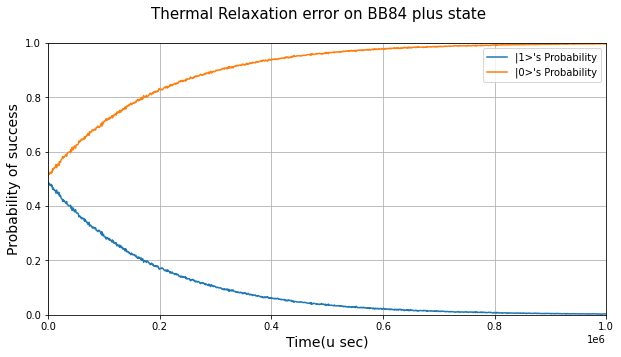

<Figure size 576x360 with 0 Axes>

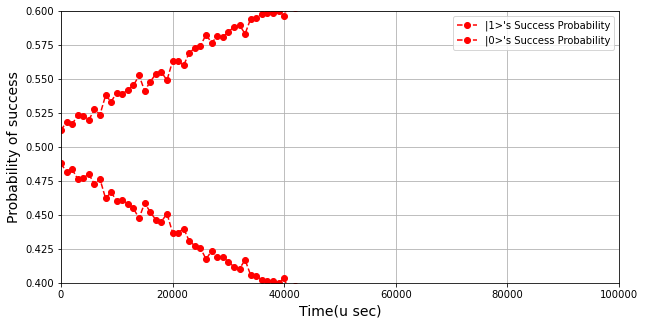

<Figure size 576x360 with 0 Axes>

In [65]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 plus state',fontsize=15)
# naming the x axis
plt.xlabel('Time(u sec)',fontsize=14)
# naming the y axis
plt.ylabel('Probability of success',fontsize=14)
plt.grid()
# giving a title to my graph
# Set axis ranges; by default this will put major ticks every 25.
#ax.set_xlim(0, 300)
#ax.set_ylim(0, 1)
ax.set_xlim(0, 1000000)
ax.set_ylim(0,1)
fig = plt.figure(figsize=(8,5))
# line 2 points
x1=delay
x2=delay
#plotting the line 2 points
ax.plot(x1, y1, label = "|1>'s Probability")
ax.plot(x2, y2, label = "|0>'s Probability")

#ax.axes.xaxis.set_ticks([])
# show a legend on the plot
ax.legend()
########################################################################


%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(0, 100000)
ax.set_ylim(0.4,0.6)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec)',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,y1,'ro--',label = "|1>'s Success Probability")
ax.plot(delay,y2,'ro--',label = "|0>'s Success Probability")

ax.legend()

# Minus State Graph

# Delay

In [67]:
import matplotlib.pyplot as plt
success_state0=[]
success_state1=[]

for j in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '4'
    apply_error = {"delay":True, "measure": False, "gate": False}
    success0 = []
    success1 = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success0.append(prob[0])
        success1.append(prob[1])
    success_state0.append(success0)
    success_state1.append(success1)

In [68]:
from statistics import mean
a= success_state0
print(*map(mean, zip(*a)))

0.49475 0.501 0.50725 0.5064 0.51545 0.51705 0.5142 0.5165500000000001 0.5111 0.523 0.5277000000000001 0.52685 0.5303 0.5357500000000001 0.53635 0.53725 0.54215 0.5406000000000001 0.54285 0.54905 0.5513 0.5504 0.5541 0.5569000000000001 0.56445 0.5525 0.5655 0.57255 0.5693 0.56625 0.5684 0.5761 0.5724 0.57245 0.582 0.5819 0.58955 0.586 0.5898 0.5897 0.5912499999999999 0.58965 0.60415 0.60395 0.5994999999999999 0.60665 0.60415 0.60755 0.60695 0.60505 0.614 0.6172 0.6137 0.6181 0.62 0.6266 0.62745 0.6298 0.63165 0.63535 0.63475 0.63275 0.6345000000000001 0.6378 0.63735 0.6454 0.64435 0.64575 0.6513 0.6467 0.64815 0.6557000000000001 0.6578 0.65615 0.6553 0.6646500000000001 0.6653 0.67265 0.6601 0.6733 0.6697500000000001 0.6746 0.67155 0.6784 0.6772 0.673 0.6842 0.68575 0.68835 0.6831 0.6859000000000001 0.69115 0.69255 0.6923 0.6940999999999999 0.69405 0.6933 0.69115 0.70245 0.6982999999999999 0.7022499999999999 0.70285 0.69955 0.7143999999999999 0.70455 0.7119 0.71285 0.71475 0.71229999999

0.9944999999999999 0.9949 0.9949 0.99485 0.9943 0.9953 0.99525 0.9947 0.99495 0.9952 0.99595 0.99505 0.99455 0.99455 0.9957 0.9956 0.99565 0.99555 0.9961 0.9943 0.9953 0.99565 0.99525 0.99525 0.99535 0.99585 0.99575 0.99545 0.99615 0.99585 0.995 0.9958 0.99605 0.9966 0.9963 0.9964 0.9947 0.99615 0.9948 0.9963 0.99585 0.99625 0.99625 0.99565 0.99565 0.99545 0.99535 0.9957 0.9963 0.99565 0.99655 0.9962 0.996 0.99605 0.9969 0.9948 0.9959 0.99605 0.9956 0.99615 0.99625 0.9968 0.99655 0.9964 0.99655 0.99675 0.996 0.9962 0.9959 0.9954 0.99635 0.99715 0.99625 0.99675 0.9962 0.99685 0.99695 0.99685 0.99735 0.9963 0.99685 0.99685 0.9962 0.9963 0.99665 0.99705 0.9964999999999999 0.99675 0.9964999999999999 0.99655 0.99655 0.9972 0.99645 0.99685 0.99695 0.99735 0.99665 0.99725 0.99705 0.9967 0.9975 0.9972 0.9964 0.9966 0.99665 0.9969 0.99685 0.99735 0.99685 0.997 0.9975 0.9977 0.99715 0.99725 0.99705 0.9969 0.9968


In [69]:
from statistics import mean
a= success_state1
print(*map(mean, zip(*a)))

0.50525 0.499 0.49275 0.4936 0.48455 0.48295 0.4858 0.48345 0.4889 0.477 0.4723 0.47315 0.4697 0.46425 0.46365 0.46275 0.45785000000000003 0.45940000000000003 0.45715 0.45095 0.4487 0.4496 0.4459 0.4431 0.43555 0.4475 0.4345 0.42745 0.43069999999999997 0.43374999999999997 0.4316 0.4239 0.4276 0.42755 0.418 0.41809999999999997 0.41045 0.414 0.4102 0.4103 0.40875 0.41035 0.39585 0.39605 0.4005 0.39335 0.39585 0.39245 0.39305 0.39495 0.386 0.38280000000000003 0.3863 0.3819 0.38 0.3734 0.37255 0.3702 0.36835 0.36465 0.36525 0.36725 0.3655 0.36219999999999997 0.36265 0.35459999999999997 0.35565 0.35425 0.3487 0.3533 0.35185 0.3443 0.3422 0.34385 0.3447 0.33535000000000004 0.3347 0.32735000000000003 0.3399 0.3267 0.33025 0.3254 0.32845 0.3216 0.32280000000000003 0.327 0.3158 0.31425000000000003 0.31165 0.3169 0.3141 0.30885 0.30745 0.3077 0.3059 0.30595 0.3067 0.30885 0.29755 0.30169999999999997 0.29775 0.29715 0.30045 0.2856 0.29545 0.2881 0.28715 0.28525 0.2877 0.2772 0.2842 0.2852 0.27785

In [74]:
delay1=[0.50525,0.499,0.49275,0.4936,0.48455,0.48295,0.4858,0.48345,0.4889,0.477,0.4723,0.47315,0.4697,0.46425,0.46365,0.46275,0.45785000000000003,0.45940000000000003,0.45715,0.45095,0.4487,0.4496,0.4459,0.4431,0.43555,0.4475,0.4345,0.42745,0.43069999999999997,0.43374999999999997,0.4316,0.4239,0.4276,0.42755,0.418,0.41809999999999997,0.41045,0.414,0.4102,0.4103,0.40875,0.41035,0.39585,0.39605,0.4005,0.39335,0.39585,0.39245,0.39305,0.39495,0.386,0.38280000000000003,0.3863,0.3819,0.38,0.3734,0.37255,0.3702,0.36835,0.36465,0.36525,0.36725,0.3655,0.36219999999999997,0.36265,0.35459999999999997,0.35565,0.35425,0.3487,0.3533,0.35185,0.3443,0.3422,0.34385,0.3447,0.33535000000000004,0.3347,0.32735000000000003,0.3399,0.3267,0.33025,0.3254,0.32845,0.3216,0.32280000000000003,0.327,0.3158,0.31425000000000003,0.31165,0.3169,0.3141,0.30885,0.30745,0.3077,0.3059,0.30595,0.3067,0.30885,0.29755,0.30169999999999997,0.29775,0.29715,0.30045,0.2856,0.29545,0.2881,0.28715,0.28525,0.2877,0.2772,0.2842,0.2852,0.27785,0.27885,0.2783,0.27615,0.27545000000000003,0.27015,0.26990000000000003,0.2734,0.2691,0.26735000000000003,0.2662,0.2671,0.2596,0.2596,0.26305,0.259,0.2569,0.25835,0.25685,0.25555,0.25375000000000003,0.25135,0.24925,0.24545,0.24705,0.2379,0.24085,0.23885,0.24275,0.24295,0.2419,0.24155,0.23595,0.2324,0.24080000000000001,0.23135,0.2341,0.23165,0.23105,0.23075,0.2253,0.22645,0.22465,0.22515,0.2254,0.22335,0.2239,0.21635,0.21565,0.21795,0.2199,0.2131,0.21905,0.21255,0.2097,0.2109,0.20925,0.20795,0.21325,0.20605,0.20400000000000001,0.2054,0.2047,0.20675,0.2009,0.1999,0.20385,0.1948,0.1926,0.19915,0.1937,0.19465,0.18945,0.19065000000000001,0.1873,0.18715,0.19115,0.18764999999999998,0.1895,0.18925,0.1823,0.18535,0.18345,0.17945,0.17655,0.18145,0.181,0.17779999999999999,0.17215,0.17915,0.1808,0.1753,0.1725,0.1757,0.17455,0.17095,0.1736,0.16885,0.16645,0.16475,0.1682,0.1662,0.1612,0.16215,0.1585,0.16075,0.1653,0.15655,0.15845,0.15825,0.1569,0.1558,0.15485,0.15525,0.151,0.15295,0.1519,0.15225,0.15525,0.1555,0.1502,0.15325,0.14985,0.147,0.14535,0.1457,0.14595,0.14625,0.1457,0.14385,0.13855,0.13955,0.1398,0.14015,0.139,0.135,0.1405,0.1324,0.13575,0.137,0.13675,0.1343,0.1353,0.13735,0.12755,0.1322,0.12705,0.1307,0.12605,0.12995,0.131,0.1327,0.12465,0.1239,0.12510000000000002,0.1238,0.1247,0.12545,0.12695,0.12655,0.1245,0.11785,0.1216,0.1257,0.12495,0.1223,0.1222,0.11750000000000001,0.11875,0.11555,0.1131,0.1135,0.11255,0.1177,0.1133,0.11325,0.1107,0.1105,0.11015,0.11135,0.11205,0.1058,0.1125,0.1071,0.1076,0.1059,0.1046,0.10365,0.10335,0.1076,0.10745,0.1064,0.0975,0.10825,0.1069,0.10015,0.10475,0.0985,0.0991,0.1,0.09775,0.097,0.10005,0.09745,0.09695,0.09655,0.09655,0.0981,0.09380000000000001,0.09605,0.09505,0.0931,0.08795,0.08995,0.0936,0.09075,0.09175,0.0927,0.0898,0.0925,0.0893,0.08875,0.0877,0.0897,0.08645,0.08345,0.08585,0.0852,0.0884,0.0868,0.0864,0.08295,0.08605,0.07695,0.0835,0.07975,0.08265,0.0822,0.0841,0.0813,0.0801,0.07835,0.08215,0.0761,0.07965,0.0799,0.0796,0.0811,0.0764,0.07775,0.0775,0.0776,0.0767,0.0772,0.07575,0.07815,0.07485,0.0736,0.07535,0.0743,0.07345,0.0766,0.0726,0.06735000000000001,0.0685,0.07025,0.07005,0.0692,0.0708,0.06935,0.0678,0.06705,0.0636,0.06755,0.0673,0.0653,0.06795,0.06525,0.06485,0.06655,0.06695,0.0645,0.0649,0.0656,0.0623,0.06520000000000001,0.0636,0.0628,0.06655,0.06075,0.0609,0.06605,0.0601,0.0607,0.0604,0.0604,0.06075,0.0622,0.05915,0.05995,0.05825,0.05775,0.0562,0.0606,0.05715,0.05575,0.0549,0.05835,0.05745,0.05575,0.05475,0.0567,0.0525,0.0581,0.0547,0.0536,0.0566,0.0543,0.05235,0.0518,0.05375,0.051750000000000004,0.0518,0.05325,0.05095,0.0518,0.0523,0.0509,0.05055,0.0494,0.04915,0.04945,0.05245,0.048549999999999996,0.04995,0.04845,0.04995,0.04895,0.04885,0.04925,0.0478,0.04815,0.0455,0.0451,0.0471,0.04545,0.0453,0.0442,0.046,0.0472,0.04595,0.0445,0.04535,0.0462,0.04625,0.04395,0.04605,0.04385,0.04485,0.04365,0.04095,0.04475,0.0456,0.04145,0.04465,0.04375,0.0413,0.04325,0.04115,0.04255,0.04195,0.04335,0.0407,0.039850000000000003,0.0408,0.03885,0.0395,0.03715,0.0395,0.0368,0.03915,0.0388,0.03875,0.03955,0.03775,0.03585,0.03755,0.037,0.03905,0.036699999999999997,0.039099999999999996,0.03495,0.0364,0.03795,0.03475,0.03465,0.0373,0.0364,0.0362,0.03215,0.034,0.0352,0.0377,0.03445,0.03345,0.03495,0.03145,0.0327,0.0341,0.03215,0.0323,0.0339,0.0337,0.03595,0.03345,0.0331,0.03005,0.0307,0.03395,0.02955,0.02995,0.02955,0.03105,0.03145,0.03015,0.0313,0.03355,0.0294,0.02945,0.0314,0.0314,0.0299,0.0303,0.0304,0.02835,0.03165,0.0276,0.03025,0.0277,0.0298,0.02835,0.0307,0.02835,0.0293,0.027,0.0304,0.0303,0.02715,0.0291,0.02665,0.026600000000000002,0.02635,0.0257,0.0268,0.02655,0.02675,0.02685,0.027,0.0249,0.02635,0.0254,0.0261,0.02315,0.02405,0.02615,0.02225,0.0267,0.0234,0.02335,0.02555,0.0258,0.0231,0.0235,0.02495,0.02595,0.0246,0.0247,0.02225,0.0227,0.02375,0.0233,0.02445,0.0245,0.0237,0.0235,0.02165,0.0232,0.022,0.02095,0.02415,0.02095,0.0216,0.02225,0.02265,0.02155,0.0209,0.0205,0.0207,0.02245,0.020399999999999998,0.0225,0.02045,0.01965,0.0202,0.0214,0.0196,0.01945,0.0204,0.0182,0.01985,0.01915,0.0207,0.01955,0.01975,0.0196,0.0198,0.01915,0.0185,0.0203,0.01855,0.0193,0.0182,0.019200000000000002,0.01785,0.0172,0.01905,0.01975,0.01875,0.01725,0.0187,0.0198,0.0191,0.01675,0.0166,0.01775,0.01815,0.01795,0.0186,0.0183,0.0167,0.0164,0.01775,0.01845,0.0173,0.01705,0.0167,0.01625,0.01675,0.017,0.0161,0.0155,0.01565,0.0167,0.01705,0.01705,0.01675,0.01595,0.0156,0.015349999999999999,0.01505,0.016050000000000002,0.0167,0.01515,0.01525,0.0133,0.01465,0.01415,0.01335,0.0154,0.01465,0.01395,0.015050000000000001,0.01445,0.0137,0.01425,0.013,0.01435,0.01455,0.01445,0.0144,0.0132,0.01465,0.0149,0.01295,0.01295,0.01195,0.0117,0.014199999999999999,0.0115,0.013,0.01305,0.01255,0.0139,0.0131,0.0129,0.0131,0.013649999999999999,0.01195,0.0132,0.0124,0.013649999999999999,0.01355,0.01225,0.013,0.0129,0.01345,0.01235,0.01205,0.01095,0.012,0.011349999999999999,0.01085,0.012499999999999999,0.0121,0.01265,0.01155,0.01095,0.01125,0.01295,0.0115,0.01125,0.01045,0.0115,0.0109,0.0118,0.0126,0.01075,0.01115,0.01005,0.0112,0.01095,0.0101,0.01125,0.01065,0.01065,0.01005,0.00935,0.01085,0.0104,0.0093,0.00995,0.0114,0.01,0.0103,0.00995,0.0097,0.0093,0.00945,0.00965,0.00875,0.01005,0.00905,0.01045,0.00915,0.0098,0.0103,0.009,0.0097,0.0086,0.01005,0.0086,0.00905,0.01065,0.00845,0.00895,0.0097,0.009,0.009,0.0092,0.00855,0.009049999999999999,0.0091,0.0086,0.0089,0.0089,0.0087,0.009,0.0086,0.00925,0.00875,0.00805,0.0088,0.0076,0.00825,0.0087,0.0082,0.0081,0.00735,0.00795,0.0076,0.00885,0.0075,0.0077,0.0076,0.00825,0.0078,0.00855,0.00665,0.0070999999999999995,0.008,0.007549999999999999,0.00725,0.0084,0.00685,0.00765,0.00685,0.0076,0.0065,0.00775,0.00705,0.0073,0.0061,0.00645,0.0072,0.00705,0.00695,0.0071,0.006,0.0058,0.0073,0.006,0.00695,0.0069,0.0069,0.0061,0.00645,0.00585,0.0049,0.00625,0.0071,0.00515,0.0056500000000000005,0.0073,0.006,0.0054,0.0066,0.0060999999999999995,0.00625,0.0064,0.0056,0.00615,0.0066,0.00555,0.0051,0.0065,0.0075,0.00535,0.0051,0.00535,0.00515,0.00515,0.00485,0.00655,0.0061,0.0062,0.00535,0.00655,0.0053,0.00525,0.0048000000000000004,0.0058000000000000005,0.0049,0.00525,0.0053,0.00465,0.0045000000000000005,0.00445,0.00435,0.0045000000000000005,0.00495,0.00625,0.0053,0.0055,0.0051,0.0051,0.00515,0.0057,0.0047,0.00475,0.0053,0.00505,0.0048000000000000004,0.00405,0.00495,0.00545,0.00545,0.0043,0.0044,0.00435,0.00445,0.0039000000000000003,0.0057,0.0047,0.00435,0.00475,0.00475,0.0046500000000000005,0.00415,0.00425,0.00455,0.00385,0.00415,0.005,0.0042,0.00395,0.0034000000000000002,0.0037,0.0036,0.0053,0.00385,0.0052,0.0037,0.00415,0.00375,0.00375,0.00435,0.00435,0.00455,0.0046500000000000005,0.0043,0.0037,0.00435,0.00345,0.0038,0.004,0.00395,0.0031,0.0052,0.0041,0.00395,0.0044,0.00385,0.00375,0.0032,0.00345,0.0036,0.00345,0.0032500000000000003,0.004,0.0038,0.0041,0.0046,0.00365,0.00285,0.00375,0.0032500000000000003,0.0038,0.00315,0.00305,0.00315,0.00265,0.0037,0.00315,0.00315,0.0038,0.0037,0.00335,0.00295,0.0035,0.0032500000000000003,0.0035,0.00345,0.00345,0.0028,0.00355,0.00315,0.00305,0.00265,0.00335,0.00275,0.00295,0.0033,0.0025,0.0028,0.0036,0.0034000000000000002,0.00335,0.0031,0.00315,0.00265,0.00315,0.003,0.0025,0.0023,0.00285,0.00275,0.00295,0.0031,0.0032]
#one

In [73]:
delay0=[0.49475,0.501,0.50725,0.5064,0.51545,0.51705,0.5142,0.5165500000000001,0.5111,0.523,0.5277000000000001,0.52685,0.5303,0.5357500000000001,0.53635,0.53725,0.54215,0.5406000000000001,0.54285,0.54905,0.5513,0.5504,0.5541,0.5569000000000001,0.56445,0.5525,0.5655,0.57255,0.5693,0.56625,0.5684,0.5761,0.5724,0.57245,0.582,0.5819,0.58955,0.586,0.5898,0.5897,0.5912499999999999,0.58965,0.60415,0.60395,0.5994999999999999,0.60665,0.60415,0.60755,0.60695,0.60505,0.614,0.6172,0.6137,0.6181,0.62,0.6266,0.62745,0.6298,0.63165,0.63535,0.63475,0.63275,0.6345000000000001,0.6378,0.63735,0.6454,0.64435,0.64575,0.6513,0.6467,0.64815,0.6557000000000001,0.6578,0.65615,0.6553,0.6646500000000001,0.6653,0.67265,0.6601,0.6733,0.6697500000000001,0.6746,0.67155,0.6784,0.6772,0.673,0.6842,0.68575,0.68835,0.6831,0.6859000000000001,0.69115,0.69255,0.6923,0.6940999999999999,0.69405,0.6933,0.69115,0.70245,0.6982999999999999,0.7022499999999999,0.70285,0.69955,0.7143999999999999,0.70455,0.7119,0.71285,0.71475,0.7122999999999999,0.7228,0.7158,0.7148,0.72215,0.72115,0.7217,0.72385,0.72455,0.72985,0.7301,0.7266,0.7309,0.73265,0.7338,0.7329,0.7404,0.7404,0.73695,0.741,0.7431,0.74165,0.74315,0.74445,0.74625,0.74865,0.75075,0.75455,0.75295,0.7621,0.75915,0.76115,0.75725,0.75705,0.7581,0.75845,0.76405,0.7676000000000001,0.7592,0.76865,0.7659,0.76835,0.76895,0.76925,0.7747,0.7735500000000001,0.77535,0.77485,0.7746000000000001,0.7766500000000001,0.7761,0.7836500000000001,0.78435,0.78205,0.7801,0.7869,0.78095,0.78745,0.7903,0.7891,0.7907500000000001,0.79205,0.7867500000000001,0.79395,0.796,0.7946,0.7953,0.79325,0.7991,0.8001,0.79615,0.8052,0.8074,0.8008500000000001,0.8063,0.80535,0.81055,0.80935,0.8127,0.81285,0.8088500000000001,0.81235,0.8105,0.81075,0.8177,0.81465,0.81655,0.82055,0.82345,0.81855,0.819,0.8221999999999999,0.82785,0.82085,0.8191999999999999,0.8247,0.8275,0.8243,0.82545,0.82905,0.8264,0.8311499999999999,0.83355,0.8352499999999999,0.8318,0.8338,0.8388,0.83785,0.8414999999999999,0.8392499999999999,0.8347,0.8434499999999999,0.84155,0.84175,0.8431,0.8442,0.84515,0.84475,0.849,0.84705,0.8481,0.84775,0.84475,0.8445,0.8498,0.84675,0.85015,0.853,0.85465,0.8543,0.85405,0.85375,0.8543,0.85615,0.8614499999999999,0.8604499999999999,0.8602,0.85985,0.861,0.865,0.8594999999999999,0.8676,0.86425,0.863,0.86325,0.8657,0.8647,0.86265,0.87245,0.8678,0.87295,0.8693,0.87395,0.87005,0.869,0.8673,0.87535,0.8761,0.8749,0.8762,0.8753,0.87455,0.87305,0.87345,0.8755,0.88215,0.8784,0.8743,0.87505,0.8777,0.8778,0.8825000000000001,0.88125,0.88445,0.8869,0.8865000000000001,0.88745,0.8823,0.8867,0.88675,0.8893,0.8895,0.88985,0.88865,0.88795,0.8942,0.8875,0.8929,0.8924,0.8941,0.8954,0.89635,0.8966500000000001,0.8924,0.8925500000000001,0.8936000000000001,0.9025000000000001,0.89175,0.8931,0.89985,0.89525,0.9015,0.9009,0.9,0.90225,0.903,0.89995,0.9025500000000001,0.90305,0.90345,0.90345,0.9019,0.9062,0.90395,0.90495,0.9069,0.91205,0.91005,0.9064,0.90925,0.90825,0.9073,0.9102,0.9075,0.9107000000000001,0.91125,0.9123,0.9103,0.9135500000000001,0.9165500000000001,0.91415,0.9148000000000001,0.9116000000000001,0.9132,0.9136000000000001,0.91705,0.91395,0.92305,0.9165000000000001,0.92025,0.91735,0.9178000000000001,0.9159,0.9187000000000001,0.9199,0.9216500000000001,0.91785,0.9239,0.92035,0.9201,0.9204,0.9189,0.9236000000000001,0.92225,0.9225000000000001,0.9224,0.9233,0.9228000000000001,0.92425,0.9218500000000001,0.92515,0.9264,0.92465,0.9257000000000001,0.92655,0.9234,0.9274,0.93265,0.9315,0.9297500000000001,0.92995,0.9308000000000001,0.9292,0.93065,0.9322,0.9329500000000001,0.9364,0.93245,0.9327,0.9347,0.93205,0.93475,0.93515,0.93345,0.93305,0.9355,0.9351,0.9344,0.9377,0.9348,0.9364,0.9372,0.93345,0.93925,0.9390999999999999,0.9339500000000001,0.9399,0.9393,0.9396,0.9396,0.93925,0.9378,0.94085,0.9400499999999999,0.94175,0.94225,0.9438,0.9394,0.94285,0.9442499999999999,0.9450999999999999,0.94165,0.94255,0.9442499999999999,0.9452499999999999,0.9433,0.9475,0.9419,0.9452999999999999,0.9463999999999999,0.9434,0.9457,0.94765,0.9481999999999999,0.9462499999999999,0.9482499999999999,0.9481999999999999,0.94675,0.94905,0.9481999999999999,0.9477,0.9490999999999999,0.94945,0.9506,0.95085,0.95055,0.94755,0.9514499999999999,0.95005,0.95155,0.95005,0.95105,0.9511499999999999,0.95075,0.9521999999999999,0.95185,0.9545,0.9549,0.9529,0.95455,0.9547,0.9558,0.954,0.9528,0.95405,0.9555,0.95465,0.9538,0.95375,0.95605,0.95395,0.9561499999999999,0.9551499999999999,0.9563499999999999,0.95905,0.9552499999999999,0.9543999999999999,0.95855,0.9553499999999999,0.9562499999999999,0.9587,0.95675,0.95885,0.9574499999999999,0.95805,0.95665,0.9592999999999999,0.96015,0.9591999999999999,0.96115,0.9604999999999999,0.96285,0.9604999999999999,0.9632,0.96085,0.9611999999999999,0.9612499999999999,0.9604499999999999,0.9622499999999999,0.96415,0.9624499999999999,0.963,0.96095,0.9632999999999999,0.9609,0.96505,0.9636,0.96205,0.9652499999999999,0.9653499999999999,0.9627,0.9636,0.9638,0.96785,0.966,0.9648,0.9622999999999999,0.96555,0.96655,0.96505,0.96855,0.9672999999999999,0.9659,0.96785,0.9677,0.9661,0.9662999999999999,0.96405,0.96655,0.9669,0.96995,0.9692999999999999,0.96605,0.9704499999999999,0.97005,0.9704499999999999,0.96895,0.96855,0.96985,0.9687,0.9664499999999999,0.9706,0.97055,0.9686,0.9686,0.9701,0.9697,0.9696,0.97165,0.9683499999999999,0.9723999999999999,0.96975,0.9722999999999999,0.9702,0.97165,0.9692999999999999,0.97165,0.9707,0.973,0.9696,0.9697,0.97285,0.9709,0.9733499999999999,0.9733999999999999,0.97365,0.9742999999999999,0.9732,0.9734499999999999,0.97325,0.97315,0.973,0.9751,0.97365,0.9746,0.9739,0.97685,0.97595,0.97385,0.97775,0.9732999999999999,0.9766,0.97665,0.9744499999999999,0.9742,0.9769,0.9764999999999999,0.97505,0.97405,0.9753999999999999,0.9753,0.97775,0.9773,0.97625,0.9767,0.97555,0.9755,0.9763,0.9764999999999999,0.9783499999999999,0.9768,0.978,0.97905,0.97585,0.97905,0.9783999999999999,0.97775,0.9773499999999999,0.9784499999999999,0.9791,0.9795,0.9793,0.97755,0.9796,0.9775,0.97955,0.9803499999999999,0.9798,0.9786,0.9803999999999999,0.98055,0.9796,0.9818,0.98015,0.98085,0.9793,0.9804499999999999,0.98025,0.9803999999999999,0.9802,0.98085,0.9815,0.9797,0.9814499999999999,0.9807,0.9818,0.9808,0.98215,0.9828,0.98095,0.98025,0.98125,0.98275,0.9813,0.9802,0.9809,0.98325,0.9833999999999999,0.98225,0.98185,0.98205,0.9813999999999999,0.9817,0.9833,0.9836,0.98225,0.98155,0.9827,0.98295,0.9833,0.98375,0.98325,0.983,0.9839,0.9844999999999999,0.98435,0.9833,0.98295,0.98295,0.98325,0.98405,0.9843999999999999,0.98465,0.98495,0.98395,0.9833,0.98485,0.98475,0.9867,0.98535,0.98585,0.98665,0.9846,0.98535,0.98605,0.98495,0.98555,0.9863,0.98575,0.987,0.98565,0.9854499999999999,0.98555,0.9856,0.9868,0.98535,0.9851,0.98705,0.98705,0.98805,0.9883,0.9858,0.9884999999999999,0.987,0.98695,0.9874499999999999,0.9861,0.9869,0.9871,0.9869,0.98635,0.98805,0.9868,0.9876,0.98635,0.9864499999999999,0.98775,0.987,0.9871,0.98655,0.98765,0.98795,0.98905,0.988,0.98865,0.98915,0.9875,0.9879,0.98735,0.9884499999999999,0.98905,0.98875,0.98705,0.9884999999999999,0.98875,0.98955,0.9884999999999999,0.9891,0.9882,0.9873999999999999,0.98925,0.98885,0.98995,0.9888,0.98905,0.9899,0.98875,0.98935,0.98935,0.98995,0.99065,0.98915,0.9896,0.9907,0.99005,0.9886,0.99,0.9897,0.99005,0.9903,0.9907,0.99055,0.99035,0.99125,0.98995,0.99095,0.98955,0.99085,0.9902,0.9897,0.991,0.9903,0.9914,0.98995,0.9914,0.99095,0.98935,0.99155,0.99105,0.9903,0.991,0.991,0.9908,0.9914499999999999,0.99095,0.9909,0.9914,0.9911,0.9911,0.9913,0.991,0.9914,0.99075,0.99125,0.99195,0.9912,0.9924,0.99175,0.9913,0.9918,0.9919,0.99265,0.99205,0.9924,0.99115,0.9924999999999999,0.9923,0.9924,0.99175,0.9922,0.9914499999999999,0.99335,0.9929,0.992,0.9924499999999999,0.99275,0.9916,0.99315,0.99235,0.99315,0.9924,0.9935,0.99225,0.99295,0.9927,0.9939,0.99355,0.9928,0.99295,0.99305,0.9929,0.994,0.9942,0.9927,0.994,0.99305,0.9931,0.9931,0.9939,0.99355,0.99415,0.9951,0.99375,0.9929,0.99485,0.99435,0.9927,0.994,0.9946,0.9934,0.9939,0.99375,0.9936,0.9944,0.99385,0.9934,0.99445,0.9949,0.9935,0.9924999999999999,0.99465,0.9949,0.99465,0.99485,0.99485,0.99515,0.9934499999999999,0.9939,0.9938,0.99465,0.9934499999999999,0.9947,0.99475,0.9952,0.9942,0.9951,0.99475,0.9947,0.99535,0.9955,0.99555,0.99565,0.9955,0.99505,0.99375,0.9947,0.9944999999999999,0.9949,0.9949,0.99485,0.9943,0.9953,0.99525,0.9947,0.99495,0.9952,0.99595,0.99505,0.99455,0.99455,0.9957,0.9956,0.99565,0.99555,0.9961,0.9943,0.9953,0.99565,0.99525,0.99525,0.99535,0.99585,0.99575,0.99545,0.99615,0.99585,0.995,0.9958,0.99605,0.9966,0.9963,0.9964,0.9947,0.99615,0.9948,0.9963,0.99585,0.99625,0.99625,0.99565,0.99565,0.99545,0.99535,0.9957,0.9963,0.99565,0.99655,0.9962,0.996,0.99605,0.9969,0.9948,0.9959,0.99605,0.9956,0.99615,0.99625,0.9968,0.99655,0.9964,0.99655,0.99675,0.996,0.9962,0.9959,0.9954,0.99635,0.99715,0.99625,0.99675,0.9962,0.99685,0.99695,0.99685,0.99735,0.9963,0.99685,0.99685,0.9962,0.9963,0.99665,0.99705,0.9964999999999999,0.99675,0.9964999999999999,0.99655,0.99655,0.9972,0.99645,0.99685,0.99695,0.99735,0.99665,0.99725,0.99705,0.9967,0.9975,0.9972,0.9964,0.9966,0.99665,0.9969,0.99685,0.99735,0.99685,0.997,0.9975,0.9977,0.99715,0.99725,0.99705,0.9969,0.9968]
#Zero

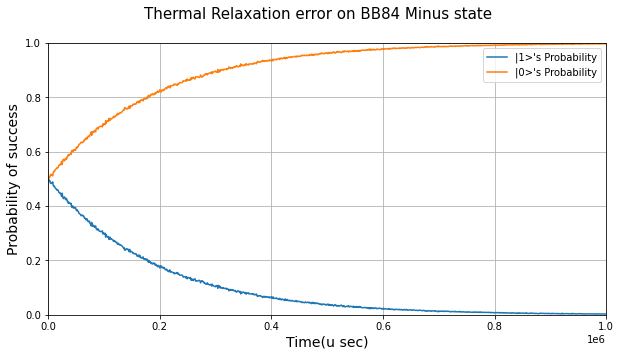

<Figure size 576x360 with 0 Axes>

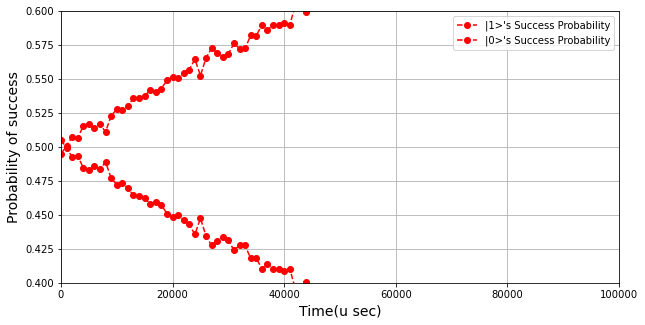

<Figure size 576x360 with 0 Axes>

In [75]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 Minus state',fontsize=15)
# naming the x axis
plt.xlabel('Time(u sec)',fontsize=14)
# naming the y axis
plt.ylabel('Probability of success',fontsize=14)
plt.grid()
# giving a title to my graph
# Set axis ranges; by default this will put major ticks every 25.
#ax.set_xlim(0, 300)
#ax.set_ylim(0, 1)
ax.set_xlim(0, 1000000)
ax.set_ylim(0,1)
fig = plt.figure(figsize=(8,5))
# line 2 points
x1=delay
x2=delay
#plotting the line 2 points
ax.plot(x1, delay1, label = "|1>'s Probability")
ax.plot(x2, delay0, label = "|0>'s Probability")

#ax.axes.xaxis.set_ticks([])
# show a legend on the plot
ax.legend()
########################################################################


%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(0, 100000)
ax.set_ylim(0.4,0.6)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec)',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,delay1,'ro--',label = "|1>'s Success Probability")
ax.plot(delay,delay0,'ro--',label = "|0>'s Success Probability")

ax.legend()

# Delay + measurement 

In [70]:
import matplotlib.pyplot as plt
success_state0=[]
success_state1=[]

for j in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '4'
    apply_error = {"delay":True, "measure": True, "gate": False}
    success0 = []
    success1 = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success0.append(prob[0])
        success1.append(prob[1])
    success_state0.append(success0)
    success_state1.append(success1)

In [71]:
from statistics import mean
a= success_state0
print(*map(mean, zip(*a)))

0.5074 0.5169 0.5172 0.51675 0.52305 0.5257000000000001 0.5237 0.5313 0.52775 0.5379 0.535 0.5481 0.53985 0.54285 0.5438500000000001 0.5486 0.54725 0.5559000000000001 0.55555 0.56245 0.556 0.5613 0.5683 0.5638 0.56875 0.57675 0.57275 0.5752999999999999 0.57805 0.57745 0.5824 0.58545 0.58905 0.58995 0.5944499999999999 0.59825 0.5922 0.59805 0.5945 0.6025 0.6053 0.6043999999999999 0.6067 0.6061 0.6154999999999999 0.6114499999999999 0.6222 0.61785 0.6214 0.62375 0.6234 0.6228 0.6241 0.6339 0.63285 0.6343 0.6388 0.6326 0.6374 0.64065 0.64025 0.6459 0.6473 0.64545 0.6475500000000001 0.65895 0.6541 0.65345 0.65195 0.6633 0.6533 0.6604 0.6591 0.6674 0.6667000000000001 0.675 0.67 0.6747000000000001 0.676 0.67825 0.6803 0.6775 0.6818 0.68125 0.68325 0.6798500000000001 0.6874 0.6911 0.69125 0.695 0.69445 0.6942999999999999 0.7009 0.6996 0.6988 0.7036 0.7029 0.7091999999999999 0.71105 0.70565 0.7148 0.7153999999999999 0.7107 0.71475 0.7219 0.7152499999999999 0.71355 0.7244499999999999 0.7201 0.72

In [72]:
from statistics import mean
a= success_state1
print(*map(mean, zip(*a)))

0.4926 0.4831 0.4828 0.48325 0.47695 0.4743 0.4763 0.4687 0.47225 0.4621 0.465 0.4519 0.46015 0.45715 0.45615 0.4514 0.45275 0.4441 0.44445 0.43755 0.444 0.4387 0.4317 0.4362 0.43125 0.42325 0.42725 0.42469999999999997 0.42195 0.42255 0.41759999999999997 0.41455 0.41095 0.41005 0.40555 0.40175 0.4078 0.40195000000000003 0.40549999999999997 0.3975 0.3947 0.3956 0.3933 0.39390000000000003 0.3845 0.38855 0.3778 0.38215 0.3786 0.37625000000000003 0.3766 0.3772 0.3759 0.3661 0.36715 0.36569999999999997 0.36119999999999997 0.3674 0.3626 0.35935 0.35975 0.35409999999999997 0.3527 0.35455 0.35245 0.34105 0.3459 0.34654999999999997 0.34805 0.3367 0.3467 0.3396 0.3409 0.3326 0.3333 0.325 0.33 0.32530000000000003 0.324 0.32175 0.3197 0.3225 0.3182 0.31875 0.31675 0.32015 0.3126 0.3089 0.30874999999999997 0.305 0.30555 0.30569999999999997 0.2991 0.3004 0.30119999999999997 0.2964 0.2971 0.2908 0.28895 0.29435 0.2852 0.2846 0.2893 0.28525 0.2781 0.28475 0.28645 0.27555 0.2799 0.27655 0.27585 0.2772 

In [78]:
dm1=[0.4926,0.4831,0.4828,0.48325,0.47695,0.4743,0.4763,0.4687,0.47225,0.4621,0.465,0.4519,0.46015,0.45715,0.45615,0.4514,0.45275,0.4441,0.44445,0.43755,0.444,0.4387,0.4317,0.4362,0.43125,0.42325,0.42725,0.42469999999999997,0.42195,0.42255,0.41759999999999997,0.41455,0.41095,0.41005,0.40555,0.40175,0.4078,0.40195000000000003,0.40549999999999997,0.3975,0.3947,0.3956,0.3933,0.39390000000000003,0.3845,0.38855,0.3778,0.38215,0.3786,0.37625000000000003,0.3766,0.3772,0.3759,0.3661,0.36715,0.36569999999999997,0.36119999999999997,0.3674,0.3626,0.35935,0.35975,0.35409999999999997,0.3527,0.35455,0.35245,0.34105,0.3459,0.34654999999999997,0.34805,0.3367,0.3467,0.3396,0.3409,0.3326,0.3333,0.325,0.33,0.32530000000000003,0.324,0.32175,0.3197,0.3225,0.3182,0.31875,0.31675,0.32015,0.3126,0.3089,0.30874999999999997,0.305,0.30555,0.30569999999999997,0.2991,0.3004,0.30119999999999997,0.2964,0.2971,0.2908,0.28895,0.29435,0.2852,0.2846,0.2893,0.28525,0.2781,0.28475,0.28645,0.27555,0.2799,0.27655,0.27585,0.2772,0.27375,0.26745,0.2703,0.2695,0.26755,0.26665,0.2651,0.25945,0.2619,0.2601,0.2604,0.2562,0.25615,0.25405,0.25425000000000003,0.25225,0.2504,0.25245,0.24725,0.2466,0.25005,0.24515,0.2482,0.24495,0.23905,0.24145,0.24085,0.23775,0.23825,0.2341,0.2341,0.2355,0.2313,0.22955,0.22945,0.22605,0.2265,0.2259,0.223,0.22265,0.22365,0.22055,0.22,0.21445,0.21795,0.21575,0.21555,0.21115,0.21125,0.2118,0.20675,0.20825,0.21065,0.2073,0.20735,0.20625,0.20055,0.20585,0.19845,0.1996,0.2062,0.1968,0.1964,0.19725,0.19455,0.19555,0.19555,0.19405,0.18864999999999998,0.1946,0.1892,0.19,0.18655,0.1854,0.18735,0.18505,0.1863,0.182,0.1771,0.1812,0.1813,0.1812,0.1778,0.1742,0.17725,0.17915,0.17775,0.1714,0.17165,0.1704,0.1731,0.17075,0.17095,0.1698,0.1679,0.16445,0.17185,0.16345,0.16525,0.16145,0.16275,0.16285,0.159,0.1658,0.16145,0.1562,0.15795,0.16,0.15855,0.1576,0.15965,0.15335,0.14930000000000002,0.1555,0.15235,0.15385,0.14735,0.1485,0.15015,0.1444,0.14495,0.1464,0.14595,0.1417,0.14495,0.14165,0.14135,0.1419,0.14145,0.13955,0.13645,0.1353,0.13715,0.13745000000000002,0.1362,0.1366,0.1306,0.1336,0.1342,0.13715,0.1324,0.1334,0.1331,0.1305,0.1271,0.12764999999999999,0.1272,0.12955,0.1301,0.1263,0.1269,0.12940000000000002,0.1235,0.12115000000000001,0.1226,0.12695,0.11865,0.1233,0.12,0.1211,0.12325,0.11805,0.1152,0.11615,0.1133,0.1139,0.1156,0.11365,0.11295,0.11765,0.11345,0.1113,0.1109,0.11255,0.11425,0.1142,0.10855,0.109,0.10715,0.1098,0.1071,0.1095,0.10515,0.1052,0.1045,0.10615,0.1009,0.1045,0.10085,0.1038,0.10075,0.1026,0.10095,0.099,0.1036,0.1014,0.097,0.10305,0.09745,0.1021,0.09845,0.09525,0.0975,0.0948,0.09095,0.0959,0.09155,0.09435,0.09475,0.09154999999999999,0.09055,0.0915,0.0884,0.09535,0.0905,0.08965,0.08695,0.089,0.08835,0.0864,0.0851,0.08655,0.08795,0.08565,0.08745,0.08595,0.087,0.08635,0.08485,0.0858,0.08295,0.08355,0.07955,0.0825,0.0824,0.08385,0.08265,0.07819999999999999,0.07869999999999999,0.0773,0.08,0.07785,0.07515,0.07735,0.081,0.0771,0.07395,0.07695,0.07339999999999999,0.0804,0.07305,0.07305,0.07415000000000001,0.0751,0.0708,0.0733,0.07100000000000001,0.06925,0.0734,0.0725,0.07065,0.06935,0.07245,0.07115,0.0678,0.06635,0.0698,0.0702,0.0707,0.0687,0.06495,0.06635,0.0649,0.0664,0.06625,0.06625,0.0648,0.0679,0.0664,0.06095,0.06245,0.062,0.0648,0.06760000000000001,0.059500000000000004,0.06295,0.06145,0.060200000000000004,0.06585,0.0582,0.06235,0.06025,0.06245,0.06145,0.0606,0.0596,0.05945,0.05975,0.06,0.05645,0.0583,0.0582,0.0577,0.0548,0.05335,0.05635,0.0567,0.05635,0.0577,0.0577,0.0557,0.0546,0.054599999999999996,0.05385,0.05385,0.0556,0.0533,0.05325,0.055,0.05385,0.0514,0.051000000000000004,0.0529,0.0501,0.0512,0.0499,0.05165,0.0498,0.0483,0.05005,0.04935,0.0495,0.0513,0.04945,0.0487,0.0483,0.04675,0.04655,0.04765,0.0488,0.04715,0.0471,0.0469,0.04675,0.04505,0.0409,0.04535,0.0433,0.04695,0.0468,0.044449999999999996,0.04575,0.04345,0.0422,0.0419,0.0441,0.04105,0.04065,0.04385,0.04185,0.0439,0.0445,0.0408,0.04225,0.0407,0.04085,0.0423,0.0445,0.04035,0.0388,0.0395,0.0423,0.04025,0.0417,0.036950000000000004,0.03905,0.0376,0.04045,0.0395,0.0385,0.0381,0.03715,0.0369,0.038149999999999996,0.0388,0.03695,0.0375,0.03635,0.03585,0.033,0.0353,0.0353,0.0369,0.0366,0.0364,0.03275,0.03565,0.0354,0.0345,0.03265,0.03475,0.0339,0.03225,0.0336,0.033,0.033,0.0332,0.0351,0.03135,0.0318,0.03335,0.03195,0.030350000000000002,0.0328,0.0347,0.0331,0.03195,0.032350000000000004,0.0319,0.0324,0.03075,0.0317,0.0312,0.03075,0.029500000000000002,0.030600000000000002,0.02885,0.030100000000000002,0.02895,0.03085,0.0268,0.030950000000000002,0.02935,0.0293,0.030600000000000002,0.02575,0.0304,0.0285,0.027200000000000002,0.029500000000000002,0.0284,0.028900000000000002,0.0281,0.0279,0.0275,0.0268,0.0275,0.02555,0.0285,0.02635,0.02715,0.0259,0.02755,0.025500000000000002,0.0262,0.0254,0.0256,0.02415,0.0234,0.02465,0.02645,0.02575,0.0237,0.025,0.02515,0.02305,0.02365,0.024,0.0246,0.0231,0.02475,0.02215,0.02535,0.024399999999999998,0.02395,0.02305,0.0243,0.02075,0.0229,0.0225,0.02205,0.0235,0.02225,0.0212,0.02385,0.02375,0.022,0.02155,0.0211,0.0233,0.0217,0.0225,0.02225,0.02205,0.0209,0.0214,0.0207,0.0209,0.02065,0.0211,0.0213,0.02055,0.0196,0.019,0.01975,0.0205,0.01925,0.01925,0.02075,0.01975,0.0203,0.01935,0.019,0.0201,0.01795,0.0175,0.01905,0.02045,0.01965,0.02035,0.01765,0.0203,0.019200000000000002,0.0174,0.0179,0.01695,0.0175,0.01705,0.01695,0.018349999999999998,0.0184,0.0177,0.0167,0.017,0.0178,0.01765,0.0175,0.0174,0.0177,0.0164,0.0162,0.0182,0.0159,0.0151,0.01745,0.0153,0.0158,0.016050000000000002,0.01515,0.0158,0.0161,0.0159,0.0157,0.01525,0.01625,0.0173,0.0158,0.01755,0.01465,0.01485,0.01545,0.0157,0.0146,0.01495,0.01545,0.0148,0.0147,0.015,0.0132,0.0132,0.01555,0.01495,0.0137,0.0137,0.01445,0.0143,0.0135,0.01285,0.0128,0.0138,0.0158,0.01435,0.0133,0.0148,0.012799999999999999,0.0139,0.014,0.01415,0.01335,0.0123,0.0114,0.0133,0.0126,0.01345,0.014499999999999999,0.012499999999999999,0.0113,0.0113,0.0132,0.0126,0.0127,0.012199999999999999,0.0118,0.01375,0.0118,0.0121,0.01105,0.01145,0.0118,0.0132,0.0112,0.01215,0.01195,0.01065,0.0116,0.0107,0.0106,0.01055,0.01095,0.01265,0.01185,0.01195,0.0096,0.0115,0.0113,0.0108,0.011049999999999999,0.01055,0.0111,0.0106,0.00955,0.00965,0.01015,0.011,0.0097,0.00985,0.009899999999999999,0.01055,0.0092,0.00895,0.01045,0.01045,0.0102,0.0101,0.01,0.01025,0.01085,0.0091,0.00945,0.0096,0.00885,0.0105,0.01005,0.0091,0.00985,0.00825,0.009,0.0093,0.00845,0.0089,0.0106,0.00805,0.00905,0.008749999999999999,0.0081,0.00755,0.00795,0.0089,0.00935,0.0076,0.00825,0.00975,0.0076,0.0077,0.00895,0.0087,0.008,0.00825,0.00855,0.0088,0.00855,0.00725,0.00765,0.00825,0.0072,0.00875,0.00815,0.00785,0.00695,0.00865,0.00775,0.0085,0.0081,0.00765,0.0076500000000000005,0.0076,0.00635,0.00655,0.00675,0.00795,0.00655,0.0068,0.00785,0.00645,0.0078,0.00805,0.007,0.00715,0.00665,0.0083,0.006500000000000001,0.0065,0.0069500000000000004,0.00715,0.00605,0.00725,0.007,0.0074,0.00685,0.00615,0.0064,0.00665,0.0059,0.00615,0.00585,0.00595,0.0064,0.0062,0.0069500000000000004,0.00685,0.00635,0.0062,0.0052,0.0057,0.0052,0.00745,0.0067,0.00575,0.00535,0.0066,0.0065,0.0052,0.00535,0.00505,0.0054,0.00595,0.00535,0.00525,0.0056,0.00605,0.0055,0.0045,0.00545,0.0048000000000000004,0.0054,0.0048000000000000004,0.0052,0.0051,0.0046,0.00505,0.0049,0.00615,0.00355,0.0043,0.0056,0.0051,0.0057,0.0054,0.0049,0.00545,0.0053,0.00495,0.0054,0.0048000000000000004,0.0048000000000000004,0.00485,0.0045000000000000005,0.00455,0.004,0.005,0.00405,0.00365,0.0049,0.0043,0.0047,0.00455,0.0047,0.00435,0.00605,0.0051,0.005,0.00515,0.00415,0.00435,0.00485,0.00435,0.00435,0.0041,0.0054,0.00515,0.00445,0.005,0.0037,0.0041,0.0048000000000000004,0.00455,0.0043,0.00435,0.0034000000000000002,0.00485,0.004,0.00415,0.00445,0.0045,0.0042,0.00495,0.00295,0.00365,0.0041,0.0042,0.00445,0.0041,0.0039000000000000003,0.0032500000000000003,0.00415,0.00345,0.00335,0.0038,0.00455,0.00355,0.0042,0.00425,0.0038,0.00425,0.00345,0.0039000000000000003,0.00345,0.00395,0.0049,0.0031,0.00305,0.0041,0.00375,0.00365,0.00375,0.0032,0.00335,0.00275,0.00295,0.0035,0.0038,0.0033,0.0024000000000000002,0.0028,0.00315,0.0044,0.0031,0.003,0.0032500000000000003,0.00295,0.0028,0.0029000000000000002,0.0032500000000000003,0.0031,0.00305,0.003,0.00345,0.0032500000000000003,0.00295,0.00375,0.0033,0.003,0.0025,0.0038,0.0028,0.0028,0.003,0.00215,0.002,0.00295,0.00215,0.0032,0.0028,0.00285,0.0029000000000000002,0.00345,0.0026,0.00285,0.00215]
#one

In [79]:
dm0=[0.5074,0.5169,0.5172,0.51675,0.52305,0.5257000000000001,0.5237,0.5313,0.52775,0.5379,0.535,0.5481,0.53985,0.54285,0.5438500000000001,0.5486,0.54725,0.5559000000000001,0.55555,0.56245,0.556,0.5613,0.5683,0.5638,0.56875,0.57675,0.57275,0.5752999999999999,0.57805,0.57745,0.5824,0.58545,0.58905,0.58995,0.5944499999999999,0.59825,0.5922,0.59805,0.5945,0.6025,0.6053,0.6043999999999999,0.6067,0.6061,0.6154999999999999,0.6114499999999999,0.6222,0.61785,0.6214,0.62375,0.6234,0.6228,0.6241,0.6339,0.63285,0.6343,0.6388,0.6326,0.6374,0.64065,0.64025,0.6459,0.6473,0.64545,0.6475500000000001,0.65895,0.6541,0.65345,0.65195,0.6633,0.6533,0.6604,0.6591,0.6674,0.6667000000000001,0.675,0.67,0.6747000000000001,0.676,0.67825,0.6803,0.6775,0.6818,0.68125,0.68325,0.6798500000000001,0.6874,0.6911,0.69125,0.695,0.69445,0.6942999999999999,0.7009,0.6996,0.6988,0.7036,0.7029,0.7091999999999999,0.71105,0.70565,0.7148,0.7153999999999999,0.7107,0.71475,0.7219,0.7152499999999999,0.71355,0.7244499999999999,0.7201,0.7234499999999999,0.72415,0.7228,0.72625,0.73255,0.7297,0.7304999999999999,0.7324499999999999,0.73335,0.7349,0.74055,0.7381,0.7399,0.7396,0.7438,0.74385,0.74595,0.74575,0.74775,0.7496,0.74755,0.75275,0.7534,0.74995,0.75485,0.7518,0.75505,0.76095,0.7585500000000001,0.75915,0.76225,0.76175,0.7659,0.7659,0.7645,0.7687,0.77045,0.7705500000000001,0.77395,0.7735000000000001,0.7741,0.777,0.77735,0.77635,0.77945,0.78,0.7855500000000001,0.78205,0.78425,0.78445,0.78885,0.7887500000000001,0.7882,0.79325,0.7917500000000001,0.78935,0.7927000000000001,0.7926500000000001,0.7937500000000001,0.79945,0.79415,0.80155,0.8004,0.7938000000000001,0.8032,0.8036,0.8027500000000001,0.80545,0.80445,0.80445,0.80595,0.81135,0.8054,0.8108,0.81,0.81345,0.8146,0.81265,0.81495,0.8137,0.818,0.8229,0.8188,0.8187,0.8188,0.8221999999999999,0.8258,0.82275,0.82085,0.8222499999999999,0.8286,0.8283499999999999,0.8296,0.8269,0.8292499999999999,0.82905,0.8301999999999999,0.8321,0.83555,0.8281499999999999,0.83655,0.83475,0.83855,0.8372499999999999,0.83715,0.841,0.8341999999999999,0.83855,0.8438,0.84205,0.84,0.8414499999999999,0.8423999999999999,0.8403499999999999,0.84665,0.8507,0.8445,0.84765,0.84615,0.85265,0.8514999999999999,0.84985,0.8556,0.85505,0.8536,0.85405,0.8583,0.85505,0.85835,0.85865,0.8581,0.85855,0.8604499999999999,0.86355,0.8647,0.86285,0.86255,0.8638,0.8634,0.8694,0.8664,0.8658,0.86285,0.8676,0.8666,0.8669,0.8694999999999999,0.8729,0.87235,0.8728,0.87045,0.8699,0.8737,0.8731,0.8706,0.8765000000000001,0.87885,0.8774,0.87305,0.88135,0.8767,0.88,0.8789,0.87675,0.88195,0.8848,0.88385,0.8867,0.8861,0.8844,0.88635,0.88705,0.88235,0.8865500000000001,0.8887,0.8891,0.88745,0.88575,0.8858,0.89145,0.891,0.89285,0.8902,0.8929,0.8905000000000001,0.89485,0.8948,0.8955,0.89385,0.8991,0.8955,0.89915,0.8962,0.89925,0.8974,0.89905,0.901,0.8964,0.8986000000000001,0.903,0.89695,0.9025500000000001,0.8979,0.9015500000000001,0.90475,0.9025000000000001,0.9052,0.90905,0.9041,0.90845,0.9056500000000001,0.90525,0.90845,0.90945,0.9085000000000001,0.9116000000000001,0.9046500000000001,0.9095,0.91035,0.91305,0.911,0.9116500000000001,0.9136000000000001,0.9149,0.91345,0.91205,0.91435,0.9125500000000001,0.91405,0.913,0.9136500000000001,0.91515,0.9142,0.91705,0.91645,0.92045,0.9175,0.9176000000000001,0.91615,0.91735,0.9218000000000001,0.9213,0.9227000000000001,0.92,0.92215,0.9248500000000001,0.9226500000000001,0.919,0.9229,0.92605,0.92305,0.9266000000000001,0.9196000000000001,0.92695,0.92695,0.9258500000000001,0.9249,0.9292,0.9267000000000001,0.929,0.9307500000000001,0.9266,0.9275,0.92935,0.93065,0.92755,0.9288500000000001,0.9322,0.93365,0.9302,0.9298000000000001,0.9293,0.9313,0.93505,0.93365,0.9351,0.9336,0.93375,0.9337500000000001,0.9352,0.9321,0.9336,0.9390499999999999,0.93755,0.938,0.9352,0.9324,0.9405,0.93705,0.93855,0.9398,0.93415,0.9418,0.93765,0.93975,0.93755,0.93855,0.9394,0.9404,0.94055,0.94025,0.94,0.94355,0.9417,0.9418,0.9422999999999999,0.9451999999999999,0.94665,0.94365,0.9432999999999999,0.94365,0.9423,0.9423,0.9442999999999999,0.9454,0.9454,0.9461499999999999,0.9461499999999999,0.9444,0.9467,0.94675,0.945,0.9461499999999999,0.9486,0.949,0.9470999999999999,0.9499,0.9488,0.9501,0.9483499999999999,0.9501999999999999,0.9517,0.94995,0.95065,0.9505,0.9487,0.95055,0.9512999999999999,0.9517,0.9532499999999999,0.9534499999999999,0.9523499999999999,0.9511999999999999,0.95285,0.9529,0.9531,0.9532499999999999,0.95495,0.9591,0.95465,0.9567,0.95305,0.9531999999999999,0.95555,0.9542499999999999,0.95655,0.9578,0.9581,0.9559,0.95895,0.9593499999999999,0.9561499999999999,0.95815,0.9561,0.9555,0.9591999999999999,0.95775,0.9592999999999999,0.95915,0.9577,0.9555,0.95965,0.9611999999999999,0.9604999999999999,0.9577,0.95975,0.9582999999999999,0.96305,0.96095,0.9623999999999999,0.95955,0.9604999999999999,0.9615,0.9619,0.96285,0.9631,0.96185,0.9611999999999999,0.96305,0.9624999999999999,0.96365,0.96415,0.967,0.9647,0.9647,0.9631,0.9633999999999999,0.9636,0.9672499999999999,0.9643499999999999,0.9646,0.9655,0.9673499999999999,0.9652499999999999,0.9661,0.96775,0.9663999999999999,0.967,0.967,0.9668,0.9649,0.96865,0.9682,0.96665,0.96805,0.96965,0.9672,0.9652999999999999,0.9669,0.96805,0.96765,0.9681,0.9676,0.96925,0.9682999999999999,0.9688,0.96925,0.9704999999999999,0.9693999999999999,0.97115,0.9699,0.97105,0.96915,0.9732,0.96905,0.97065,0.9707,0.9693999999999999,0.97425,0.9696,0.9715,0.9728,0.9704999999999999,0.9716,0.9711,0.9719,0.9721,0.9724999999999999,0.9732,0.9724999999999999,0.9744499999999999,0.9715,0.97365,0.97285,0.9741,0.9724499999999999,0.9744999999999999,0.9738,0.9746,0.9743999999999999,0.97585,0.9766,0.9753499999999999,0.97355,0.97425,0.9763,0.975,0.97485,0.97695,0.9763499999999999,0.976,0.9753999999999999,0.9769,0.97525,0.97785,0.97465,0.9756,0.97605,0.97695,0.9757,0.97925,0.9771,0.9775,0.97795,0.9764999999999999,0.97775,0.9788,0.97615,0.97625,0.978,0.9784499999999999,0.9789,0.9767,0.9783,0.9775,0.97775,0.97795,0.9791,0.9786,0.9793,0.9791,0.9793499999999999,0.9789,0.9787,0.9794499999999999,0.9803999999999999,0.981,0.98025,0.9795,0.98075,0.98075,0.97925,0.98025,0.9797,0.98065,0.981,0.9799,0.98205,0.9824999999999999,0.98095,0.97955,0.9803499999999999,0.97965,0.98235,0.9797,0.9808,0.9826,0.9821,0.98305,0.9824999999999999,0.98295,0.98305,0.98165,0.9816,0.9823,0.9833,0.983,0.9822,0.98235,0.9824999999999999,0.9826,0.9823,0.9836,0.9838,0.9818,0.9841,0.9849,0.98255,0.9847,0.9842,0.98395,0.98485,0.9842,0.9839,0.9841,0.9843,0.98475,0.98375,0.9827,0.9842,0.9824499999999999,0.98535,0.98515,0.98455,0.9843,0.9853999999999999,0.98505,0.98455,0.9852,0.9853,0.985,0.9868,0.9868,0.9844499999999999,0.98505,0.9863,0.9863,0.98555,0.9857,0.9864999999999999,0.98715,0.9872,0.9862,0.9842,0.98565,0.9867,0.9852,0.9872,0.9861,0.986,0.98585,0.98665,0.9877,0.9886,0.9867,0.9873999999999999,0.98655,0.9855,0.9875,0.9887,0.9887,0.9868,0.9873999999999999,0.9873,0.9878,0.9882,0.98625,0.9882,0.9879,0.98895,0.98855,0.9882,0.9868,0.9888,0.98785,0.98805,0.98935,0.9884,0.9893,0.9894,0.9894499999999999,0.98905,0.98735,0.98815,0.98805,0.9904,0.9884999999999999,0.9887,0.9892,0.98895,0.9894499999999999,0.9889,0.9894,0.9904499999999999,0.99035,0.98985,0.989,0.9903,0.99015,0.9901,0.9894499999999999,0.9908,0.99105,0.98955,0.98955,0.9898,0.9899,0.99,0.98975,0.98915,0.9909,0.99055,0.9904,0.99115,0.9895,0.98995,0.9909,0.99015,0.99175,0.991,0.9907,0.99155,0.9911,0.9894,0.99195,0.99095,0.99125,0.9919,0.9924499999999999,0.99205,0.9911,0.99065,0.9924,0.99175,0.99025,0.9924,0.9923,0.99105,0.9913,0.992,0.99175,0.9914499999999999,0.9912,0.9914499999999999,0.99275,0.99235,0.99175,0.9928,0.99125,0.99185,0.99215,0.99305,0.99135,0.99225,0.9915,0.9919,0.99235,0.99235,0.9924,0.99365,0.9934499999999999,0.99325,0.99205,0.9934499999999999,0.9932,0.99215,0.99355,0.9922,0.99195,0.993,0.99285,0.99335,0.9917,0.9935,0.9935,0.99305,0.99285,0.99395,0.99275,0.993,0.9926,0.99315,0.99385,0.9936,0.99335,0.9941,0.99385,0.99415,0.99405,0.9936,0.9938,0.99305,0.99315,0.99365,0.9938,0.9948,0.9943,0.9948,0.99255,0.9933,0.99425,0.99465,0.9934,0.9935,0.9948,0.99465,0.99495,0.9946,0.99405,0.99465,0.99475,0.9944,0.99395,0.9944999999999999,0.9955,0.99455,0.9952,0.9946,0.9952,0.9948,0.9949,0.9954,0.99495,0.9951,0.99385,0.99645,0.9957,0.9944,0.9949,0.9943,0.9946,0.9951,0.99455,0.9947,0.99505,0.9946,0.9952,0.9952,0.99515,0.9955,0.99545,0.996,0.995,0.99595,0.99635,0.9951,0.9957,0.9953,0.99545,0.9953,0.99565,0.99395,0.9949,0.995,0.99485,0.99585,0.99565,0.99515,0.99565,0.99565,0.9959,0.9946,0.99485,0.99555,0.995,0.9963,0.9959,0.9952,0.99545,0.9957,0.99565,0.9966,0.99515,0.996,0.99585,0.99555,0.9955,0.9958,0.99505,0.99705,0.99635,0.9959,0.9958,0.99555,0.9959,0.9961,0.99675,0.99585,0.99655,0.99665,0.9962,0.99545,0.99645,0.9958,0.99575,0.9962,0.99575,0.99655,0.9961,0.99655,0.99605,0.9951,0.9969,0.99695,0.9959,0.99625,0.99635,0.99625,0.9968,0.99665,0.99725,0.99705,0.9964999999999999,0.9962,0.9967,0.9976,0.9972,0.99685,0.9956,0.9969,0.997,0.99675,0.99705,0.9972,0.9971,0.99675,0.9969,0.99695,0.997,0.99655,0.99675,0.99705,0.99625,0.9967,0.997,0.9975,0.9962,0.9972,0.9972,0.997,0.99785,0.998,0.99705,0.99785,0.9968,0.9972,0.99715,0.9971,0.99655,0.9974,0.99715,0.99785]
#Zero

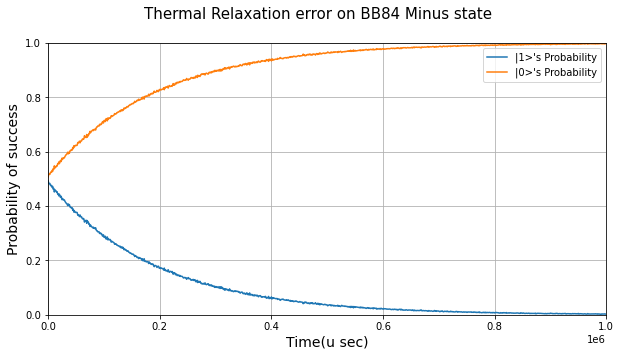

<Figure size 576x360 with 0 Axes>

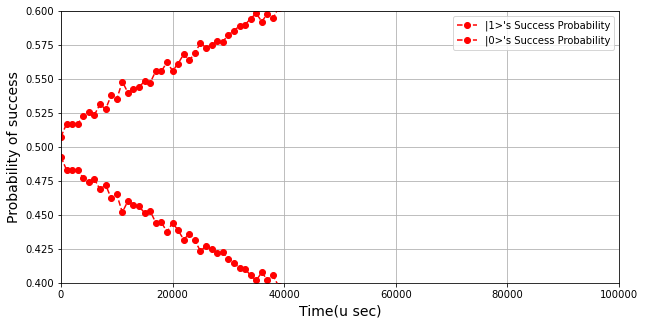

<Figure size 576x360 with 0 Axes>

In [80]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 Minus state',fontsize=15)
# naming the x axis
plt.xlabel('Time(u sec)',fontsize=14)
# naming the y axis
plt.ylabel('Probability of success',fontsize=14)
plt.grid()
# giving a title to my graph
# Set axis ranges; by default this will put major ticks every 25.
#ax.set_xlim(0, 300)
#ax.set_ylim(0, 1)
ax.set_xlim(0, 1000000)
ax.set_ylim(0,1)
fig = plt.figure(figsize=(8,5))
# line 2 points
x1=delay
x2=delay
#plotting the line 2 points
ax.plot(x1, dm1, label = "|1>'s Probability")
ax.plot(x2, dm0, label = "|0>'s Probability")

#ax.axes.xaxis.set_ticks([])
# show a legend on the plot
ax.legend()
########################################################################


%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(0, 100000)
ax.set_ylim(0.4,0.6)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec)',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,dm1,'ro--',label = "|1>'s Success Probability")
ax.plot(delay,dm0,'ro--',label = "|0>'s Success Probability")

ax.legend()

# Delay + gates

In [81]:
import matplotlib.pyplot as plt
success_state0=[]
success_state1=[]

for j in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '4'
    apply_error = {"delay":True, "measure": False, "gate": True}
    success0 = []
    success1 = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success0.append(prob[0])
        success1.append(prob[1])
    success_state0.append(success0)
    success_state1.append(success1)

In [82]:
from statistics import mean
a= success_state0
print(*map(mean, zip(*a)))

0.50045 0.505 0.5024 0.5085500000000001 0.5123 0.5162 0.5142 0.51405 0.5195500000000001 0.52145 0.5311 0.51925 0.53415 0.5298 0.53215 0.5383 0.5383 0.5448000000000001 0.54645 0.5472 0.54895 0.55445 0.55125 0.55865 0.5602 0.56355 0.5667 0.56675 0.5693 0.5691499999999999 0.5763 0.56675 0.5786 0.579 0.5862499999999999 0.5803499999999999 0.5832499999999999 0.58455 0.5916 0.5897 0.5904499999999999 0.5973999999999999 0.5898 0.60425 0.6017 0.60785 0.5993999999999999 0.6114499999999999 0.6093999999999999 0.6054999999999999 0.6053499999999999 0.61855 0.6123999999999999 0.61535 0.62555 0.6259 0.62485 0.6184 0.63115 0.6352 0.6296 0.634 0.6435500000000001 0.6407 0.6452 0.64795 0.6474 0.6478 0.6494 0.65125 0.6516500000000001 0.65425 0.6614 0.65475 0.6521 0.6623 0.6647500000000001 0.6688000000000001 0.6667500000000001 0.66505 0.6706000000000001 0.6678000000000001 0.67595 0.6818500000000001 0.6764 0.6789000000000001 0.6792 0.6841 0.6838500000000001 0.6834 0.6819000000000001 0.6920999999999999 0.68415

In [83]:
from statistics import mean
a= success_state1
print(*map(mean, zip(*a)))

0.49955 0.495 0.4976 0.49145 0.4877 0.4838 0.4858 0.48595 0.48045 0.47855 0.4689 0.48075 0.46585 0.4702 0.46785 0.4617 0.4617 0.4552 0.45355 0.4528 0.45105 0.44555 0.44875 0.44135 0.4398 0.43645 0.4333 0.43325 0.43069999999999997 0.43085 0.4237 0.43325 0.4214 0.421 0.41375 0.41964999999999997 0.41675 0.41545 0.4084 0.4103 0.40955 0.4026 0.4102 0.39575 0.3983 0.39215 0.4006 0.38855 0.3906 0.3945 0.39465 0.38145 0.3876 0.38465 0.37445 0.3741 0.37515 0.3816 0.36885 0.3648 0.3704 0.366 0.35645 0.3593 0.3548 0.35205 0.35259999999999997 0.3522 0.3506 0.34875 0.34835 0.34575 0.3386 0.34525 0.3479 0.3377 0.33525 0.3312 0.33325 0.33495 0.3294 0.3322 0.32405 0.31815 0.3236 0.3211 0.32080000000000003 0.3159 0.31615 0.3166 0.3181 0.3079 0.31585 0.3028 0.31345 0.30345 0.29835 0.30569999999999997 0.30645 0.29435 0.30125 0.29335 0.2896 0.2965 0.2919 0.29535 0.2892 0.28225 0.28115 0.28855 0.28554999999999997 0.28105 0.27885 0.2722 0.28045 0.2786 0.27395 0.2723 0.2683 0.27035000000000003 0.26915 0.264 

In [87]:
#one
dg1=[0.49955,0.495,0.4976,0.49145,0.4877,0.4838,0.4858,0.48595,0.48045,0.47855,0.4689,0.48075,0.46585,0.4702,0.46785,0.4617,0.4617,0.4552,0.45355,0.4528,0.45105,0.44555,0.44875,0.44135,0.4398,0.43645,0.4333,0.43325,0.43069999999999997,0.43085,0.4237,0.43325,0.4214,0.421,0.41375,0.41964999999999997,0.41675,0.41545,0.4084,0.4103,0.40955,0.4026,0.4102,0.39575,0.3983,0.39215,0.4006,0.38855,0.3906,0.3945,0.39465,0.38145,0.3876,0.38465,0.37445,0.3741,0.37515,0.3816,0.36885,0.3648,0.3704,0.366,0.35645,0.3593,0.3548,0.35205,0.35259999999999997,0.3522,0.3506,0.34875,0.34835,0.34575,0.3386,0.34525,0.3479,0.3377,0.33525,0.3312,0.33325,0.33495,0.3294,0.3322,0.32405,0.31815,0.3236,0.3211,0.32080000000000003,0.3159,0.31615,0.3166,0.3181,0.3079,0.31585,0.3028,0.31345,0.30345,0.29835,0.30569999999999997,0.30645,0.29435,0.30125,0.29335,0.2896,0.2965,0.2919,0.29535,0.2892,0.28225,0.28115,0.28855,0.28554999999999997,0.28105,0.27885,0.2722,0.28045,0.2786,0.27395,0.2723,0.2683,0.27035000000000003,0.26915,0.264,0.2677,0.2592,0.26245,0.26480000000000004,0.2616,0.26465,0.2574,0.2559,0.24965,0.2527,0.251,0.2546,0.2565,0.24675,0.252,0.2473,0.24615,0.24675,0.24515,0.2388,0.2358,0.23855,0.2382,0.23365,0.2338,0.23405,0.2316,0.23085,0.23025,0.22425,0.227,0.2259,0.22715,0.2215,0.22675,0.22125,0.2144,0.2231,0.2187,0.21415,0.2121,0.2147,0.2139,0.2126,0.2133,0.21025,0.213,0.208,0.2049,0.20904999999999999,0.21065,0.20685,0.20475,0.2009,0.2005,0.1989,0.1983,0.1979,0.19815,0.1935,0.1985,0.19395,0.1935,0.1926,0.1953,0.1896,0.19485,0.18865,0.18935,0.1834,0.18055,0.18055,0.18195,0.1869,0.18409999999999999,0.18135,0.18115,0.17695,0.17385,0.1771,0.17554999999999998,0.17250000000000001,0.17265,0.17465,0.1738,0.16949999999999998,0.171,0.1677,0.16915,0.16605,0.16485,0.16275,0.1621,0.16225,0.1645,0.1582,0.1638,0.1626,0.15745,0.1562,0.15775,0.15435,0.15765,0.1521,0.15135,0.1549,0.1537,0.1497,0.15665,0.1474,0.14715,0.14835,0.14655,0.1476,0.1481,0.14305,0.14679999999999999,0.1454,0.14835,0.14515,0.14295,0.14,0.1417,0.141,0.1375,0.13985,0.13765,0.1402,0.1376,0.13415,0.13435,0.13735,0.136,0.13205,0.1339,0.13135,0.13005,0.12890000000000001,0.1304,0.1327,0.12855,0.13,0.12785,0.12475,0.12655,0.12835,0.1272,0.1256,0.12090000000000001,0.1188,0.12635,0.12125,0.121,0.1243,0.1196,0.12085,0.11755,0.1163,0.116,0.11755,0.11524999999999999,0.11635,0.1186,0.11765,0.11365,0.1146,0.1093,0.1127,0.10875,0.11305,0.1084,0.1112,0.10965,0.1064,0.1041,0.1078,0.10735,0.10465,0.1093,0.1027,0.1085,0.1038,0.10535,0.10074999999999999,0.10545,0.0998,0.10045,0.1032,0.09915,0.09335,0.0989,0.0986,0.09885,0.10035,0.0953,0.0952,0.0976,0.0938,0.0962,0.09684999999999999,0.09265,0.0919,0.09565,0.09405,0.09245,0.09055,0.09075,0.09055,0.0888,0.0918,0.09075,0.08865,0.0904,0.0861,0.08595,0.0896,0.08895,0.08475,0.0865,0.08445,0.08524999999999999,0.0871,0.0862,0.07965,0.08315,0.08015,0.08545,0.0815,0.08195,0.08015,0.0824,0.0822,0.08035,0.0774,0.07955,0.0782,0.0793,0.07635,0.0766,0.08075,0.07775,0.0734,0.07355,0.07645,0.07755,0.07365,0.0779,0.0735,0.0748,0.0727,0.0725,0.06935,0.0721,0.07205,0.0718,0.074,0.07005,0.06705,0.0708,0.0706,0.0712,0.06665,0.07075000000000001,0.07245,0.0685,0.06785,0.0665,0.0663,0.0697,0.0648,0.06845,0.0663,0.064,0.06455,0.0653,0.06375,0.0603,0.0645,0.0636,0.06105,0.0636,0.06125,0.0593,0.0617,0.06305,0.062,0.0597,0.060450000000000004,0.05955,0.05895,0.0601,0.05805,0.05965,0.058750000000000004,0.05675,0.0572,0.0593,0.05785,0.0552,0.0558,0.05285,0.05505,0.05615,0.05315,0.05485,0.05605,0.05585,0.054,0.0529,0.05095,0.05235,0.0531,0.0514,0.05305,0.052,0.0521,0.05245,0.049,0.0538,0.049049999999999996,0.0532,0.05235,0.0508,0.05135,0.04965,0.0467,0.0479,0.0482,0.05245,0.049999999999999996,0.0468,0.0493,0.04685,0.04545,0.0492,0.04465,0.04745,0.0462,0.0461,0.0448,0.0448,0.04635,0.0465,0.04455,0.04405,0.04265,0.0445,0.0415,0.04305,0.04285,0.046,0.04175,0.04175,0.0413,0.0407,0.0438,0.0399,0.04075,0.0434,0.03955,0.04285,0.0422,0.0414,0.0419,0.04005,0.0411,0.03905,0.03625,0.0401,0.03735,0.036699999999999997,0.03815,0.0394,0.0387,0.03725,0.0361,0.0368,0.0365,0.0351,0.03715,0.03635,0.03455,0.03615,0.038,0.0369,0.03535,0.03445,0.0353,0.0354,0.03505,0.03435,0.0351,0.0369,0.03435,0.0349,0.03705,0.0332,0.03535,0.032,0.0349,0.0316,0.0309,0.0329,0.0328,0.03255,0.03555,0.0326,0.03145,0.0331,0.03355,0.0334,0.031200000000000002,0.0315,0.0315,0.029500000000000002,0.0303,0.03035,0.02945,0.03135,0.0311,0.03125,0.0299,0.03005,0.03155,0.03045,0.02935,0.02835,0.028,0.0294,0.0299,0.03115,0.0288,0.0283,0.0297,0.0268,0.02755,0.02865,0.02785,0.0257,0.0269,0.0271,0.02935,0.0279,0.02655,0.0281,0.026949999999999998,0.025,0.0246,0.0265,0.0267,0.02505,0.0249,0.02655,0.0247,0.02725,0.024,0.0256,0.0262,0.026,0.024650000000000002,0.024900000000000002,0.0242,0.0267,0.02385,0.0237,0.02645,0.02425,0.023799999999999998,0.0233,0.0224,0.02335,0.0234,0.0235,0.02315,0.0231,0.023200000000000002,0.0242,0.02325,0.022949999999999998,0.0233,0.0229,0.02115,0.02095,0.02335,0.02175,0.02165,0.0203,0.0195,0.02035,0.0216,0.020399999999999998,0.020649999999999998,0.0189,0.02205,0.0203,0.019450000000000002,0.01965,0.0208,0.0198,0.0195,0.02075,0.021500000000000002,0.02015,0.01935,0.0189,0.0173,0.01795,0.0191,0.01895,0.0203,0.01895,0.0178,0.0185,0.0196,0.0169,0.01795,0.0196,0.017499999999999998,0.01725,0.019,0.01705,0.01945,0.01845,0.01615,0.01745,0.018,0.01705,0.01685,0.0186,0.0177,0.01745,0.01605,0.01685,0.01745,0.01895,0.01665,0.01555,0.0168,0.016649999999999998,0.016,0.01795,0.01615,0.01525,0.01595,0.0157,0.01485,0.01675,0.01685,0.01535,0.0162,0.01585,0.01525,0.01395,0.0148,0.0165,0.01535,0.0135,0.01585,0.01465,0.0146,0.01385,0.01435,0.01535,0.01315,0.01445,0.01345,0.0152,0.01565,0.01285,0.0143,0.013049999999999999,0.01385,0.0143,0.011899999999999999,0.0135,0.015,0.01425,0.01425,0.01265,0.0135,0.0144,0.01325,0.0131,0.0116,0.01285,0.0138,0.0137,0.01215,0.01265,0.0131,0.011899999999999999,0.0121,0.01125,0.01115,0.01335,0.0111,0.01185,0.01145,0.0124,0.0129,0.0121,0.0139,0.01125,0.0114,0.0109,0.0107,0.01315,0.01315,0.0132,0.0105,0.01195,0.0115,0.01055,0.0103,0.01065,0.0114,0.0095,0.0111,0.01185,0.00955,0.0115,0.0111,0.01015,0.01015,0.0096,0.0104,0.00985,0.01175,0.0111,0.01045,0.01065,0.0121,0.01095,0.0112,0.0106,0.0093,0.01005,0.01005,0.0091,0.0093,0.00955,0.0091,0.009,0.0105,0.0104,0.00895,0.00895,0.0084,0.009,0.01125,0.0106,0.0096,0.0106,0.0093,0.00805,0.00945,0.00985,0.0086,0.00785,0.00985,0.0077,0.00815,0.00775,0.0079,0.0085,0.0091,0.00805,0.00895,0.0074,0.00795,0.0079,0.008,0.00885,0.0088,0.00785,0.0078,0.008,0.00785,0.0099,0.0074,0.00795,0.00755,0.00865,0.0079,0.0075,0.00745,0.00735,0.00775,0.0074,0.0072,0.00895,0.00735,0.0067,0.00695,0.0076,0.0071,0.00755,0.00715,0.0074,0.0072,0.0074,0.0072,0.00735,0.00715,0.00715,0.0073,0.006,0.0055,0.0068,0.0065,0.0066500000000000005,0.00775,0.00785,0.00625,0.00585,0.0073999999999999995,0.00785,0.0071,0.0076,0.00615,0.00595,0.0063,0.00695,0.0064,0.0065,0.0071,0.00685,0.00575,0.006,0.00575,0.0057,0.00635,0.006,0.0061,0.00575,0.00625,0.0064,0.0061,0.00625,0.0057,0.00595,0.00515,0.0062,0.0051,0.00505,0.0067,0.00625,0.00445,0.00425,0.00575,0.00545,0.005,0.0054,0.00555,0.00475,0.0047,0.0067,0.0048000000000000004,0.0045000000000000005,0.0055,0.0054,0.00505,0.0053,0.00475,0.0047,0.00525,0.00505,0.0051,0.005,0.0049,0.00445,0.0046,0.0052,0.00495,0.00505,0.0049,0.00505,0.0052,0.0041,0.0044,0.0038,0.0048000000000000004,0.0042,0.00445,0.00435,0.00465,0.0045000000000000005,0.0056,0.00495,0.00485,0.004,0.00425,0.0049,0.0048000000000000004,0.0042,0.0051,0.00425,0.00385,0.0052,0.00485,0.00395,0.0033,0.00375,0.00365,0.00335,0.0039,0.00385,0.0043,0.0035,0.0036,0.0035,0.0026,0.0035,0.00385,0.00295,0.0046500000000000005,0.00405,0.00445,0.0044,0.00405,0.00365,0.0035,0.0032,0.004,0.0037,0.00405,0.0031,0.0036,0.0036,0.0035,0.00415,0.0039000000000000003,0.00385,0.0032500000000000003,0.0034000000000000002,0.00305,0.00285,0.003,0.0035,0.00345,0.0035,0.00345,0.00345,0.0037,0.0029000000000000002,0.0035,0.00285,0.0028,0.00345,0.00345,0.00425,0.0036,0.003,0.0035,0.00315,0.0035,0.0033,0.0031,0.00335,0.0032,0.0025,0.0036,0.0028,0.00235,0.00355,0.00365,0.0031,0.0034000000000000002,0.00355,0.00315,0.00265,0.0022500000000000003,0.0019,0.0022500000000000003,0.00315,0.0029000000000000002,0.0028,0.00235,0.00245]

In [88]:
#Zero
dg0=[0.50045,0.505,0.5024,0.5085500000000001,0.5123,0.5162,0.5142,0.51405,0.5195500000000001,0.52145,0.5311,0.51925,0.53415,0.5298,0.53215,0.5383,0.5383,0.5448000000000001,0.54645,0.5472,0.54895,0.55445,0.55125,0.55865,0.5602,0.56355,0.5667,0.56675,0.5693,0.5691499999999999,0.5763,0.56675,0.5786,0.579,0.5862499999999999,0.5803499999999999,0.5832499999999999,0.58455,0.5916,0.5897,0.5904499999999999,0.5973999999999999,0.5898,0.60425,0.6017,0.60785,0.5993999999999999,0.6114499999999999,0.6093999999999999,0.6054999999999999,0.6053499999999999,0.61855,0.6123999999999999,0.61535,0.62555,0.6259,0.62485,0.6184,0.63115,0.6352,0.6296,0.634,0.6435500000000001,0.6407,0.6452,0.64795,0.6474,0.6478,0.6494,0.65125,0.6516500000000001,0.65425,0.6614,0.65475,0.6521,0.6623,0.6647500000000001,0.6688000000000001,0.6667500000000001,0.66505,0.6706000000000001,0.6678000000000001,0.67595,0.6818500000000001,0.6764,0.6789000000000001,0.6792,0.6841,0.6838500000000001,0.6834,0.6819000000000001,0.6920999999999999,0.68415,0.6971999999999999,0.68655,0.69655,0.70165,0.6943,0.69355,0.70565,0.69875,0.70665,0.7103999999999999,0.7035,0.7081,0.70465,0.7108,0.71775,0.71885,0.7114499999999999,0.7144499999999999,0.71895,0.72115,0.7278,0.71955,0.7213999999999999,0.72605,0.7277,0.7317,0.72965,0.73085,0.736,0.7323,0.7408,0.73755,0.7352,0.7384,0.73535,0.7426,0.7441,0.75035,0.7473,0.749,0.7454,0.7435,0.75325,0.748,0.7527,0.75385,0.75325,0.75485,0.7612,0.7642,0.76145,0.7618,0.76635,0.7662,0.76595,0.7684,0.76915,0.76975,0.77575,0.773,0.7741,0.77285,0.7785,0.77325,0.77875,0.7856000000000001,0.7769,0.7813,0.78585,0.7879,0.7853,0.7861,0.7874,0.7867000000000001,0.7897500000000001,0.787,0.792,0.7951,0.79095,0.78935,0.79315,0.79525,0.7991,0.7995,0.8011,0.8017000000000001,0.8021,0.8018500000000001,0.8065,0.8015,0.80605,0.8065,0.8074,0.8047,0.8104,0.80515,0.81135,0.81065,0.8166,0.81945,0.81945,0.8180499999999999,0.8130999999999999,0.8159,0.81865,0.81885,0.82305,0.8261499999999999,0.8229,0.82445,0.8275,0.8273499999999999,0.82535,0.8261999999999999,0.8305,0.829,0.8322999999999999,0.83085,0.83395,0.83515,0.8372499999999999,0.8379,0.83775,0.8354999999999999,0.8418,0.8361999999999999,0.8373999999999999,0.84255,0.8438,0.8422499999999999,0.84565,0.8423499999999999,0.8479,0.84865,0.8451,0.8462999999999999,0.8503,0.8433499999999999,0.8526,0.85285,0.85165,0.8534499999999999,0.8523999999999999,0.8519,0.85695,0.8532,0.8546,0.85165,0.85485,0.85705,0.86,0.8583,0.859,0.8625,0.86015,0.86235,0.8598,0.8623999999999999,0.86585,0.86565,0.86265,0.864,0.86795,0.8661,0.86865,0.86995,0.8711,0.8696,0.8673,0.87145,0.87,0.87215,0.87525,0.87345,0.87165,0.8728,0.8744,0.8791,0.8812,0.87365,0.87875,0.879,0.8757,0.8804,0.87915,0.88245,0.8837,0.884,0.88245,0.88475,0.88365,0.8814,0.88235,0.88635,0.8854,0.8907,0.8873,0.89125,0.88695,0.8916000000000001,0.8888,0.89035,0.8936000000000001,0.8959,0.8922,0.89265,0.89535,0.8907,0.8973,0.8915,0.8962,0.8946500000000001,0.89925,0.8945500000000001,0.9002,0.8995500000000001,0.8968,0.90085,0.9066500000000001,0.9011,0.9014,0.90115,0.8996500000000001,0.9047000000000001,0.9048,0.9024,0.9062,0.9038,0.90315,0.90735,0.9081,0.90435,0.90595,0.9075500000000001,0.90945,0.90925,0.90945,0.9112,0.9082,0.90925,0.91135,0.9096000000000001,0.9139,0.91405,0.9104,0.91105,0.91525,0.9135,0.9155500000000001,0.9147500000000001,0.9129,0.9138000000000001,0.92035,0.91685,0.9198500000000001,0.91455,0.9185,0.91805,0.9198500000000001,0.9176000000000001,0.9178000000000001,0.9196500000000001,0.9226000000000001,0.92045,0.9218000000000001,0.9207000000000001,0.9236500000000001,0.9234,0.91925,0.92225,0.9266000000000001,0.92645,0.9235500000000001,0.92245,0.92635,0.9221,0.9265,0.9252,0.9273,0.9275,0.93065,0.9279000000000001,0.92795,0.9282,0.926,0.92995,0.9329500000000001,0.9292,0.9294,0.9288000000000001,0.93335,0.92925,0.92755,0.9315,0.93215,0.9335,0.9337,0.9303,0.9352,0.93155,0.9337,0.936,0.93545,0.9347,0.93625,0.9397,0.9355,0.9364,0.93895,0.9364,0.93875,0.9407,0.9383,0.93695,0.938,0.9403,0.93955,0.94045,0.9410499999999999,0.9399,0.94195,0.94035,0.94125,0.94325,0.9428,0.9407,0.9421499999999999,0.9448,0.9441999999999999,0.9471499999999999,0.94495,0.94385,0.94685,0.9451499999999999,0.94395,0.9441499999999999,0.946,0.9470999999999999,0.94905,0.94765,0.9469,0.9486,0.94695,0.948,0.9479,0.94755,0.951,0.9461999999999999,0.95095,0.9468,0.94765,0.9491999999999999,0.94865,0.9503499999999999,0.9532999999999999,0.9521,0.9518,0.94755,0.95,0.9531999999999999,0.9507,0.9531499999999999,0.95455,0.9508,0.9553499999999999,0.95255,0.9538,0.9539,0.9551999999999999,0.9551999999999999,0.95365,0.9535,0.9554499999999999,0.95595,0.9573499999999999,0.9555,0.9584999999999999,0.95695,0.95715,0.954,0.9582499999999999,0.9582499999999999,0.9587,0.9592999999999999,0.9561999999999999,0.9601,0.9592499999999999,0.9566,0.9604499999999999,0.95715,0.9578,0.9586,0.9581,0.95995,0.9589,0.96095,0.96375,0.9599,0.96265,0.9632999999999999,0.96185,0.9606,0.9612999999999999,0.96275,0.9639,0.9632,0.9635,0.9649,0.96285,0.96365,0.9654499999999999,0.96385,0.962,0.9631,0.96465,0.96555,0.9647,0.9646,0.96495,0.96565,0.9649,0.9631,0.96565,0.9651,0.96295,0.9668,0.96465,0.968,0.9651,0.9683999999999999,0.9691,0.9671,0.9672,0.9674499999999999,0.9644499999999999,0.9673999999999999,0.96855,0.9669,0.9664499999999999,0.9666,0.9688,0.9684999999999999,0.9684999999999999,0.9704999999999999,0.9697,0.96965,0.97055,0.96865,0.9689,0.96875,0.9701,0.96995,0.9684499999999999,0.96955,0.97065,0.97165,0.972,0.9706,0.9701,0.96885,0.9712,0.9717,0.9702999999999999,0.9732,0.9724499999999999,0.9713499999999999,0.97215,0.9742999999999999,0.9731,0.9729,0.97065,0.9721,0.9734499999999999,0.9719,0.97305,0.975,0.9753999999999999,0.9735,0.9732999999999999,0.97495,0.9751,0.9734499999999999,0.9753,0.97275,0.976,0.9743999999999999,0.9738,0.974,0.9753499999999999,0.9751,0.9758,0.9732999999999999,0.97615,0.9763,0.97355,0.97575,0.9762,0.9767,0.9776,0.97665,0.9766,0.9764999999999999,0.97685,0.9769,0.9768,0.9758,0.97675,0.97705,0.9767,0.9771,0.97885,0.97905,0.97665,0.97825,0.9783499999999999,0.9797,0.9804999999999999,0.97965,0.9783999999999999,0.9796,0.9793499999999999,0.9811,0.97795,0.9797,0.98055,0.9803499999999999,0.9792,0.9802,0.9804999999999999,0.97925,0.9784999999999999,0.97985,0.98065,0.9811,0.9827,0.98205,0.9809,0.98105,0.9797,0.98105,0.9822,0.9815,0.9803999999999999,0.9831,0.98205,0.9803999999999999,0.9824999999999999,0.98275,0.981,0.98295,0.98055,0.98155,0.98385,0.98255,0.982,0.98295,0.98315,0.9813999999999999,0.9823,0.98255,0.98395,0.98315,0.98255,0.98105,0.98335,0.9844499999999999,0.9832,0.98335,0.984,0.98205,0.98385,0.98475,0.98405,0.9843,0.98515,0.98325,0.98315,0.98465,0.9838,0.98415,0.98475,0.98605,0.9852,0.9835,0.98465,0.9864999999999999,0.98415,0.98535,0.9853999999999999,0.98615,0.98565,0.98465,0.98685,0.98555,0.98655,0.9848,0.98435,0.98715,0.9857,0.98695,0.98615,0.9857,0.9881,0.9864999999999999,0.985,0.98575,0.98575,0.98735,0.9864999999999999,0.9856,0.98675,0.9869,0.9884,0.98715,0.9862,0.9863,0.98785,0.98735,0.9869,0.9881,0.9879,0.98875,0.98885,0.98665,0.9889,0.98815,0.98855,0.9876,0.9871,0.9879,0.9861,0.98875,0.9886,0.9891,0.9893,0.98685,0.98685,0.9868,0.9895,0.98805,0.9884999999999999,0.9894499999999999,0.9897,0.98935,0.9886,0.9904999999999999,0.9889,0.98815,0.9904499999999999,0.9884999999999999,0.9889,0.98985,0.98985,0.9904,0.9896,0.99015,0.98825,0.9889,0.98955,0.98935,0.9879,0.98905,0.9888,0.9894,0.9907,0.98995,0.98995,0.9909,0.9907,0.9904499999999999,0.9909,0.991,0.9895,0.9896,0.99105,0.99105,0.9916,0.991,0.98875,0.9894,0.9904,0.9894,0.9907,0.99195,0.99055,0.99015,0.9914,0.99215,0.99015,0.9923,0.99185,0.99225,0.9921,0.9915,0.9909,0.99195,0.99105,0.9926,0.99205,0.9921,0.992,0.99115,0.9912,0.99215,0.9922,0.992,0.99215,0.9901,0.9926,0.99205,0.9924499999999999,0.99135,0.9921,0.9924999999999999,0.99255,0.99265,0.99225,0.9926,0.9928,0.99105,0.99265,0.9933,0.99305,0.9924,0.9929,0.9924499999999999,0.99285,0.9926,0.9928,0.9926,0.9928,0.99265,0.99285,0.99285,0.9927,0.994,0.9944999999999999,0.9932,0.9935,0.99335,0.99225,0.99215,0.99375,0.99415,0.9926,0.99215,0.9929,0.9924,0.99385,0.99405,0.9937,0.99305,0.9936,0.9935,0.9929,0.99315,0.99425,0.994,0.99425,0.9943,0.99365,0.994,0.9939,0.99425,0.99375,0.9936,0.9939,0.99375,0.9943,0.99405,0.99485,0.9938,0.9949,0.99495,0.9933,0.99375,0.99555,0.99575,0.99425,0.99455,0.995,0.9946,0.99445,0.99525,0.9953,0.9933,0.9952,0.9955,0.9944999999999999,0.9946,0.99495,0.9947,0.99525,0.9953,0.99475,0.99495,0.9949,0.995,0.9951,0.99555,0.9954,0.9948,0.99505,0.99495,0.9951,0.99495,0.9948,0.9959,0.9956,0.9962,0.9952,0.9958,0.99555,0.99565,0.99535,0.9955,0.9944,0.99505,0.99515,0.996,0.99575,0.9951,0.9952,0.9958,0.9949,0.99575,0.99615,0.9948,0.99515,0.99605,0.9967,0.99625,0.99635,0.99665,0.9961,0.99615,0.9957,0.9964999999999999,0.9964,0.9964999999999999,0.9974,0.9964999999999999,0.99615,0.99705,0.99535,0.99595,0.99555,0.9956,0.99595,0.99635,0.9964999999999999,0.9968,0.996,0.9963,0.99595,0.9969,0.9964,0.9964,0.9964999999999999,0.99585,0.9961,0.99615,0.99675,0.9966,0.99695,0.99715,0.997,0.9964999999999999,0.99655,0.9964999999999999,0.99655,0.99655,0.9963,0.9971,0.9964999999999999,0.99715,0.9972,0.99655,0.99655,0.99575,0.9964,0.997,0.9964999999999999,0.99685,0.9964999999999999,0.9967,0.9969,0.99665,0.9968,0.9975,0.9964,0.9972,0.99765,0.99645,0.99635,0.9969,0.9966,0.99645,0.99685,0.99735,0.99775,0.9981,0.99775,0.99685,0.9971,0.9972,0.99765,0.99755]

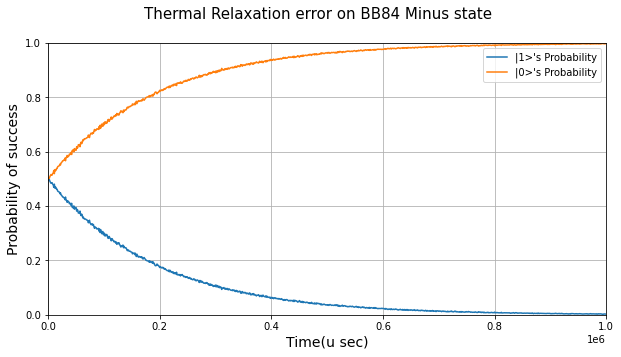

<Figure size 576x360 with 0 Axes>

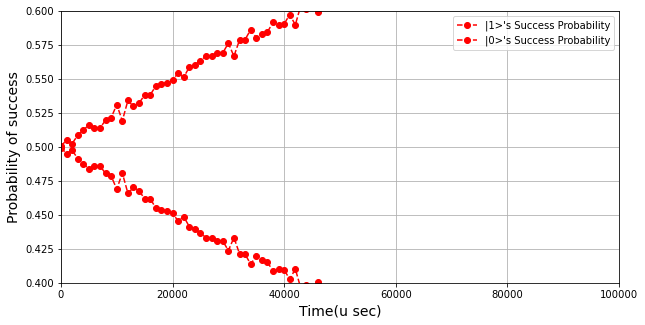

<Figure size 576x360 with 0 Axes>

In [89]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 Minus state',fontsize=15)
# naming the x axis
plt.xlabel('Time(u sec)',fontsize=14)
# naming the y axis
plt.ylabel('Probability of success',fontsize=14)
plt.grid()
# giving a title to my graph
# Set axis ranges; by default this will put major ticks every 25.
#ax.set_xlim(0, 300)
#ax.set_ylim(0, 1)
ax.set_xlim(0, 1000000)
ax.set_ylim(0,1)
fig = plt.figure(figsize=(8,5))
# line 2 points
x1=delay
x2=delay
#plotting the line 2 points
ax.plot(x1, dg1, label = "|1>'s Probability")
ax.plot(x2, dg0, label = "|0>'s Probability")

#ax.axes.xaxis.set_ticks([])
# show a legend on the plot
ax.legend()
########################################################################


%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(0, 100000)
ax.set_ylim(0.4,0.6)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec)',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,dg1,'ro--',label = "|1>'s Success Probability")
ax.plot(delay,dg0,'ro--',label = "|0>'s Success Probability")

ax.legend()

# Delay + measurement + gates

In [55]:
import matplotlib.pyplot as plt
success_state0=[]
success_state1=[]

for j in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '4'
    apply_error = {"delay":True, "measure": True, "gate": True}
    success0 = []
    success1 = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success0.append(prob[0])
        success1.append(prob[1])
    success_state0.append(success0)
    success_state1.append(success1)

In [56]:
from statistics import mean
a= success_state0
print(*map(mean, zip(*a)))

0.5178 0.51605 0.5173 0.5213 0.53005 0.5215000000000001 0.523 0.53005 0.5325 0.53615 0.5399 0.5385 0.5422 0.5427000000000001 0.5435 0.552 0.5445500000000001 0.55505 0.55455 0.56345 0.55805 0.56045 0.5648 0.56735 0.5694 0.5789 0.57675 0.57 0.57955 0.57775 0.57845 0.58815 0.5887 0.58355 0.5952999999999999 0.5943999999999999 0.60155 0.5924499999999999 0.60835 0.601 0.604 0.60805 0.61525 0.60915 0.61055 0.6164 0.61565 0.6234999999999999 0.6201 0.6214 0.62065 0.6227 0.62715 0.6381 0.6238 0.6348 0.6353 0.6372 0.63905 0.6374 0.6449 0.6465000000000001 0.64375 0.647 0.6493 0.64785 0.65275 0.6545500000000001 0.65445 0.6602 0.6567500000000001 0.6549 0.66425 0.6707000000000001 0.6655 0.669 0.6714 0.67365 0.6752 0.68285 0.6803 0.6802 0.68475 0.68175 0.6986 0.6862 0.6882 0.68715 0.6911 0.69645 0.69285 0.6962 0.6980999999999999 0.6999 0.70205 0.70305 0.7028 0.7027 0.7054 0.7165 0.71185 0.7119 0.71665 0.7176 0.71375 0.7145 0.71565 0.72055 0.72225 0.7213999999999999 0.7253499999999999 0.7278 0.73055 0.

In [57]:
from statistics import mean
a= success_state1
print(*map(mean, zip(*a)))

0.4822 0.48395 0.4827 0.4787 0.46995 0.4785 0.477 0.46995 0.4675 0.46385 0.4601 0.4615 0.4578 0.4573 0.4565 0.448 0.45545 0.44495 0.44545 0.43655 0.44195 0.43955 0.4352 0.43265 0.4306 0.4211 0.42325 0.43 0.42045 0.42225 0.42155 0.41185 0.4113 0.41645 0.4047 0.4056 0.39845 0.40755 0.39165 0.399 0.396 0.39195 0.38475 0.39085000000000003 0.38945 0.3836 0.38435 0.3765 0.3799 0.3786 0.37935 0.3773 0.37285 0.3619 0.3762 0.36519999999999997 0.3647 0.3628 0.36095 0.3626 0.35509999999999997 0.3535 0.35625 0.353 0.3507 0.35215 0.34725 0.34545 0.34555 0.3398 0.34325 0.3451 0.33575 0.3293 0.3345 0.331 0.3286 0.32635000000000003 0.32480000000000003 0.31715 0.3197 0.31980000000000003 0.31525000000000003 0.31825 0.3014 0.3138 0.3118 0.31285 0.3089 0.30355 0.30715 0.3038 0.3019 0.3001 0.29795 0.29695 0.2972 0.2973 0.2946 0.2835 0.28815 0.2881 0.28335 0.2824 0.28625 0.2855 0.28435 0.27945 0.27775 0.2786 0.27465 0.2722 0.26945 0.2679 0.26645 0.2691 0.2677 0.27040000000000003 0.2647 0.26525 0.26940000000

In [84]:
dmg1=[0.4822,0.48395,0.4827,0.4787,0.46995,0.4785,0.477,0.46995,0.4675,0.46385,0.4601,0.4615,0.4578,0.4573,0.4565,0.448,0.45545,0.44495,0.44545,0.43655,0.44195,0.43955,0.4352,0.43265,0.4306,0.4211,0.42325,0.43,0.42045,0.42225,0.42155,0.41185,0.4113,0.41645,0.4047,0.4056,0.39845,0.40755,0.39165,0.399,0.396,0.39195,0.38475,0.39085000000000003,0.38945,0.3836,0.38435,0.3765,0.3799,0.3786,0.37935,0.3773,0.37285,0.3619,0.3762,0.36519999999999997,0.3647,0.3628,0.36095,0.3626,0.35509999999999997,0.3535,0.35625,0.353,0.3507,0.35215,0.34725,0.34545,0.34555,0.3398,0.34325,0.3451,0.33575,0.3293,0.3345,0.331,0.3286,0.32635000000000003,0.32480000000000003,0.31715,0.3197,0.31980000000000003,0.31525000000000003,0.31825,0.3014,0.3138,0.3118,0.31285,0.3089,0.30355,0.30715,0.3038,0.3019,0.3001,0.29795,0.29695,0.2972,0.2973,0.2946,0.2835,0.28815,0.2881,0.28335,0.2824,0.28625,0.2855,0.28435,0.27945,0.27775,0.2786,0.27465,0.2722,0.26945,0.2679,0.26645,0.2691,0.2677,0.27040000000000003,0.2647,0.26525,0.26940000000000003,0.26695,0.26415,0.2537,0.25680000000000003,0.26115,0.25335,0.2503,0.2502,0.25345,0.25645,0.2385,0.24745,0.2457,0.24855,0.24165,0.24405,0.2396,0.24355,0.24045,0.2339,0.234,0.2386,0.23215,0.2315,0.2307,0.22915,0.22885,0.22125,0.22775,0.22625,0.22415,0.2219,0.2216,0.22045,0.22205,0.21795,0.2122,0.21235,0.2158,0.2112,0.20765,0.21075,0.20829999999999999,0.2111,0.21015,0.20675,0.20515,0.2057,0.2007,0.2022,0.2034,0.1993,0.19935,0.2034,0.20025,0.1939,0.1918,0.19745000000000001,0.19205,0.19205,0.19090000000000001,0.19335,0.18765,0.1905,0.1878,0.18295,0.18645,0.18625,0.18555,0.1802,0.181,0.1825,0.17475,0.1802,0.17795,0.1779,0.18125,0.1728,0.1771,0.1739,0.17355,0.17315,0.17115,0.1711,0.17075,0.1674,0.17024999999999998,0.1706,0.1649,0.1686,0.16295,0.165,0.1602,0.16635,0.15395,0.1555,0.14965,0.15715,0.1575,0.1561,0.15545,0.15505,0.151,0.1521,0.15045,0.1521,0.15545,0.1484,0.14865,0.1474,0.14175000000000001,0.1441,0.14505,0.14425,0.1452,0.1433,0.14345,0.1459,0.13915,0.142,0.13845,0.13785,0.14045,0.14195,0.135,0.1393,0.13275,0.13435,0.1341,0.13225,0.1325,0.12865000000000001,0.13365,0.12975,0.13045,0.1299,0.1298,0.12825,0.12875,0.126,0.12665,0.12245,0.12535,0.12085,0.12355000000000001,0.12285,0.11955,0.12255,0.11995,0.11785,0.11985,0.11995,0.11675,0.11655,0.11775000000000001,0.11845,0.11915,0.1132,0.1171,0.11475,0.1154,0.11435000000000001,0.11215,0.1148,0.1121,0.1097,0.1095,0.111,0.11045,0.10545,0.1097,0.1072,0.10585,0.10535,0.1075,0.1074,0.1029,0.10295,0.10475,0.10105,0.1027,0.10345,0.1043,0.1031,0.1012,0.09935,0.09935,0.09855,0.0975,0.09845,0.0955,0.10065,0.09755,0.0933,0.097,0.09865,0.0946,0.0947,0.09215,0.09675,0.0921,0.09195,0.0915,0.09145,0.0903,0.09305,0.0909,0.0883,0.0928,0.09145,0.08955,0.0852,0.08925,0.09005,0.0832,0.0837,0.08475,0.08485,0.08295,0.08645,0.08515,0.08155,0.08475,0.08205,0.08209999999999999,0.0807,0.07995000000000001,0.08085,0.08215,0.08105,0.0813,0.07855,0.0798,0.08235,0.08155,0.0801,0.07725,0.0767,0.07475,0.0737,0.0726,0.07305,0.0746,0.07565,0.07495,0.06965,0.0719,0.0712,0.0708,0.07135,0.0707,0.07175000000000001,0.0731,0.0701,0.0684,0.06995,0.0693,0.067,0.0698,0.06760000000000001,0.0673,0.0692,0.0691,0.0659,0.0673,0.06835000000000001,0.0644,0.0663,0.0637,0.0627,0.06715,0.06335,0.06435,0.061,0.0636,0.06065,0.06375,0.060450000000000004,0.0625,0.060700000000000004,0.0641,0.0616,0.0589,0.0627,0.05775,0.05935,0.05935,0.0591,0.05835,0.058,0.05795,0.057550000000000004,0.0568,0.05655,0.055,0.0585,0.05795,0.05955,0.0562,0.0563,0.05475,0.05475,0.0543,0.0561,0.05405,0.0529,0.0519,0.05535,0.0527,0.0524,0.0519,0.0551,0.04805,0.05125,0.051000000000000004,0.052,0.0498,0.05205,0.04985,0.0495,0.0495,0.0464,0.04835,0.04825,0.04875,0.04705,0.04495,0.0466,0.04625,0.04725,0.04525,0.047850000000000004,0.04645,0.0465,0.0465,0.04325,0.0477,0.04655,0.04435,0.04635,0.0444,0.04635,0.04385,0.042499999999999996,0.04395,0.0436,0.04335,0.0424,0.04165,0.04215,0.04215,0.041049999999999996,0.039,0.04135,0.04075,0.03935,0.04105,0.04005,0.04145,0.0414,0.04095,0.0416,0.0404,0.0408,0.03765,0.0388,0.04015,0.0378,0.03825,0.0391,0.03835,0.03655,0.03925,0.0381,0.0368,0.03865,0.0373,0.0346,0.0363,0.0365,0.03625,0.0373,0.035500000000000004,0.039,0.035,0.0368,0.0379,0.0375,0.035,0.0317,0.0343,0.03455,0.0323,0.03515,0.034,0.0333,0.03545,0.03365,0.03275,0.0318,0.03285,0.03545,0.03205,0.032600000000000004,0.03255,0.0335,0.0302,0.0332,0.0318,0.03245,0.03095,0.03025,0.0305,0.0298,0.03275,0.03025,0.0295,0.0305,0.03005,0.0305,0.03095,0.0308,0.03,0.029,0.03115,0.0288,0.02965,0.0269,0.0298,0.023799999999999998,0.0287,0.0287,0.028050000000000002,0.02695,0.02945,0.02485,0.02705,0.02735,0.02535,0.0261,0.02685,0.02855,0.02575,0.02415,0.02575,0.02635,0.02715,0.02615,0.02505,0.02725,0.02445,0.0264,0.02475,0.02585,0.0247,0.023,0.0245,0.02455,0.02255,0.02425,0.0235,0.0236,0.02305,0.0246,0.0222,0.0233,0.0227,0.02335,0.02215,0.0231,0.02215,0.02265,0.0224,0.022600000000000002,0.02255,0.0231,0.022699999999999998,0.02135,0.02255,0.0237,0.0221,0.020900000000000002,0.02155,0.0214,0.0216,0.0214,0.019549999999999998,0.0211,0.0209,0.02215,0.02025,0.02045,0.02125,0.0207,0.022099999999999998,0.01855,0.0199,0.01885,0.0185,0.0205,0.019450000000000002,0.0195,0.01885,0.01745,0.01885,0.01785,0.01915,0.0182,0.0188,0.01985,0.0186,0.018099999999999998,0.02005,0.01895,0.01745,0.0191,0.01825,0.01795,0.0161,0.0191,0.0188,0.01735,0.01525,0.017499999999999998,0.0162,0.0162,0.0154,0.01905,0.018349999999999998,0.0159,0.01825,0.0162,0.0168,0.01755,0.01485,0.01655,0.0154,0.0176,0.01585,0.0149,0.01535,0.01765,0.01655,0.0161,0.014,0.01465,0.01435,0.0148,0.0147,0.0147,0.0176,0.0152,0.01375,0.0148,0.01425,0.01465,0.0143,0.01385,0.01335,0.01355,0.0127,0.0146,0.0139,0.0136,0.013,0.01275,0.01405,0.0143,0.0142,0.0131,0.0148,0.01295,0.01305,0.0134,0.01195,0.0113,0.0132,0.0118,0.01295,0.01185,0.01315,0.0132,0.0136,0.0121,0.0137,0.01205,0.0123,0.0123,0.01325,0.01235,0.011899999999999999,0.0131,0.0124,0.01175,0.01195,0.01295,0.01275,0.01245,0.0112,0.0112,0.012,0.0118,0.01135,0.0117,0.01205,0.01155,0.01195,0.01095,0.0109,0.01155,0.01045,0.01045,0.0105,0.01165,0.0106,0.0105,0.0108,0.0096,0.01095,0.01125,0.0105,0.01085,0.01065,0.009600000000000001,0.01035,0.01025,0.01045,0.00925,0.0113,0.00995,0.0104,0.0103,0.0097,0.0102,0.00895,0.0102,0.01005,0.00915,0.00975,0.01065,0.0093,0.01005,0.00875,0.00965,0.0106,0.00815,0.0103,0.0097,0.00945,0.0098,0.0096,0.008749999999999999,0.0097,0.00835,0.00915,0.0085,0.00915,0.0091,0.0078,0.0081,0.0079,0.00775,0.0087,0.00725,0.008,0.0081,0.008749999999999999,0.0079,0.00835,0.00695,0.0089,0.00805,0.0077,0.00725,0.00765,0.00685,0.00925,0.00855,0.0079,0.0078000000000000005,0.00775,0.00865,0.0077,0.0072499999999999995,0.0072,0.0074,0.00805,0.007,0.0070999999999999995,0.00695,0.00775,0.007,0.0065,0.00665,0.0071,0.00735,0.00745,0.0075,0.007,0.0064,0.0066,0.00745,0.00665,0.00715,0.00675,0.00665,0.00615,0.00615,0.007,0.00655,0.00685,0.00655,0.0074,0.0072,0.0072,0.0061,0.0066,0.00645,0.00685,0.00585,0.0053,0.00625,0.0063,0.0066,0.0069,0.0059,0.0063,0.00605,0.0065,0.00595,0.006,0.00575,0.00645,0.0062,0.0055,0.00505,0.0072,0.006,0.00535,0.0056,0.0063,0.00515,0.0045000000000000005,0.00525,0.00545,0.0053,0.006,0.00525,0.00495,0.0051,0.00445,0.006,0.00515,0.00525,0.0045000000000000005,0.00545,0.0051,0.00545,0.0062,0.0056,0.0049,0.00465,0.00505,0.00495,0.00515,0.00595,0.00445,0.00445,0.00435,0.005,0.0046,0.00495,0.0054,0.0046500000000000005,0.0046,0.0045000000000000005,0.0052,0.00415,0.0042,0.00535,0.0051,0.00335,0.00395,0.0046,0.0046,0.0047,0.00485,0.0039000000000000003,0.0035,0.00425,0.0044,0.0046,0.0034000000000000002,0.0037,0.0045000000000000005,0.00475,0.00445,0.0032,0.0035,0.00365,0.00345,0.0042,0.004,0.00495,0.00465,0.0038,0.004,0.00425,0.00405,0.00405,0.00385,0.00385,0.0032,0.0047,0.0036,0.00395,0.00365,0.00365,0.00375,0.004,0.004,0.00365,0.00365,0.0037,0.0036,0.0036,0.0033,0.004,0.0034000000000000002,0.00355,0.00435,0.0033,0.00285,0.0031,0.00365,0.00335,0.0033,0.00295,0.0032500000000000003,0.00425,0.0037,0.00365,0.0041,0.0034000000000000002,0.00275,0.00345,0.003,0.00375,0.00375,0.00285,0.0028,0.00285,0.003,0.0037,0.00375,0.00425,0.0022500000000000003,0.0031,0.00355,0.00335,0.00285,0.0032500000000000003,0.0034000000000000002,0.00265,0.00205,0.00295,0.0028,0.0034000000000000002,0.0033,0.00285,0.0026,0.0025,0.00265,0.0029000000000000002,0.00315,0.00235,0.003,0.0035,0.00285,0.0022500000000000003]
#one

In [85]:
dmg0=[0.5178,0.51605,0.5173,0.5213,0.53005,0.5215000000000001,0.523,0.53005,0.5325,0.53615,0.5399,0.5385,0.5422,0.5427000000000001,0.5435,0.552,0.5445500000000001,0.55505,0.55455,0.56345,0.55805,0.56045,0.5648,0.56735,0.5694,0.5789,0.57675,0.57,0.57955,0.57775,0.57845,0.58815,0.5887,0.58355,0.5952999999999999,0.5943999999999999,0.60155,0.5924499999999999,0.60835,0.601,0.604,0.60805,0.61525,0.60915,0.61055,0.6164,0.61565,0.6234999999999999,0.6201,0.6214,0.62065,0.6227,0.62715,0.6381,0.6238,0.6348,0.6353,0.6372,0.63905,0.6374,0.6449,0.6465000000000001,0.64375,0.647,0.6493,0.64785,0.65275,0.6545500000000001,0.65445,0.6602,0.6567500000000001,0.6549,0.66425,0.6707000000000001,0.6655,0.669,0.6714,0.67365,0.6752,0.68285,0.6803,0.6802,0.68475,0.68175,0.6986,0.6862,0.6882,0.68715,0.6911,0.69645,0.69285,0.6962,0.6980999999999999,0.6999,0.70205,0.70305,0.7028,0.7027,0.7054,0.7165,0.71185,0.7119,0.71665,0.7176,0.71375,0.7145,0.71565,0.72055,0.72225,0.7213999999999999,0.7253499999999999,0.7278,0.73055,0.7321,0.73355,0.7309,0.7323,0.7296,0.7353,0.73475,0.7306,0.73305,0.73585,0.7463,0.7432,0.73885,0.74665,0.7497,0.7498,0.74655,0.74355,0.7615000000000001,0.75255,0.7543,0.75145,0.75835,0.75595,0.7604,0.75645,0.7595500000000001,0.7661,0.766,0.7614,0.76785,0.7685,0.7693,0.77085,0.77115,0.77875,0.77225,0.77375,0.77585,0.7781,0.7784,0.7795500000000001,0.77795,0.78205,0.7878000000000001,0.7876500000000001,0.7842,0.7888000000000001,0.79235,0.78925,0.7917000000000001,0.7889,0.78985,0.79325,0.7948500000000001,0.7943,0.7993,0.7978000000000001,0.7966,0.8007,0.8006500000000001,0.7966,0.7997500000000001,0.8061,0.8082,0.80255,0.80795,0.8079500000000001,0.8091,0.80665,0.81235,0.8095,0.8122,0.8170499999999999,0.81355,0.81375,0.81445,0.8198,0.819,0.8175,0.8252499999999999,0.8198,0.82205,0.8220999999999999,0.81875,0.8271999999999999,0.8229,0.8261,0.82645,0.82685,0.82885,0.8289,0.8292499999999999,0.8326,0.82975,0.8293999999999999,0.8351,0.8313999999999999,0.83705,0.835,0.8398,0.83365,0.84605,0.8445,0.8503499999999999,0.84285,0.8425,0.8439,0.84455,0.84495,0.849,0.8479,0.84955,0.8479,0.84455,0.8516,0.8513499999999999,0.8526,0.85825,0.8559,0.85495,0.85575,0.8548,0.8567,0.85655,0.8541,0.86085,0.858,0.86155,0.86215,0.85955,0.85805,0.865,0.8607,0.86725,0.86565,0.8659,0.86775,0.8674999999999999,0.87135,0.86635,0.87025,0.86955,0.8701,0.8702,0.87175,0.87125,0.874,0.87335,0.87755,0.87465,0.87915,0.87645,0.87715,0.88045,0.87745,0.88005,0.88215,0.88015,0.88005,0.88325,0.88345,0.88225,0.8815500000000001,0.88085,0.8868,0.8829,0.88525,0.8846,0.88565,0.88785,0.8852,0.8879,0.8903,0.8905000000000001,0.889,0.8895500000000001,0.8945500000000001,0.8903,0.8928,0.89415,0.8946500000000001,0.8925000000000001,0.8926000000000001,0.8971,0.89705,0.89525,0.89895,0.8973,0.8965500000000001,0.8957,0.8969,0.8988,0.9006500000000001,0.9006500000000001,0.90145,0.9025000000000001,0.9015500000000001,0.9045000000000001,0.89935,0.90245,0.9067000000000001,0.903,0.90135,0.9054,0.9053,0.90785,0.90325,0.9079,0.90805,0.9085000000000001,0.9085500000000001,0.9097000000000001,0.90695,0.9091,0.9117000000000001,0.9072,0.9085500000000001,0.91045,0.9148000000000001,0.9107500000000001,0.90995,0.9168000000000001,0.9163,0.91525,0.91515,0.91705,0.9135500000000001,0.91485,0.91845,0.91525,0.91795,0.9179,0.9193,0.92005,0.91915,0.91785,0.91895,0.9187000000000001,0.92145,0.9202,0.9176500000000001,0.91845,0.9199,0.9227500000000001,0.9233,0.92525,0.9263,0.9274,0.92695,0.9254,0.92435,0.92505,0.93035,0.9281,0.9288000000000001,0.9292,0.92865,0.9293,0.92825,0.9269000000000001,0.9299000000000001,0.9316,0.93005,0.9307,0.933,0.9302,0.9324,0.9327000000000001,0.9308000000000001,0.9309000000000001,0.9341,0.9327,0.93165,0.9356,0.9337,0.9363,0.9373,0.9328500000000001,0.93665,0.93565,0.939,0.9364,0.93935,0.93625,0.93955,0.9375,0.9393,0.9359,0.9384,0.9410999999999999,0.9373,0.94225,0.94065,0.94065,0.9409,0.94165,0.942,0.9420499999999999,0.94245,0.9432,0.94345,0.945,0.9415,0.9420499999999999,0.94045,0.9438,0.9437,0.9452499999999999,0.9452499999999999,0.9457,0.9439,0.94595,0.9470999999999999,0.9480999999999999,0.94465,0.9472999999999999,0.9476,0.9480999999999999,0.9449,0.95195,0.94875,0.949,0.948,0.9501999999999999,0.94795,0.9501499999999999,0.9505,0.9505,0.9536,0.95165,0.95175,0.9512499999999999,0.95295,0.95505,0.9533999999999999,0.95375,0.95275,0.95475,0.9521499999999999,0.95355,0.9535,0.9535,0.95675,0.9522999999999999,0.9534499999999999,0.95565,0.95365,0.9556,0.95365,0.9561499999999999,0.9575,0.95605,0.9563999999999999,0.95665,0.9576,0.9583499999999999,0.95785,0.95785,0.95895,0.961,0.95865,0.9592499999999999,0.96065,0.95895,0.95995,0.95855,0.9586,0.95905,0.9583999999999999,0.9596,0.9591999999999999,0.9623499999999999,0.9611999999999999,0.95985,0.9621999999999999,0.96175,0.9609,0.96165,0.9634499999999999,0.96075,0.9619,0.9632,0.9613499999999999,0.9627,0.9653999999999999,0.9637,0.9635,0.96375,0.9627,0.9644999999999999,0.961,0.965,0.9632,0.9621,0.9624999999999999,0.965,0.9682999999999999,0.9657,0.9654499999999999,0.9677,0.96485,0.966,0.9667,0.96455,0.9663499999999999,0.9672499999999999,0.9682,0.96715,0.96455,0.96795,0.9673999999999999,0.9674499999999999,0.9664999999999999,0.9698,0.9668,0.9682,0.96755,0.96905,0.96975,0.9695,0.9702,0.9672499999999999,0.96975,0.9704999999999999,0.9695,0.96995,0.9695,0.96905,0.9692,0.97,0.971,0.96885,0.9712,0.9703499999999999,0.9731,0.9702,0.9762,0.9712999999999999,0.9712999999999999,0.97195,0.97305,0.97055,0.97515,0.97295,0.97265,0.97465,0.9739,0.97315,0.9714499999999999,0.97425,0.97585,0.97425,0.97365,0.97285,0.97385,0.97495,0.97275,0.97555,0.9736,0.97525,0.97415,0.9753,0.977,0.9755,0.9754499999999999,0.9774499999999999,0.97575,0.9764999999999999,0.9763999999999999,0.97695,0.9753999999999999,0.9778,0.9767,0.9773,0.97665,0.97785,0.9769,0.97785,0.9773499999999999,0.9776,0.9773999999999999,0.9774499999999999,0.9769,0.9773,0.97865,0.9774499999999999,0.9763,0.9779,0.9791,0.9784499999999999,0.9786,0.9783999999999999,0.9786,0.9804499999999999,0.9789,0.9791,0.97785,0.97975,0.97955,0.97875,0.9793,0.9779,0.9814499999999999,0.9801,0.98115,0.9815,0.9795,0.98055,0.9804999999999999,0.98115,0.98255,0.98115,0.98215,0.98085,0.9818,0.9812,0.98015,0.9813999999999999,0.9819,0.97995,0.98105,0.98255,0.9809,0.98175,0.98205,0.9839,0.9809,0.9812,0.98265,0.98475,0.9824999999999999,0.9838,0.9838,0.9846,0.98095,0.98165,0.9841,0.98175,0.9838,0.9832,0.9824499999999999,0.98515,0.9834499999999999,0.9846,0.9823999999999999,0.98415,0.9851,0.98465,0.98235,0.9834499999999999,0.9839,0.986,0.98535,0.98565,0.9852,0.9853,0.9853,0.9823999999999999,0.9848,0.98625,0.9852,0.98575,0.98535,0.9857,0.98615,0.98665,0.9864499999999999,0.9873,0.9853999999999999,0.9861,0.9863999999999999,0.987,0.98725,0.98595,0.9857,0.9858,0.9869,0.9852,0.98705,0.98695,0.9866,0.98805,0.9887,0.9868,0.9882,0.98705,0.98815,0.98685,0.9868,0.9863999999999999,0.9879,0.9863,0.98795,0.9877,0.9877,0.98675,0.98765,0.9881,0.9869,0.9876,0.98825,0.98805,0.98705,0.98725,0.98755,0.9888,0.9888,0.988,0.9882,0.98865,0.9883,0.98795,0.9884499999999999,0.98805,0.98905,0.9891,0.9884499999999999,0.98955,0.98955,0.9895,0.98835,0.9894,0.9895,0.9892,0.9904,0.98905,0.98875,0.9895,0.98915,0.98935,0.9904,0.98965,0.98975,0.98955,0.99075,0.9887,0.99005,0.9896,0.9897,0.9903,0.9898,0.99105,0.9898,0.98995,0.99085,0.99025,0.98935,0.9907,0.98995,0.99125,0.99035,0.9894,0.99185,0.9897,0.9903,0.99055,0.9902,0.9904,0.99125,0.9903,0.99165,0.99085,0.9915,0.99085,0.9909,0.9922,0.9919,0.9921,0.99225,0.9913,0.99275,0.992,0.9919,0.99125,0.9921,0.99165,0.99305,0.9911,0.99195,0.9923,0.99275,0.99235,0.99315,0.99075,0.9914499999999999,0.9921,0.9922,0.99225,0.99135,0.9923,0.99275,0.9928,0.9926,0.99195,0.993,0.9929,0.99305,0.99225,0.993,0.9935,0.99335,0.9929,0.99265,0.99255,0.9924999999999999,0.993,0.9936,0.9934,0.99255,0.99335,0.99285,0.99325,0.99335,0.99385,0.99385,0.993,0.9934499999999999,0.99315,0.9934499999999999,0.9926,0.9928,0.9928,0.9939,0.9934,0.99355,0.99315,0.99415,0.9947,0.99375,0.9937,0.9934,0.9931,0.9941,0.9937,0.99395,0.9935,0.99405,0.994,0.99425,0.99355,0.9938,0.9944999999999999,0.99495,0.9928,0.994,0.99465,0.9944,0.9937,0.99485,0.9955,0.99475,0.99455,0.9947,0.994,0.99475,0.99505,0.9949,0.99555,0.994,0.99485,0.99475,0.9955,0.99455,0.9949,0.99455,0.9938,0.9944,0.9951,0.99535,0.99495,0.99505,0.99485,0.99405,0.99555,0.99555,0.99565,0.995,0.9954,0.99505,0.9946,0.99535,0.9954,0.9955,0.9948,0.99585,0.9958,0.99465,0.9949,0.99665,0.99605,0.9954,0.9954,0.9953,0.99515,0.9961,0.9964999999999999,0.99575,0.9956,0.9954,0.9966,0.9963,0.9955,0.99525,0.99555,0.9968,0.9964999999999999,0.99635,0.99655,0.9958,0.996,0.99505,0.99535,0.9962,0.996,0.99575,0.99595,0.99595,0.99615,0.99615,0.9968,0.9953,0.9964,0.99605,0.99635,0.99635,0.99625,0.996,0.996,0.99635,0.99635,0.9963,0.9964,0.9964,0.9967,0.996,0.9966,0.99645,0.99565,0.9967,0.99715,0.9969,0.99635,0.99665,0.9967,0.99705,0.99675,0.99575,0.9963,0.99635,0.9959,0.9966,0.99725,0.99655,0.997,0.99625,0.99625,0.99715,0.9972,0.99715,0.997,0.9963,0.99625,0.99575,0.99775,0.9969,0.99645,0.99665,0.99715,0.99675,0.9966,0.99735,0.99795,0.99705,0.9972,0.9966,0.9967,0.99715,0.9974,0.9975,0.99735,0.9971,0.99685,0.99765,0.997,0.9964999999999999,0.99715,0.99775]
#Zero

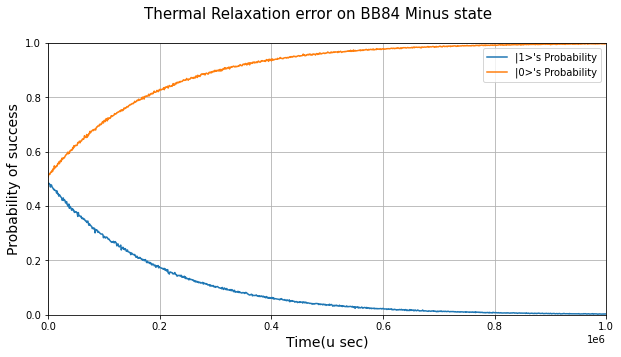

<Figure size 576x360 with 0 Axes>

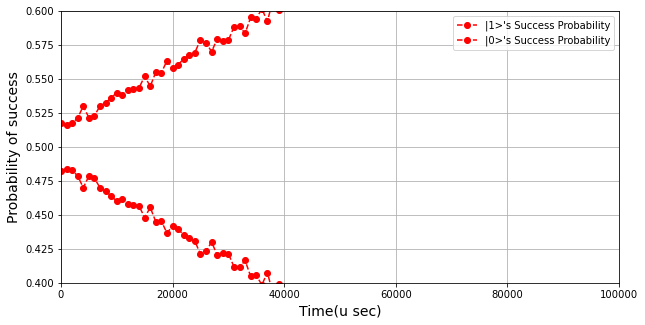

<Figure size 576x360 with 0 Axes>

In [90]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 Minus state',fontsize=15)
# naming the x axis
plt.xlabel('Time(u sec)',fontsize=14)
# naming the y axis
plt.ylabel('Probability of success',fontsize=14)
plt.grid()
# giving a title to my graph
# Set axis ranges; by default this will put major ticks every 25.
#ax.set_xlim(0, 300)
#ax.set_ylim(0, 1)
ax.set_xlim(0, 1000000)
ax.set_ylim(0,1)
fig = plt.figure(figsize=(8,5))
# line 2 points
x1=delay
x2=delay
#plotting the line 2 points
ax.plot(x1, dmg1, label = "|1>'s Probability")
ax.plot(x2, dm0, label = "|0>'s Probability")

#ax.axes.xaxis.set_ticks([])
# show a legend on the plot
ax.legend()
########################################################################


%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(0, 100000)
ax.set_ylim(0.4,0.6)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec)',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,dmg1,'ro--',label = "|1>'s Success Probability")
ax.plot(delay,dmg0,'ro--',label = "|0>'s Success Probability")

ax.legend()